In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_e_k5_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(4629816, 92)
(4629816, 8)
validation
(621056, 92)
(621056, 8)
test
(624904, 92)
(624904, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 92)]              0         


 dense (Dense)               (None, 1024)              95232     


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 785288 (3.00 MB)


Trainable params: 785288 (3.00 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/463 [..............................] - ETA: 12:10 - loss: 2.3149 - STD: 0.0782 - MAE: 0.2195

  6/463 [..............................] - ETA: 4s - loss: 2.1262 - STD: 0.0519 - MAE: 0.2171   

 11/463 [..............................] - ETA: 4s - loss: 2.1071 - STD: 0.0491 - MAE: 0.2168

 16/463 [>.............................] - ETA: 4s - loss: 2.0911 - STD: 0.0437 - MAE: 0.2168

 21/463 [>.............................] - ETA: 4s - loss: 2.0835 - STD: 0.0409 - MAE: 0.2169

 26/463 [>.............................] - ETA: 4s - loss: 2.0772 - STD: 0.0397 - MAE: 0.2168

 31/463 [=>............................] - ETA: 4s - loss: 2.0734 - STD: 0.0388 - MAE: 0.2168

 36/463 [=>............................] - ETA: 4s - loss: 2.0706 - STD: 0.0381 - MAE: 0.2167

 41/463 [=>............................] - ETA: 4s - loss: 2.0683 - STD: 0.0372 - MAE: 0.2167

 46/463 [=>............................] - ETA: 4s - loss: 2.0663 - STD: 0.0366 - MAE: 0.2167

 51/463 [==>...........................] - ETA: 4s - loss: 2.0647 - STD: 0.0362 - MAE: 0.2167

 56/463 [==>...........................] - ETA: 4s - loss: 2.0634 - STD: 0.0357 - MAE: 0.2167

 61/463 [==>...........................] - ETA: 4s - loss: 2.0618 - STD: 0.0355 - MAE: 0.2167

 66/463 [===>..........................] - ETA: 4s - loss: 2.0598 - STD: 0.0352 - MAE: 0.2167

 71/463 [===>..........................] - ETA: 4s - loss: 2.0573 - STD: 0.0351 - MAE: 0.2166

 76/463 [===>..........................] - ETA: 4s - loss: 2.0534 - STD: 0.0353 - MAE: 0.2165

 81/463 [====>.........................] - ETA: 4s - loss: 2.0483 - STD: 0.0359 - MAE: 0.2163

 86/463 [====>.........................] - ETA: 3s - loss: 2.0425 - STD: 0.0371 - MAE: 0.2160

 91/463 [====>.........................] - ETA: 3s - loss: 2.0371 - STD: 0.0387 - MAE: 0.2157

 96/463 [=====>........................] - ETA: 3s - loss: 2.0319 - STD: 0.0402 - MAE: 0.2154

101/463 [=====>........................] - ETA: 3s - loss: 2.0270 - STD: 0.0414 - MAE: 0.2152

106/463 [=====>........................] - ETA: 3s - loss: 2.0223 - STD: 0.0425 - MAE: 0.2150

111/463 [======>.......................] - ETA: 3s - loss: 2.0178 - STD: 0.0435 - MAE: 0.2147

116/463 [======>.......................] - ETA: 3s - loss: 2.0138 - STD: 0.0445 - MAE: 0.2145

121/463 [======>.......................] - ETA: 3s - loss: 2.0100 - STD: 0.0453 - MAE: 0.2143

126/463 [=======>......................] - ETA: 3s - loss: 2.0062 - STD: 0.0462 - MAE: 0.2142

131/463 [=======>......................] - ETA: 3s - loss: 2.0027 - STD: 0.0469 - MAE: 0.2140

136/463 [=======>......................] - ETA: 3s - loss: 1.9994 - STD: 0.0477 - MAE: 0.2138

141/463 [========>.....................] - ETA: 3s - loss: 1.9964 - STD: 0.0484 - MAE: 0.2136

146/463 [========>.....................] - ETA: 3s - loss: 1.9931 - STD: 0.0491 - MAE: 0.2135

151/463 [========>.....................] - ETA: 3s - loss: 1.9901 - STD: 0.0499 - MAE: 0.2133

156/463 [=========>....................] - ETA: 3s - loss: 1.9871 - STD: 0.0506 - MAE: 0.2131

161/463 [=========>....................] - ETA: 3s - loss: 1.9843 - STD: 0.0513 - MAE: 0.2129

166/463 [=========>....................] - ETA: 3s - loss: 1.9816 - STD: 0.0520 - MAE: 0.2128

171/463 [==========>...................] - ETA: 3s - loss: 1.9789 - STD: 0.0526 - MAE: 0.2126

176/463 [==========>...................] - ETA: 3s - loss: 1.9765 - STD: 0.0532 - MAE: 0.2125

181/463 [==========>...................] - ETA: 2s - loss: 1.9739 - STD: 0.0539 - MAE: 0.2123

186/463 [===========>..................] - ETA: 2s - loss: 1.9714 - STD: 0.0545 - MAE: 0.2122

191/463 [===========>..................] - ETA: 2s - loss: 1.9689 - STD: 0.0551 - MAE: 0.2120

196/463 [===========>..................] - ETA: 2s - loss: 1.9664 - STD: 0.0556 - MAE: 0.2119

201/463 [============>.................] - ETA: 2s - loss: 1.9640 - STD: 0.0562 - MAE: 0.2117

206/463 [============>.................] - ETA: 2s - loss: 1.9616 - STD: 0.0568 - MAE: 0.2116

211/463 [============>.................] - ETA: 2s - loss: 1.9592 - STD: 0.0573 - MAE: 0.2114

216/463 [============>.................] - ETA: 2s - loss: 1.9567 - STD: 0.0579 - MAE: 0.2113

221/463 [=============>................] - ETA: 2s - loss: 1.9543 - STD: 0.0585 - MAE: 0.2111

226/463 [=============>................] - ETA: 2s - loss: 1.9519 - STD: 0.0590 - MAE: 0.2110

231/463 [=============>................] - ETA: 2s - loss: 1.9496 - STD: 0.0596 - MAE: 0.2108

236/463 [==============>...............] - ETA: 2s - loss: 1.9473 - STD: 0.0601 - MAE: 0.2107

241/463 [==============>...............] - ETA: 2s - loss: 1.9450 - STD: 0.0606 - MAE: 0.2105

246/463 [==============>...............] - ETA: 2s - loss: 1.9429 - STD: 0.0611 - MAE: 0.2104

251/463 [===============>..............] - ETA: 2s - loss: 1.9407 - STD: 0.0616 - MAE: 0.2103

256/463 [===============>..............] - ETA: 2s - loss: 1.9386 - STD: 0.0621 - MAE: 0.2101

261/463 [===============>..............] - ETA: 2s - loss: 1.9366 - STD: 0.0626 - MAE: 0.2100

266/463 [================>.............] - ETA: 2s - loss: 1.9345 - STD: 0.0631 - MAE: 0.2099

271/463 [================>.............] - ETA: 2s - loss: 1.9325 - STD: 0.0635 - MAE: 0.2097

276/463 [================>.............] - ETA: 1s - loss: 1.9306 - STD: 0.0640 - MAE: 0.2096

281/463 [=================>............] - ETA: 1s - loss: 1.9285 - STD: 0.0644 - MAE: 0.2095

286/463 [=================>............] - ETA: 1s - loss: 1.9266 - STD: 0.0649 - MAE: 0.2093

291/463 [=================>............] - ETA: 1s - loss: 1.9248 - STD: 0.0653 - MAE: 0.2092

296/463 [==================>...........] - ETA: 1s - loss: 1.9230 - STD: 0.0658 - MAE: 0.2091

301/463 [==================>...........] - ETA: 1s - loss: 1.9214 - STD: 0.0661 - MAE: 0.2090

306/463 [==================>...........] - ETA: 1s - loss: 1.9196 - STD: 0.0665 - MAE: 0.2089

311/463 [===================>..........] - ETA: 1s - loss: 1.9180 - STD: 0.0669 - MAE: 0.2088

316/463 [===================>..........] - ETA: 1s - loss: 1.9165 - STD: 0.0673 - MAE: 0.2087

321/463 [===================>..........] - ETA: 1s - loss: 1.9149 - STD: 0.0677 - MAE: 0.2086

326/463 [====================>.........] - ETA: 1s - loss: 1.9133 - STD: 0.0680 - MAE: 0.2085

330/463 [====================>.........] - ETA: 1s - loss: 1.9121 - STD: 0.0683 - MAE: 0.2084

335/463 [====================>.........] - ETA: 1s - loss: 1.9104 - STD: 0.0687 - MAE: 0.2083

340/463 [=====================>........] - ETA: 1s - loss: 1.9089 - STD: 0.0690 - MAE: 0.2082

345/463 [=====================>........] - ETA: 1s - loss: 1.9074 - STD: 0.0693 - MAE: 0.2081

350/463 [=====================>........] - ETA: 1s - loss: 1.9058 - STD: 0.0697 - MAE: 0.2080

355/463 [======================>.......] - ETA: 1s - loss: 1.9044 - STD: 0.0700 - MAE: 0.2079

360/463 [======================>.......] - ETA: 1s - loss: 1.9030 - STD: 0.0703 - MAE: 0.2078

365/463 [======================>.......] - ETA: 1s - loss: 1.9018 - STD: 0.0706 - MAE: 0.2077

370/463 [======================>.......] - ETA: 1s - loss: 1.9005 - STD: 0.0710 - MAE: 0.2076

375/463 [=======================>......] - ETA: 1s - loss: 1.8992 - STD: 0.0713 - MAE: 0.2075

380/463 [=======================>......] - ETA: 1s - loss: 1.8979 - STD: 0.0715 - MAE: 0.2074

385/463 [=======================>......] - ETA: 1s - loss: 1.8967 - STD: 0.0718 - MAE: 0.2073

390/463 [========================>.....] - ETA: 0s - loss: 1.8954 - STD: 0.0721 - MAE: 0.2073

395/463 [========================>.....] - ETA: 0s - loss: 1.8942 - STD: 0.0724 - MAE: 0.2072

400/463 [========================>.....] - ETA: 0s - loss: 1.8930 - STD: 0.0727 - MAE: 0.2071

405/463 [=========================>....] - ETA: 0s - loss: 1.8918 - STD: 0.0729 - MAE: 0.2070

410/463 [=========================>....] - ETA: 0s - loss: 1.8906 - STD: 0.0732 - MAE: 0.2069

413/463 [=========================>....] - ETA: 0s - loss: 1.8899 - STD: 0.0734 - MAE: 0.2069

418/463 [==========================>...] - ETA: 0s - loss: 1.8888 - STD: 0.0736 - MAE: 0.2068

423/463 [==========================>...] - ETA: 0s - loss: 1.8877 - STD: 0.0739 - MAE: 0.2067

428/463 [==========================>...] - ETA: 0s - loss: 1.8865 - STD: 0.0741 - MAE: 0.2067

433/463 [===========================>..] - ETA: 0s - loss: 1.8854 - STD: 0.0744 - MAE: 0.2066

438/463 [===========================>..] - ETA: 0s - loss: 1.8842 - STD: 0.0746 - MAE: 0.2065

443/463 [===========================>..] - ETA: 0s - loss: 1.8831 - STD: 0.0749 - MAE: 0.2064

448/463 [============================>.] - ETA: 0s - loss: 1.8821 - STD: 0.0751 - MAE: 0.2064

453/463 [============================>.] - ETA: 0s - loss: 1.8810 - STD: 0.0753 - MAE: 0.2063

458/463 [============================>.] - ETA: 0s - loss: 1.8799 - STD: 0.0756 - MAE: 0.2062

463/463 [==============================] - ETA: 0s - loss: 1.8789 - STD: 0.0758 - MAE: 0.2062

463/463 [==============================] - 8s 15ms/step - loss: 1.8789 - STD: 0.0758 - MAE: 0.2062 - val_loss: 1.8084 - val_STD: 0.0947 - val_MAE: 0.2004


Epoch 2/10000


  1/463 [..............................] - ETA: 14s - loss: 1.7804 - STD: 0.0959 - MAE: 0.1998

  6/463 [..............................] - ETA: 4s - loss: 1.7802 - STD: 0.0975 - MAE: 0.1995 

 11/463 [..............................] - ETA: 4s - loss: 1.7819 - STD: 0.0975 - MAE: 0.1995

 16/463 [>.............................] - ETA: 4s - loss: 1.7812 - STD: 0.0970 - MAE: 0.1996

 21/463 [>.............................] - ETA: 4s - loss: 1.7816 - STD: 0.0974 - MAE: 0.1995

 26/463 [>.............................] - ETA: 4s - loss: 1.7809 - STD: 0.0975 - MAE: 0.1994

 31/463 [=>............................] - ETA: 4s - loss: 1.7809 - STD: 0.0976 - MAE: 0.1994

 36/463 [=>............................] - ETA: 4s - loss: 1.7811 - STD: 0.0977 - MAE: 0.1994

 41/463 [=>............................] - ETA: 4s - loss: 1.7805 - STD: 0.0976 - MAE: 0.1994

 46/463 [=>............................] - ETA: 4s - loss: 1.7803 - STD: 0.0977 - MAE: 0.1994

 51/463 [==>...........................] - ETA: 4s - loss: 1.7803 - STD: 0.0977 - MAE: 0.1994

 56/463 [==>...........................] - ETA: 4s - loss: 1.7800 - STD: 0.0977 - MAE: 0.1994

 61/463 [==>...........................] - ETA: 4s - loss: 1.7793 - STD: 0.0977 - MAE: 0.1994

 66/463 [===>..........................] - ETA: 4s - loss: 1.7793 - STD: 0.0977 - MAE: 0.1994

 71/463 [===>..........................] - ETA: 4s - loss: 1.7785 - STD: 0.0977 - MAE: 0.1994

 76/463 [===>..........................] - ETA: 4s - loss: 1.7779 - STD: 0.0978 - MAE: 0.1993

 81/463 [====>.........................] - ETA: 4s - loss: 1.7774 - STD: 0.0978 - MAE: 0.1993

 86/463 [====>.........................] - ETA: 3s - loss: 1.7771 - STD: 0.0979 - MAE: 0.1993

 91/463 [====>.........................] - ETA: 3s - loss: 1.7767 - STD: 0.0980 - MAE: 0.1992

 96/463 [=====>........................] - ETA: 3s - loss: 1.7765 - STD: 0.0981 - MAE: 0.1992

101/463 [=====>........................] - ETA: 3s - loss: 1.7760 - STD: 0.0981 - MAE: 0.1992

106/463 [=====>........................] - ETA: 3s - loss: 1.7754 - STD: 0.0982 - MAE: 0.1991

111/463 [======>.......................] - ETA: 3s - loss: 1.7751 - STD: 0.0983 - MAE: 0.1991

116/463 [======>.......................] - ETA: 3s - loss: 1.7745 - STD: 0.0984 - MAE: 0.1991

121/463 [======>.......................] - ETA: 3s - loss: 1.7739 - STD: 0.0984 - MAE: 0.1990

126/463 [=======>......................] - ETA: 3s - loss: 1.7737 - STD: 0.0985 - MAE: 0.1990

131/463 [=======>......................] - ETA: 3s - loss: 1.7734 - STD: 0.0986 - MAE: 0.1990

136/463 [=======>......................] - ETA: 3s - loss: 1.7732 - STD: 0.0987 - MAE: 0.1990

141/463 [========>.....................] - ETA: 3s - loss: 1.7730 - STD: 0.0987 - MAE: 0.1989

146/463 [========>.....................] - ETA: 3s - loss: 1.7728 - STD: 0.0988 - MAE: 0.1989

151/463 [========>.....................] - ETA: 3s - loss: 1.7725 - STD: 0.0989 - MAE: 0.1989

156/463 [=========>....................] - ETA: 3s - loss: 1.7723 - STD: 0.0990 - MAE: 0.1989

161/463 [=========>....................] - ETA: 3s - loss: 1.7721 - STD: 0.0990 - MAE: 0.1988

166/463 [=========>....................] - ETA: 3s - loss: 1.7717 - STD: 0.0991 - MAE: 0.1988

171/463 [==========>...................] - ETA: 3s - loss: 1.7714 - STD: 0.0991 - MAE: 0.1988

176/463 [==========>...................] - ETA: 3s - loss: 1.7709 - STD: 0.0992 - MAE: 0.1988

181/463 [==========>...................] - ETA: 2s - loss: 1.7706 - STD: 0.0992 - MAE: 0.1987

186/463 [===========>..................] - ETA: 2s - loss: 1.7702 - STD: 0.0993 - MAE: 0.1987

191/463 [===========>..................] - ETA: 2s - loss: 1.7698 - STD: 0.0993 - MAE: 0.1987

196/463 [===========>..................] - ETA: 2s - loss: 1.7696 - STD: 0.0994 - MAE: 0.1987

201/463 [============>.................] - ETA: 2s - loss: 1.7691 - STD: 0.0995 - MAE: 0.1986

206/463 [============>.................] - ETA: 2s - loss: 1.7688 - STD: 0.0995 - MAE: 0.1986

211/463 [============>.................] - ETA: 2s - loss: 1.7687 - STD: 0.0996 - MAE: 0.1986

216/463 [============>.................] - ETA: 2s - loss: 1.7685 - STD: 0.0997 - MAE: 0.1986

221/463 [=============>................] - ETA: 2s - loss: 1.7681 - STD: 0.0997 - MAE: 0.1986

226/463 [=============>................] - ETA: 2s - loss: 1.7678 - STD: 0.0997 - MAE: 0.1985

231/463 [=============>................] - ETA: 2s - loss: 1.7674 - STD: 0.0998 - MAE: 0.1985

236/463 [==============>...............] - ETA: 2s - loss: 1.7671 - STD: 0.0999 - MAE: 0.1985

241/463 [==============>...............] - ETA: 2s - loss: 1.7668 - STD: 0.0999 - MAE: 0.1985

246/463 [==============>...............] - ETA: 2s - loss: 1.7665 - STD: 0.1000 - MAE: 0.1985

251/463 [===============>..............] - ETA: 2s - loss: 1.7661 - STD: 0.1001 - MAE: 0.1984

256/463 [===============>..............] - ETA: 2s - loss: 1.7658 - STD: 0.1001 - MAE: 0.1984

261/463 [===============>..............] - ETA: 2s - loss: 1.7654 - STD: 0.1001 - MAE: 0.1984

266/463 [================>.............] - ETA: 2s - loss: 1.7650 - STD: 0.1002 - MAE: 0.1984

271/463 [================>.............] - ETA: 2s - loss: 1.7647 - STD: 0.1002 - MAE: 0.1983

276/463 [================>.............] - ETA: 1s - loss: 1.7643 - STD: 0.1003 - MAE: 0.1983

281/463 [=================>............] - ETA: 1s - loss: 1.7640 - STD: 0.1004 - MAE: 0.1983

286/463 [=================>............] - ETA: 1s - loss: 1.7636 - STD: 0.1004 - MAE: 0.1983

291/463 [=================>............] - ETA: 1s - loss: 1.7633 - STD: 0.1005 - MAE: 0.1982

296/463 [==================>...........] - ETA: 1s - loss: 1.7631 - STD: 0.1005 - MAE: 0.1982

301/463 [==================>...........] - ETA: 1s - loss: 1.7628 - STD: 0.1006 - MAE: 0.1982

306/463 [==================>...........] - ETA: 1s - loss: 1.7625 - STD: 0.1006 - MAE: 0.1982

311/463 [===================>..........] - ETA: 1s - loss: 1.7622 - STD: 0.1007 - MAE: 0.1982

316/463 [===================>..........] - ETA: 1s - loss: 1.7620 - STD: 0.1007 - MAE: 0.1982

321/463 [===================>..........] - ETA: 1s - loss: 1.7617 - STD: 0.1008 - MAE: 0.1981

326/463 [====================>.........] - ETA: 1s - loss: 1.7615 - STD: 0.1008 - MAE: 0.1981

331/463 [====================>.........] - ETA: 1s - loss: 1.7613 - STD: 0.1009 - MAE: 0.1981

336/463 [====================>.........] - ETA: 1s - loss: 1.7610 - STD: 0.1009 - MAE: 0.1981

341/463 [=====================>........] - ETA: 1s - loss: 1.7609 - STD: 0.1010 - MAE: 0.1981

346/463 [=====================>........] - ETA: 1s - loss: 1.7609 - STD: 0.1010 - MAE: 0.1981

351/463 [=====================>........] - ETA: 1s - loss: 1.7608 - STD: 0.1011 - MAE: 0.1980

356/463 [======================>.......] - ETA: 1s - loss: 1.7605 - STD: 0.1011 - MAE: 0.1980

361/463 [======================>.......] - ETA: 1s - loss: 1.7602 - STD: 0.1011 - MAE: 0.1980

366/463 [======================>.......] - ETA: 1s - loss: 1.7600 - STD: 0.1012 - MAE: 0.1980

371/463 [=======================>......] - ETA: 0s - loss: 1.7597 - STD: 0.1012 - MAE: 0.1980

376/463 [=======================>......] - ETA: 0s - loss: 1.7595 - STD: 0.1012 - MAE: 0.1980

381/463 [=======================>......] - ETA: 0s - loss: 1.7592 - STD: 0.1013 - MAE: 0.1979

386/463 [========================>.....] - ETA: 0s - loss: 1.7590 - STD: 0.1013 - MAE: 0.1979

391/463 [========================>.....] - ETA: 0s - loss: 1.7588 - STD: 0.1014 - MAE: 0.1979

396/463 [========================>.....] - ETA: 0s - loss: 1.7586 - STD: 0.1014 - MAE: 0.1979

401/463 [========================>.....] - ETA: 0s - loss: 1.7584 - STD: 0.1014 - MAE: 0.1979

406/463 [=========================>....] - ETA: 0s - loss: 1.7583 - STD: 0.1015 - MAE: 0.1979

411/463 [=========================>....] - ETA: 0s - loss: 1.7581 - STD: 0.1015 - MAE: 0.1979

416/463 [=========================>....] - ETA: 0s - loss: 1.7578 - STD: 0.1016 - MAE: 0.1978

421/463 [==========================>...] - ETA: 0s - loss: 1.7576 - STD: 0.1016 - MAE: 0.1978

426/463 [==========================>...] - ETA: 0s - loss: 1.7573 - STD: 0.1016 - MAE: 0.1978

431/463 [==========================>...] - ETA: 0s - loss: 1.7571 - STD: 0.1017 - MAE: 0.1978

436/463 [===========================>..] - ETA: 0s - loss: 1.7569 - STD: 0.1017 - MAE: 0.1978

441/463 [===========================>..] - ETA: 0s - loss: 1.7567 - STD: 0.1017 - MAE: 0.1978

446/463 [===========================>..] - ETA: 0s - loss: 1.7565 - STD: 0.1018 - MAE: 0.1978

451/463 [============================>.] - ETA: 0s - loss: 1.7562 - STD: 0.1018 - MAE: 0.1977

456/463 [============================>.] - ETA: 0s - loss: 1.7560 - STD: 0.1018 - MAE: 0.1977

461/463 [============================>.] - ETA: 0s - loss: 1.7558 - STD: 0.1019 - MAE: 0.1977

463/463 [==============================] - 5s 11ms/step - loss: 1.7557 - STD: 0.1019 - MAE: 0.1977 - val_loss: 1.7599 - val_STD: 0.1051 - val_MAE: 0.1966


Epoch 3/10000


  1/463 [..............................] - ETA: 12s - loss: 1.7407 - STD: 0.1064 - MAE: 0.1962

  6/463 [..............................] - ETA: 4s - loss: 1.7440 - STD: 0.1049 - MAE: 0.1966 

 11/463 [..............................] - ETA: 4s - loss: 1.7402 - STD: 0.1051 - MAE: 0.1965

 16/463 [>.............................] - ETA: 4s - loss: 1.7380 - STD: 0.1053 - MAE: 0.1964

 21/463 [>.............................] - ETA: 4s - loss: 1.7382 - STD: 0.1053 - MAE: 0.1964

 26/463 [>.............................] - ETA: 4s - loss: 1.7377 - STD: 0.1053 - MAE: 0.1964

 31/463 [=>............................] - ETA: 4s - loss: 1.7367 - STD: 0.1053 - MAE: 0.1964

 36/463 [=>............................] - ETA: 4s - loss: 1.7360 - STD: 0.1053 - MAE: 0.1963

 41/463 [=>............................] - ETA: 4s - loss: 1.7360 - STD: 0.1053 - MAE: 0.1963

 46/463 [=>............................] - ETA: 4s - loss: 1.7356 - STD: 0.1053 - MAE: 0.1963

 51/463 [==>...........................] - ETA: 4s - loss: 1.7359 - STD: 0.1053 - MAE: 0.1963

 56/463 [==>...........................] - ETA: 4s - loss: 1.7361 - STD: 0.1053 - MAE: 0.1963

 61/463 [==>...........................] - ETA: 4s - loss: 1.7363 - STD: 0.1055 - MAE: 0.1963

 66/463 [===>..........................] - ETA: 4s - loss: 1.7364 - STD: 0.1053 - MAE: 0.1963

 71/463 [===>..........................] - ETA: 4s - loss: 1.7366 - STD: 0.1054 - MAE: 0.1963

 76/463 [===>..........................] - ETA: 4s - loss: 1.7365 - STD: 0.1053 - MAE: 0.1964

 81/463 [====>.........................] - ETA: 4s - loss: 1.7367 - STD: 0.1053 - MAE: 0.1964

 86/463 [====>.........................] - ETA: 4s - loss: 1.7365 - STD: 0.1054 - MAE: 0.1963

 91/463 [====>.........................] - ETA: 3s - loss: 1.7363 - STD: 0.1054 - MAE: 0.1963

 96/463 [=====>........................] - ETA: 3s - loss: 1.7362 - STD: 0.1054 - MAE: 0.1963

101/463 [=====>........................] - ETA: 3s - loss: 1.7359 - STD: 0.1055 - MAE: 0.1963

106/463 [=====>........................] - ETA: 3s - loss: 1.7361 - STD: 0.1054 - MAE: 0.1963

111/463 [======>.......................] - ETA: 3s - loss: 1.7359 - STD: 0.1054 - MAE: 0.1963

116/463 [======>.......................] - ETA: 3s - loss: 1.7357 - STD: 0.1055 - MAE: 0.1963

121/463 [======>.......................] - ETA: 3s - loss: 1.7356 - STD: 0.1055 - MAE: 0.1963

126/463 [=======>......................] - ETA: 3s - loss: 1.7352 - STD: 0.1055 - MAE: 0.1962

131/463 [=======>......................] - ETA: 3s - loss: 1.7352 - STD: 0.1056 - MAE: 0.1962

136/463 [=======>......................] - ETA: 3s - loss: 1.7353 - STD: 0.1056 - MAE: 0.1962

141/463 [========>.....................] - ETA: 3s - loss: 1.7353 - STD: 0.1056 - MAE: 0.1962

146/463 [========>.....................] - ETA: 3s - loss: 1.7355 - STD: 0.1056 - MAE: 0.1962

151/463 [========>.....................] - ETA: 3s - loss: 1.7354 - STD: 0.1056 - MAE: 0.1962

156/463 [=========>....................] - ETA: 3s - loss: 1.7353 - STD: 0.1056 - MAE: 0.1962

161/463 [=========>....................] - ETA: 3s - loss: 1.7352 - STD: 0.1056 - MAE: 0.1962

166/463 [=========>....................] - ETA: 3s - loss: 1.7351 - STD: 0.1056 - MAE: 0.1962

171/463 [==========>...................] - ETA: 3s - loss: 1.7350 - STD: 0.1056 - MAE: 0.1962

176/463 [==========>...................] - ETA: 3s - loss: 1.7349 - STD: 0.1056 - MAE: 0.1962

181/463 [==========>...................] - ETA: 3s - loss: 1.7347 - STD: 0.1056 - MAE: 0.1962

186/463 [===========>..................] - ETA: 2s - loss: 1.7344 - STD: 0.1056 - MAE: 0.1962

191/463 [===========>..................] - ETA: 2s - loss: 1.7343 - STD: 0.1056 - MAE: 0.1962

196/463 [===========>..................] - ETA: 2s - loss: 1.7342 - STD: 0.1057 - MAE: 0.1962

201/463 [============>.................] - ETA: 2s - loss: 1.7342 - STD: 0.1057 - MAE: 0.1962

206/463 [============>.................] - ETA: 2s - loss: 1.7341 - STD: 0.1057 - MAE: 0.1962

211/463 [============>.................] - ETA: 2s - loss: 1.7340 - STD: 0.1058 - MAE: 0.1962

216/463 [============>.................] - ETA: 2s - loss: 1.7338 - STD: 0.1058 - MAE: 0.1962

221/463 [=============>................] - ETA: 2s - loss: 1.7337 - STD: 0.1058 - MAE: 0.1961

226/463 [=============>................] - ETA: 2s - loss: 1.7336 - STD: 0.1058 - MAE: 0.1961

231/463 [=============>................] - ETA: 2s - loss: 1.7334 - STD: 0.1059 - MAE: 0.1961

236/463 [==============>...............] - ETA: 2s - loss: 1.7333 - STD: 0.1059 - MAE: 0.1961

241/463 [==============>...............] - ETA: 2s - loss: 1.7331 - STD: 0.1059 - MAE: 0.1961

246/463 [==============>...............] - ETA: 2s - loss: 1.7328 - STD: 0.1059 - MAE: 0.1961

251/463 [===============>..............] - ETA: 2s - loss: 1.7327 - STD: 0.1060 - MAE: 0.1961

256/463 [===============>..............] - ETA: 2s - loss: 1.7325 - STD: 0.1060 - MAE: 0.1961

261/463 [===============>..............] - ETA: 2s - loss: 1.7323 - STD: 0.1060 - MAE: 0.1960

266/463 [================>.............] - ETA: 2s - loss: 1.7322 - STD: 0.1061 - MAE: 0.1960

271/463 [================>.............] - ETA: 2s - loss: 1.7321 - STD: 0.1061 - MAE: 0.1960

276/463 [================>.............] - ETA: 1s - loss: 1.7320 - STD: 0.1061 - MAE: 0.1960

281/463 [=================>............] - ETA: 1s - loss: 1.7320 - STD: 0.1061 - MAE: 0.1960

286/463 [=================>............] - ETA: 1s - loss: 1.7318 - STD: 0.1061 - MAE: 0.1960

291/463 [=================>............] - ETA: 1s - loss: 1.7317 - STD: 0.1061 - MAE: 0.1960

296/463 [==================>...........] - ETA: 1s - loss: 1.7316 - STD: 0.1061 - MAE: 0.1960

301/463 [==================>...........] - ETA: 1s - loss: 1.7315 - STD: 0.1061 - MAE: 0.1960

306/463 [==================>...........] - ETA: 1s - loss: 1.7314 - STD: 0.1062 - MAE: 0.1960

311/463 [===================>..........] - ETA: 1s - loss: 1.7313 - STD: 0.1062 - MAE: 0.1960

316/463 [===================>..........] - ETA: 1s - loss: 1.7312 - STD: 0.1062 - MAE: 0.1960

321/463 [===================>..........] - ETA: 1s - loss: 1.7310 - STD: 0.1062 - MAE: 0.1959

326/463 [====================>.........] - ETA: 1s - loss: 1.7309 - STD: 0.1063 - MAE: 0.1959

331/463 [====================>.........] - ETA: 1s - loss: 1.7307 - STD: 0.1063 - MAE: 0.1959

336/463 [====================>.........] - ETA: 1s - loss: 1.7307 - STD: 0.1063 - MAE: 0.1959

341/463 [=====================>........] - ETA: 1s - loss: 1.7305 - STD: 0.1063 - MAE: 0.1959

346/463 [=====================>........] - ETA: 1s - loss: 1.7305 - STD: 0.1063 - MAE: 0.1959

351/463 [=====================>........] - ETA: 1s - loss: 1.7305 - STD: 0.1064 - MAE: 0.1959

356/463 [======================>.......] - ETA: 1s - loss: 1.7304 - STD: 0.1064 - MAE: 0.1959

361/463 [======================>.......] - ETA: 1s - loss: 1.7303 - STD: 0.1064 - MAE: 0.1959

366/463 [======================>.......] - ETA: 1s - loss: 1.7302 - STD: 0.1064 - MAE: 0.1959

371/463 [=======================>......] - ETA: 0s - loss: 1.7300 - STD: 0.1064 - MAE: 0.1959

376/463 [=======================>......] - ETA: 0s - loss: 1.7300 - STD: 0.1064 - MAE: 0.1959

381/463 [=======================>......] - ETA: 0s - loss: 1.7299 - STD: 0.1064 - MAE: 0.1959

386/463 [========================>.....] - ETA: 0s - loss: 1.7297 - STD: 0.1064 - MAE: 0.1959

391/463 [========================>.....] - ETA: 0s - loss: 1.7297 - STD: 0.1065 - MAE: 0.1959

396/463 [========================>.....] - ETA: 0s - loss: 1.7296 - STD: 0.1065 - MAE: 0.1958

401/463 [========================>.....] - ETA: 0s - loss: 1.7296 - STD: 0.1065 - MAE: 0.1958

406/463 [=========================>....] - ETA: 0s - loss: 1.7297 - STD: 0.1065 - MAE: 0.1958

411/463 [=========================>....] - ETA: 0s - loss: 1.7297 - STD: 0.1065 - MAE: 0.1958

416/463 [=========================>....] - ETA: 0s - loss: 1.7297 - STD: 0.1065 - MAE: 0.1958

421/463 [==========================>...] - ETA: 0s - loss: 1.7296 - STD: 0.1065 - MAE: 0.1958

426/463 [==========================>...] - ETA: 0s - loss: 1.7295 - STD: 0.1065 - MAE: 0.1958

431/463 [==========================>...] - ETA: 0s - loss: 1.7294 - STD: 0.1066 - MAE: 0.1958

436/463 [===========================>..] - ETA: 0s - loss: 1.7292 - STD: 0.1066 - MAE: 0.1958

441/463 [===========================>..] - ETA: 0s - loss: 1.7292 - STD: 0.1066 - MAE: 0.1958

446/463 [===========================>..] - ETA: 0s - loss: 1.7291 - STD: 0.1066 - MAE: 0.1958

451/463 [============================>.] - ETA: 0s - loss: 1.7291 - STD: 0.1066 - MAE: 0.1958

456/463 [============================>.] - ETA: 0s - loss: 1.7291 - STD: 0.1066 - MAE: 0.1958

461/463 [============================>.] - ETA: 0s - loss: 1.7290 - STD: 0.1066 - MAE: 0.1958

463/463 [==============================] - 5s 11ms/step - loss: 1.7290 - STD: 0.1066 - MAE: 0.1958 - val_loss: 1.7269 - val_STD: 0.1023 - val_MAE: 0.1963


Epoch 4/10000


  1/463 [..............................] - ETA: 13s - loss: 1.7349 - STD: 0.1045 - MAE: 0.1965

  6/463 [..............................] - ETA: 5s - loss: 1.7179 - STD: 0.1080 - MAE: 0.1950 

 11/463 [..............................] - ETA: 4s - loss: 1.7175 - STD: 0.1076 - MAE: 0.1952

 16/463 [>.............................] - ETA: 4s - loss: 1.7174 - STD: 0.1082 - MAE: 0.1950

 21/463 [>.............................] - ETA: 4s - loss: 1.7176 - STD: 0.1081 - MAE: 0.1950

 26/463 [>.............................] - ETA: 4s - loss: 1.7174 - STD: 0.1082 - MAE: 0.1950

 31/463 [=>............................] - ETA: 4s - loss: 1.7170 - STD: 0.1080 - MAE: 0.1950

 36/463 [=>............................] - ETA: 4s - loss: 1.7163 - STD: 0.1083 - MAE: 0.1949

 41/463 [=>............................] - ETA: 4s - loss: 1.7168 - STD: 0.1084 - MAE: 0.1949

 46/463 [=>............................] - ETA: 4s - loss: 1.7167 - STD: 0.1085 - MAE: 0.1949

 51/463 [==>...........................] - ETA: 4s - loss: 1.7162 - STD: 0.1085 - MAE: 0.1949

 56/463 [==>...........................] - ETA: 4s - loss: 1.7160 - STD: 0.1086 - MAE: 0.1949

 61/463 [==>...........................] - ETA: 4s - loss: 1.7161 - STD: 0.1086 - MAE: 0.1949

 66/463 [===>..........................] - ETA: 4s - loss: 1.7161 - STD: 0.1086 - MAE: 0.1949

 71/463 [===>..........................] - ETA: 4s - loss: 1.7165 - STD: 0.1086 - MAE: 0.1949

 76/463 [===>..........................] - ETA: 4s - loss: 1.7163 - STD: 0.1086 - MAE: 0.1949

 81/463 [====>.........................] - ETA: 4s - loss: 1.7163 - STD: 0.1086 - MAE: 0.1949

 86/463 [====>.........................] - ETA: 3s - loss: 1.7164 - STD: 0.1085 - MAE: 0.1949

 91/463 [====>.........................] - ETA: 3s - loss: 1.7168 - STD: 0.1086 - MAE: 0.1949

 96/463 [=====>........................] - ETA: 3s - loss: 1.7168 - STD: 0.1086 - MAE: 0.1949

101/463 [=====>........................] - ETA: 3s - loss: 1.7170 - STD: 0.1085 - MAE: 0.1949

106/463 [=====>........................] - ETA: 3s - loss: 1.7171 - STD: 0.1086 - MAE: 0.1949

111/463 [======>.......................] - ETA: 3s - loss: 1.7171 - STD: 0.1085 - MAE: 0.1950

116/463 [======>.......................] - ETA: 3s - loss: 1.7170 - STD: 0.1085 - MAE: 0.1950

121/463 [======>.......................] - ETA: 3s - loss: 1.7167 - STD: 0.1086 - MAE: 0.1949

126/463 [=======>......................] - ETA: 3s - loss: 1.7166 - STD: 0.1086 - MAE: 0.1949

131/463 [=======>......................] - ETA: 3s - loss: 1.7164 - STD: 0.1086 - MAE: 0.1949

136/463 [=======>......................] - ETA: 3s - loss: 1.7163 - STD: 0.1086 - MAE: 0.1949

141/463 [========>.....................] - ETA: 3s - loss: 1.7161 - STD: 0.1086 - MAE: 0.1949

146/463 [========>.....................] - ETA: 3s - loss: 1.7161 - STD: 0.1086 - MAE: 0.1949

151/463 [========>.....................] - ETA: 3s - loss: 1.7159 - STD: 0.1087 - MAE: 0.1949

156/463 [=========>....................] - ETA: 3s - loss: 1.7159 - STD: 0.1087 - MAE: 0.1949

161/463 [=========>....................] - ETA: 3s - loss: 1.7160 - STD: 0.1087 - MAE: 0.1949

166/463 [=========>....................] - ETA: 3s - loss: 1.7160 - STD: 0.1087 - MAE: 0.1949

171/463 [==========>...................] - ETA: 3s - loss: 1.7160 - STD: 0.1088 - MAE: 0.1949

176/463 [==========>...................] - ETA: 3s - loss: 1.7160 - STD: 0.1087 - MAE: 0.1949

181/463 [==========>...................] - ETA: 2s - loss: 1.7158 - STD: 0.1088 - MAE: 0.1949

186/463 [===========>..................] - ETA: 2s - loss: 1.7158 - STD: 0.1088 - MAE: 0.1949

191/463 [===========>..................] - ETA: 2s - loss: 1.7154 - STD: 0.1088 - MAE: 0.1948

196/463 [===========>..................] - ETA: 2s - loss: 1.7153 - STD: 0.1088 - MAE: 0.1948

201/463 [============>.................] - ETA: 2s - loss: 1.7152 - STD: 0.1088 - MAE: 0.1948

206/463 [============>.................] - ETA: 2s - loss: 1.7152 - STD: 0.1089 - MAE: 0.1948

211/463 [============>.................] - ETA: 2s - loss: 1.7153 - STD: 0.1089 - MAE: 0.1948

216/463 [============>.................] - ETA: 2s - loss: 1.7151 - STD: 0.1089 - MAE: 0.1948

221/463 [=============>................] - ETA: 2s - loss: 1.7149 - STD: 0.1089 - MAE: 0.1948

226/463 [=============>................] - ETA: 2s - loss: 1.7148 - STD: 0.1089 - MAE: 0.1948

231/463 [=============>................] - ETA: 2s - loss: 1.7148 - STD: 0.1089 - MAE: 0.1948

236/463 [==============>...............] - ETA: 2s - loss: 1.7148 - STD: 0.1089 - MAE: 0.1948

241/463 [==============>...............] - ETA: 2s - loss: 1.7148 - STD: 0.1089 - MAE: 0.1948

246/463 [==============>...............] - ETA: 2s - loss: 1.7148 - STD: 0.1090 - MAE: 0.1948

251/463 [===============>..............] - ETA: 2s - loss: 1.7150 - STD: 0.1090 - MAE: 0.1948

256/463 [===============>..............] - ETA: 2s - loss: 1.7154 - STD: 0.1090 - MAE: 0.1948

261/463 [===============>..............] - ETA: 2s - loss: 1.7157 - STD: 0.1090 - MAE: 0.1948

266/463 [================>.............] - ETA: 2s - loss: 1.7157 - STD: 0.1089 - MAE: 0.1948

271/463 [================>.............] - ETA: 2s - loss: 1.7156 - STD: 0.1089 - MAE: 0.1948

276/463 [================>.............] - ETA: 1s - loss: 1.7155 - STD: 0.1089 - MAE: 0.1948

281/463 [=================>............] - ETA: 1s - loss: 1.7155 - STD: 0.1089 - MAE: 0.1948

286/463 [=================>............] - ETA: 1s - loss: 1.7155 - STD: 0.1089 - MAE: 0.1948

291/463 [=================>............] - ETA: 1s - loss: 1.7156 - STD: 0.1089 - MAE: 0.1948

296/463 [==================>...........] - ETA: 1s - loss: 1.7154 - STD: 0.1089 - MAE: 0.1948

301/463 [==================>...........] - ETA: 1s - loss: 1.7152 - STD: 0.1089 - MAE: 0.1948

306/463 [==================>...........] - ETA: 1s - loss: 1.7150 - STD: 0.1089 - MAE: 0.1948

311/463 [===================>..........] - ETA: 1s - loss: 1.7149 - STD: 0.1089 - MAE: 0.1948

316/463 [===================>..........] - ETA: 1s - loss: 1.7148 - STD: 0.1089 - MAE: 0.1948

321/463 [===================>..........] - ETA: 1s - loss: 1.7147 - STD: 0.1090 - MAE: 0.1948

326/463 [====================>.........] - ETA: 1s - loss: 1.7147 - STD: 0.1090 - MAE: 0.1948

331/463 [====================>.........] - ETA: 1s - loss: 1.7145 - STD: 0.1090 - MAE: 0.1948

336/463 [====================>.........] - ETA: 1s - loss: 1.7144 - STD: 0.1090 - MAE: 0.1947

341/463 [=====================>........] - ETA: 1s - loss: 1.7143 - STD: 0.1091 - MAE: 0.1947

346/463 [=====================>........] - ETA: 1s - loss: 1.7142 - STD: 0.1090 - MAE: 0.1947

351/463 [=====================>........] - ETA: 1s - loss: 1.7142 - STD: 0.1091 - MAE: 0.1947

356/463 [======================>.......] - ETA: 1s - loss: 1.7141 - STD: 0.1091 - MAE: 0.1947

361/463 [======================>.......] - ETA: 1s - loss: 1.7141 - STD: 0.1091 - MAE: 0.1947

366/463 [======================>.......] - ETA: 1s - loss: 1.7140 - STD: 0.1091 - MAE: 0.1947

371/463 [=======================>......] - ETA: 0s - loss: 1.7140 - STD: 0.1091 - MAE: 0.1947

376/463 [=======================>......] - ETA: 0s - loss: 1.7140 - STD: 0.1091 - MAE: 0.1947

381/463 [=======================>......] - ETA: 0s - loss: 1.7139 - STD: 0.1091 - MAE: 0.1947

386/463 [========================>.....] - ETA: 0s - loss: 1.7139 - STD: 0.1091 - MAE: 0.1947

391/463 [========================>.....] - ETA: 0s - loss: 1.7139 - STD: 0.1091 - MAE: 0.1947

396/463 [========================>.....] - ETA: 0s - loss: 1.7137 - STD: 0.1091 - MAE: 0.1947

401/463 [========================>.....] - ETA: 0s - loss: 1.7136 - STD: 0.1091 - MAE: 0.1947

406/463 [=========================>....] - ETA: 0s - loss: 1.7134 - STD: 0.1092 - MAE: 0.1947

411/463 [=========================>....] - ETA: 0s - loss: 1.7133 - STD: 0.1092 - MAE: 0.1947

416/463 [=========================>....] - ETA: 0s - loss: 1.7133 - STD: 0.1092 - MAE: 0.1947

421/463 [==========================>...] - ETA: 0s - loss: 1.7132 - STD: 0.1092 - MAE: 0.1947

426/463 [==========================>...] - ETA: 0s - loss: 1.7131 - STD: 0.1092 - MAE: 0.1947

431/463 [==========================>...] - ETA: 0s - loss: 1.7130 - STD: 0.1092 - MAE: 0.1946

436/463 [===========================>..] - ETA: 0s - loss: 1.7130 - STD: 0.1093 - MAE: 0.1946

441/463 [===========================>..] - ETA: 0s - loss: 1.7130 - STD: 0.1092 - MAE: 0.1946

446/463 [===========================>..] - ETA: 0s - loss: 1.7130 - STD: 0.1093 - MAE: 0.1946

451/463 [============================>.] - ETA: 0s - loss: 1.7129 - STD: 0.1092 - MAE: 0.1946

456/463 [============================>.] - ETA: 0s - loss: 1.7128 - STD: 0.1093 - MAE: 0.1946

461/463 [============================>.] - ETA: 0s - loss: 1.7127 - STD: 0.1093 - MAE: 0.1946

463/463 [==============================] - 5s 11ms/step - loss: 1.7128 - STD: 0.1093 - MAE: 0.1946 - val_loss: 1.7248 - val_STD: 0.1085 - val_MAE: 0.1949


Epoch 5/10000


  1/463 [..............................] - ETA: 11s - loss: 1.6940 - STD: 0.1110 - MAE: 0.1935

  6/463 [..............................] - ETA: 5s - loss: 1.7059 - STD: 0.1113 - MAE: 0.1939 

 11/463 [..............................] - ETA: 4s - loss: 1.7047 - STD: 0.1103 - MAE: 0.1941

 16/463 [>.............................] - ETA: 4s - loss: 1.7052 - STD: 0.1103 - MAE: 0.1941

 21/463 [>.............................] - ETA: 4s - loss: 1.7041 - STD: 0.1100 - MAE: 0.1941

 26/463 [>.............................] - ETA: 4s - loss: 1.7029 - STD: 0.1102 - MAE: 0.1940

 31/463 [=>............................] - ETA: 4s - loss: 1.7032 - STD: 0.1104 - MAE: 0.1940

 36/463 [=>............................] - ETA: 4s - loss: 1.7032 - STD: 0.1105 - MAE: 0.1940

 41/463 [=>............................] - ETA: 4s - loss: 1.7036 - STD: 0.1104 - MAE: 0.1940

 46/463 [=>............................] - ETA: 4s - loss: 1.7033 - STD: 0.1105 - MAE: 0.1940

 51/463 [==>...........................] - ETA: 4s - loss: 1.7030 - STD: 0.1105 - MAE: 0.1940

 56/463 [==>...........................] - ETA: 4s - loss: 1.7028 - STD: 0.1106 - MAE: 0.1940

 61/463 [==>...........................] - ETA: 4s - loss: 1.7026 - STD: 0.1107 - MAE: 0.1939

 66/463 [===>..........................] - ETA: 4s - loss: 1.7026 - STD: 0.1106 - MAE: 0.1939

 71/463 [===>..........................] - ETA: 4s - loss: 1.7025 - STD: 0.1106 - MAE: 0.1939

 76/463 [===>..........................] - ETA: 4s - loss: 1.7023 - STD: 0.1107 - MAE: 0.1939

 81/463 [====>.........................] - ETA: 4s - loss: 1.7027 - STD: 0.1107 - MAE: 0.1939

 86/463 [====>.........................] - ETA: 4s - loss: 1.7033 - STD: 0.1108 - MAE: 0.1939

 91/463 [====>.........................] - ETA: 3s - loss: 1.7033 - STD: 0.1108 - MAE: 0.1939

 96/463 [=====>........................] - ETA: 3s - loss: 1.7031 - STD: 0.1108 - MAE: 0.1939

101/463 [=====>........................] - ETA: 3s - loss: 1.7028 - STD: 0.1107 - MAE: 0.1939

106/463 [=====>........................] - ETA: 3s - loss: 1.7024 - STD: 0.1108 - MAE: 0.1939

111/463 [======>.......................] - ETA: 3s - loss: 1.7020 - STD: 0.1108 - MAE: 0.1939

116/463 [======>.......................] - ETA: 3s - loss: 1.7017 - STD: 0.1109 - MAE: 0.1938

121/463 [======>.......................] - ETA: 3s - loss: 1.7019 - STD: 0.1109 - MAE: 0.1938

126/463 [=======>......................] - ETA: 3s - loss: 1.7019 - STD: 0.1109 - MAE: 0.1938

131/463 [=======>......................] - ETA: 3s - loss: 1.7019 - STD: 0.1109 - MAE: 0.1938

136/463 [=======>......................] - ETA: 3s - loss: 1.7017 - STD: 0.1109 - MAE: 0.1938

141/463 [========>.....................] - ETA: 3s - loss: 1.7018 - STD: 0.1109 - MAE: 0.1939

146/463 [========>.....................] - ETA: 3s - loss: 1.7018 - STD: 0.1109 - MAE: 0.1938

151/463 [========>.....................] - ETA: 3s - loss: 1.7017 - STD: 0.1109 - MAE: 0.1938

156/463 [=========>....................] - ETA: 3s - loss: 1.7016 - STD: 0.1109 - MAE: 0.1938

161/463 [=========>....................] - ETA: 3s - loss: 1.7012 - STD: 0.1109 - MAE: 0.1938

166/463 [=========>....................] - ETA: 3s - loss: 1.7010 - STD: 0.1109 - MAE: 0.1938

171/463 [==========>...................] - ETA: 3s - loss: 1.7009 - STD: 0.1110 - MAE: 0.1938

176/463 [==========>...................] - ETA: 3s - loss: 1.7009 - STD: 0.1110 - MAE: 0.1938

181/463 [==========>...................] - ETA: 2s - loss: 1.7011 - STD: 0.1111 - MAE: 0.1938

186/463 [===========>..................] - ETA: 2s - loss: 1.7012 - STD: 0.1111 - MAE: 0.1938

191/463 [===========>..................] - ETA: 2s - loss: 1.7012 - STD: 0.1111 - MAE: 0.1938

196/463 [===========>..................] - ETA: 2s - loss: 1.7013 - STD: 0.1111 - MAE: 0.1938

201/463 [============>.................] - ETA: 2s - loss: 1.7012 - STD: 0.1111 - MAE: 0.1938

206/463 [============>.................] - ETA: 2s - loss: 1.7011 - STD: 0.1111 - MAE: 0.1938

211/463 [============>.................] - ETA: 2s - loss: 1.7011 - STD: 0.1111 - MAE: 0.1938

216/463 [============>.................] - ETA: 2s - loss: 1.7010 - STD: 0.1111 - MAE: 0.1938

221/463 [=============>................] - ETA: 2s - loss: 1.7010 - STD: 0.1111 - MAE: 0.1938

226/463 [=============>................] - ETA: 2s - loss: 1.7009 - STD: 0.1111 - MAE: 0.1938

231/463 [=============>................] - ETA: 2s - loss: 1.7009 - STD: 0.1111 - MAE: 0.1938

236/463 [==============>...............] - ETA: 2s - loss: 1.7008 - STD: 0.1111 - MAE: 0.1938

241/463 [==============>...............] - ETA: 2s - loss: 1.7007 - STD: 0.1112 - MAE: 0.1938

246/463 [==============>...............] - ETA: 2s - loss: 1.7006 - STD: 0.1111 - MAE: 0.1938

251/463 [===============>..............] - ETA: 2s - loss: 1.7006 - STD: 0.1112 - MAE: 0.1937

256/463 [===============>..............] - ETA: 2s - loss: 1.7005 - STD: 0.1112 - MAE: 0.1937

261/463 [===============>..............] - ETA: 2s - loss: 1.7005 - STD: 0.1112 - MAE: 0.1937

266/463 [================>.............] - ETA: 2s - loss: 1.7005 - STD: 0.1112 - MAE: 0.1937

271/463 [================>.............] - ETA: 2s - loss: 1.7005 - STD: 0.1112 - MAE: 0.1937

276/463 [================>.............] - ETA: 1s - loss: 1.7004 - STD: 0.1112 - MAE: 0.1937

281/463 [=================>............] - ETA: 1s - loss: 1.7003 - STD: 0.1112 - MAE: 0.1937

286/463 [=================>............] - ETA: 1s - loss: 1.7001 - STD: 0.1112 - MAE: 0.1937

291/463 [=================>............] - ETA: 1s - loss: 1.7000 - STD: 0.1112 - MAE: 0.1937

296/463 [==================>...........] - ETA: 1s - loss: 1.6998 - STD: 0.1112 - MAE: 0.1937

301/463 [==================>...........] - ETA: 1s - loss: 1.6998 - STD: 0.1112 - MAE: 0.1937

306/463 [==================>...........] - ETA: 1s - loss: 1.6996 - STD: 0.1112 - MAE: 0.1937

311/463 [===================>..........] - ETA: 1s - loss: 1.6994 - STD: 0.1113 - MAE: 0.1937

316/463 [===================>..........] - ETA: 1s - loss: 1.6994 - STD: 0.1113 - MAE: 0.1937

321/463 [===================>..........] - ETA: 1s - loss: 1.6994 - STD: 0.1113 - MAE: 0.1937

326/463 [====================>.........] - ETA: 1s - loss: 1.6993 - STD: 0.1113 - MAE: 0.1937

331/463 [====================>.........] - ETA: 1s - loss: 1.6992 - STD: 0.1113 - MAE: 0.1937

336/463 [====================>.........] - ETA: 1s - loss: 1.6992 - STD: 0.1113 - MAE: 0.1937

341/463 [=====================>........] - ETA: 1s - loss: 1.6992 - STD: 0.1113 - MAE: 0.1937

346/463 [=====================>........] - ETA: 1s - loss: 1.6991 - STD: 0.1113 - MAE: 0.1937

351/463 [=====================>........] - ETA: 1s - loss: 1.6990 - STD: 0.1113 - MAE: 0.1936

356/463 [======================>.......] - ETA: 1s - loss: 1.6989 - STD: 0.1114 - MAE: 0.1936

361/463 [======================>.......] - ETA: 1s - loss: 1.6988 - STD: 0.1114 - MAE: 0.1936

366/463 [======================>.......] - ETA: 1s - loss: 1.6987 - STD: 0.1114 - MAE: 0.1936

371/463 [=======================>......] - ETA: 0s - loss: 1.6986 - STD: 0.1114 - MAE: 0.1936

376/463 [=======================>......] - ETA: 0s - loss: 1.6986 - STD: 0.1114 - MAE: 0.1936

381/463 [=======================>......] - ETA: 0s - loss: 1.6985 - STD: 0.1114 - MAE: 0.1936

386/463 [========================>.....] - ETA: 0s - loss: 1.6984 - STD: 0.1114 - MAE: 0.1936

391/463 [========================>.....] - ETA: 0s - loss: 1.6983 - STD: 0.1114 - MAE: 0.1936

396/463 [========================>.....] - ETA: 0s - loss: 1.6982 - STD: 0.1115 - MAE: 0.1936

401/463 [========================>.....] - ETA: 0s - loss: 1.6981 - STD: 0.1115 - MAE: 0.1936

406/463 [=========================>....] - ETA: 0s - loss: 1.6980 - STD: 0.1115 - MAE: 0.1936

411/463 [=========================>....] - ETA: 0s - loss: 1.6978 - STD: 0.1115 - MAE: 0.1936

416/463 [=========================>....] - ETA: 0s - loss: 1.6978 - STD: 0.1115 - MAE: 0.1936

421/463 [==========================>...] - ETA: 0s - loss: 1.6976 - STD: 0.1115 - MAE: 0.1936

426/463 [==========================>...] - ETA: 0s - loss: 1.6976 - STD: 0.1116 - MAE: 0.1935

431/463 [==========================>...] - ETA: 0s - loss: 1.6975 - STD: 0.1116 - MAE: 0.1935

436/463 [===========================>..] - ETA: 0s - loss: 1.6974 - STD: 0.1116 - MAE: 0.1935

441/463 [===========================>..] - ETA: 0s - loss: 1.6973 - STD: 0.1116 - MAE: 0.1935

446/463 [===========================>..] - ETA: 0s - loss: 1.6973 - STD: 0.1116 - MAE: 0.1935

451/463 [============================>.] - ETA: 0s - loss: 1.6972 - STD: 0.1116 - MAE: 0.1935

456/463 [============================>.] - ETA: 0s - loss: 1.6972 - STD: 0.1117 - MAE: 0.1935

461/463 [============================>.] - ETA: 0s - loss: 1.6971 - STD: 0.1117 - MAE: 0.1935

463/463 [==============================] - 5s 11ms/step - loss: 1.6971 - STD: 0.1117 - MAE: 0.1935 - val_loss: 1.7092 - val_STD: 0.1067 - val_MAE: 0.1947


Epoch 6/10000


  1/463 [..............................] - ETA: 10s - loss: 1.6867 - STD: 0.1105 - MAE: 0.1932

  6/463 [..............................] - ETA: 4s - loss: 1.6871 - STD: 0.1127 - MAE: 0.1928 

 11/463 [..............................] - ETA: 4s - loss: 1.6881 - STD: 0.1121 - MAE: 0.1930

 16/463 [>.............................] - ETA: 4s - loss: 1.6885 - STD: 0.1121 - MAE: 0.1930

 21/463 [>.............................] - ETA: 4s - loss: 1.6879 - STD: 0.1123 - MAE: 0.1929

 26/463 [>.............................] - ETA: 4s - loss: 1.6879 - STD: 0.1126 - MAE: 0.1929

 31/463 [=>............................] - ETA: 4s - loss: 1.6886 - STD: 0.1126 - MAE: 0.1929

 36/463 [=>............................] - ETA: 4s - loss: 1.6894 - STD: 0.1128 - MAE: 0.1929

 41/463 [=>............................] - ETA: 4s - loss: 1.6898 - STD: 0.1129 - MAE: 0.1929

 46/463 [=>............................] - ETA: 4s - loss: 1.6900 - STD: 0.1129 - MAE: 0.1929

 51/463 [==>...........................] - ETA: 4s - loss: 1.6903 - STD: 0.1129 - MAE: 0.1929

 56/463 [==>...........................] - ETA: 4s - loss: 1.6899 - STD: 0.1129 - MAE: 0.1929

 61/463 [==>...........................] - ETA: 4s - loss: 1.6898 - STD: 0.1128 - MAE: 0.1929

 66/463 [===>..........................] - ETA: 4s - loss: 1.6896 - STD: 0.1129 - MAE: 0.1929

 71/463 [===>..........................] - ETA: 4s - loss: 1.6891 - STD: 0.1129 - MAE: 0.1929

 76/463 [===>..........................] - ETA: 4s - loss: 1.6890 - STD: 0.1129 - MAE: 0.1929

 81/463 [====>.........................] - ETA: 4s - loss: 1.6889 - STD: 0.1129 - MAE: 0.1929

 86/463 [====>.........................] - ETA: 3s - loss: 1.6889 - STD: 0.1129 - MAE: 0.1929

 91/463 [====>.........................] - ETA: 3s - loss: 1.6888 - STD: 0.1130 - MAE: 0.1929

 96/463 [=====>........................] - ETA: 3s - loss: 1.6884 - STD: 0.1130 - MAE: 0.1928

101/463 [=====>........................] - ETA: 3s - loss: 1.6884 - STD: 0.1130 - MAE: 0.1928

106/463 [=====>........................] - ETA: 3s - loss: 1.6882 - STD: 0.1130 - MAE: 0.1928

111/463 [======>.......................] - ETA: 3s - loss: 1.6878 - STD: 0.1131 - MAE: 0.1928

116/463 [======>.......................] - ETA: 3s - loss: 1.6877 - STD: 0.1131 - MAE: 0.1928

121/463 [======>.......................] - ETA: 3s - loss: 1.6876 - STD: 0.1131 - MAE: 0.1928

126/463 [=======>......................] - ETA: 3s - loss: 1.6874 - STD: 0.1131 - MAE: 0.1928

131/463 [=======>......................] - ETA: 3s - loss: 1.6876 - STD: 0.1132 - MAE: 0.1928

136/463 [=======>......................] - ETA: 3s - loss: 1.6876 - STD: 0.1132 - MAE: 0.1928

141/463 [========>.....................] - ETA: 3s - loss: 1.6875 - STD: 0.1132 - MAE: 0.1928

146/463 [========>.....................] - ETA: 3s - loss: 1.6876 - STD: 0.1132 - MAE: 0.1928

151/463 [========>.....................] - ETA: 3s - loss: 1.6874 - STD: 0.1132 - MAE: 0.1928

156/463 [=========>....................] - ETA: 3s - loss: 1.6875 - STD: 0.1132 - MAE: 0.1928

161/463 [=========>....................] - ETA: 3s - loss: 1.6876 - STD: 0.1132 - MAE: 0.1928

166/463 [=========>....................] - ETA: 3s - loss: 1.6874 - STD: 0.1132 - MAE: 0.1928

171/463 [==========>...................] - ETA: 3s - loss: 1.6871 - STD: 0.1132 - MAE: 0.1927

176/463 [==========>...................] - ETA: 3s - loss: 1.6870 - STD: 0.1133 - MAE: 0.1927

181/463 [==========>...................] - ETA: 2s - loss: 1.6870 - STD: 0.1133 - MAE: 0.1927

186/463 [===========>..................] - ETA: 2s - loss: 1.6868 - STD: 0.1133 - MAE: 0.1927

191/463 [===========>..................] - ETA: 2s - loss: 1.6867 - STD: 0.1133 - MAE: 0.1927

196/463 [===========>..................] - ETA: 2s - loss: 1.6866 - STD: 0.1133 - MAE: 0.1927

201/463 [============>.................] - ETA: 2s - loss: 1.6865 - STD: 0.1133 - MAE: 0.1927

206/463 [============>.................] - ETA: 2s - loss: 1.6862 - STD: 0.1133 - MAE: 0.1927

211/463 [============>.................] - ETA: 2s - loss: 1.6861 - STD: 0.1134 - MAE: 0.1927

216/463 [============>.................] - ETA: 2s - loss: 1.6860 - STD: 0.1134 - MAE: 0.1927

221/463 [=============>................] - ETA: 2s - loss: 1.6863 - STD: 0.1134 - MAE: 0.1927

226/463 [=============>................] - ETA: 2s - loss: 1.6864 - STD: 0.1134 - MAE: 0.1927

231/463 [=============>................] - ETA: 2s - loss: 1.6865 - STD: 0.1134 - MAE: 0.1927

236/463 [==============>...............] - ETA: 2s - loss: 1.6865 - STD: 0.1134 - MAE: 0.1927

241/463 [==============>...............] - ETA: 2s - loss: 1.6864 - STD: 0.1134 - MAE: 0.1927

246/463 [==============>...............] - ETA: 2s - loss: 1.6862 - STD: 0.1134 - MAE: 0.1927

251/463 [===============>..............] - ETA: 2s - loss: 1.6860 - STD: 0.1134 - MAE: 0.1927

256/463 [===============>..............] - ETA: 2s - loss: 1.6859 - STD: 0.1134 - MAE: 0.1926

261/463 [===============>..............] - ETA: 2s - loss: 1.6857 - STD: 0.1135 - MAE: 0.1926

266/463 [================>.............] - ETA: 2s - loss: 1.6855 - STD: 0.1135 - MAE: 0.1926

271/463 [================>.............] - ETA: 2s - loss: 1.6854 - STD: 0.1135 - MAE: 0.1926

276/463 [================>.............] - ETA: 1s - loss: 1.6853 - STD: 0.1135 - MAE: 0.1926

281/463 [=================>............] - ETA: 1s - loss: 1.6851 - STD: 0.1136 - MAE: 0.1926

286/463 [=================>............] - ETA: 1s - loss: 1.6848 - STD: 0.1136 - MAE: 0.1926

291/463 [=================>............] - ETA: 1s - loss: 1.6847 - STD: 0.1136 - MAE: 0.1926

296/463 [==================>...........] - ETA: 1s - loss: 1.6847 - STD: 0.1136 - MAE: 0.1926

301/463 [==================>...........] - ETA: 1s - loss: 1.6845 - STD: 0.1136 - MAE: 0.1926

306/463 [==================>...........] - ETA: 1s - loss: 1.6844 - STD: 0.1136 - MAE: 0.1925

311/463 [===================>..........] - ETA: 1s - loss: 1.6843 - STD: 0.1137 - MAE: 0.1925

316/463 [===================>..........] - ETA: 1s - loss: 1.6841 - STD: 0.1137 - MAE: 0.1925

321/463 [===================>..........] - ETA: 1s - loss: 1.6840 - STD: 0.1137 - MAE: 0.1925

326/463 [====================>.........] - ETA: 1s - loss: 1.6840 - STD: 0.1138 - MAE: 0.1925

331/463 [====================>.........] - ETA: 1s - loss: 1.6839 - STD: 0.1138 - MAE: 0.1925

336/463 [====================>.........] - ETA: 1s - loss: 1.6838 - STD: 0.1138 - MAE: 0.1925

341/463 [=====================>........] - ETA: 1s - loss: 1.6837 - STD: 0.1138 - MAE: 0.1925

346/463 [=====================>........] - ETA: 1s - loss: 1.6836 - STD: 0.1138 - MAE: 0.1925

351/463 [=====================>........] - ETA: 1s - loss: 1.6835 - STD: 0.1138 - MAE: 0.1925

356/463 [======================>.......] - ETA: 1s - loss: 1.6835 - STD: 0.1138 - MAE: 0.1925

361/463 [======================>.......] - ETA: 1s - loss: 1.6835 - STD: 0.1138 - MAE: 0.1925

366/463 [======================>.......] - ETA: 1s - loss: 1.6833 - STD: 0.1139 - MAE: 0.1925

371/463 [=======================>......] - ETA: 0s - loss: 1.6832 - STD: 0.1139 - MAE: 0.1924

376/463 [=======================>......] - ETA: 0s - loss: 1.6831 - STD: 0.1139 - MAE: 0.1924

381/463 [=======================>......] - ETA: 0s - loss: 1.6830 - STD: 0.1139 - MAE: 0.1924

386/463 [========================>.....] - ETA: 0s - loss: 1.6829 - STD: 0.1139 - MAE: 0.1924

391/463 [========================>.....] - ETA: 0s - loss: 1.6828 - STD: 0.1139 - MAE: 0.1924

396/463 [========================>.....] - ETA: 0s - loss: 1.6826 - STD: 0.1139 - MAE: 0.1924

401/463 [========================>.....] - ETA: 0s - loss: 1.6825 - STD: 0.1140 - MAE: 0.1924

406/463 [=========================>....] - ETA: 0s - loss: 1.6824 - STD: 0.1140 - MAE: 0.1924

411/463 [=========================>....] - ETA: 0s - loss: 1.6823 - STD: 0.1140 - MAE: 0.1924

416/463 [=========================>....] - ETA: 0s - loss: 1.6823 - STD: 0.1140 - MAE: 0.1924

421/463 [==========================>...] - ETA: 0s - loss: 1.6821 - STD: 0.1140 - MAE: 0.1924

426/463 [==========================>...] - ETA: 0s - loss: 1.6821 - STD: 0.1140 - MAE: 0.1924

431/463 [==========================>...] - ETA: 0s - loss: 1.6821 - STD: 0.1141 - MAE: 0.1924

436/463 [===========================>..] - ETA: 0s - loss: 1.6820 - STD: 0.1141 - MAE: 0.1924

441/463 [===========================>..] - ETA: 0s - loss: 1.6818 - STD: 0.1141 - MAE: 0.1923

446/463 [===========================>..] - ETA: 0s - loss: 1.6817 - STD: 0.1141 - MAE: 0.1923

451/463 [============================>.] - ETA: 0s - loss: 1.6816 - STD: 0.1141 - MAE: 0.1923

456/463 [============================>.] - ETA: 0s - loss: 1.6815 - STD: 0.1141 - MAE: 0.1923

461/463 [============================>.] - ETA: 0s - loss: 1.6814 - STD: 0.1141 - MAE: 0.1923

463/463 [==============================] - 5s 11ms/step - loss: 1.6814 - STD: 0.1142 - MAE: 0.1923 - val_loss: 1.6912 - val_STD: 0.1096 - val_MAE: 0.1934


Epoch 7/10000


  1/463 [..............................] - ETA: 11s - loss: 1.6646 - STD: 0.1135 - MAE: 0.1918

  6/463 [..............................] - ETA: 4s - loss: 1.6706 - STD: 0.1156 - MAE: 0.1915 

 11/463 [..............................] - ETA: 4s - loss: 1.6691 - STD: 0.1152 - MAE: 0.1916

 16/463 [>.............................] - ETA: 4s - loss: 1.6698 - STD: 0.1154 - MAE: 0.1916

 21/463 [>.............................] - ETA: 4s - loss: 1.6710 - STD: 0.1155 - MAE: 0.1916

 26/463 [>.............................] - ETA: 4s - loss: 1.6704 - STD: 0.1157 - MAE: 0.1915

 31/463 [=>............................] - ETA: 4s - loss: 1.6701 - STD: 0.1157 - MAE: 0.1915

 36/463 [=>............................] - ETA: 4s - loss: 1.6699 - STD: 0.1157 - MAE: 0.1915

 41/463 [=>............................] - ETA: 4s - loss: 1.6701 - STD: 0.1158 - MAE: 0.1914

 46/463 [=>............................] - ETA: 4s - loss: 1.6700 - STD: 0.1158 - MAE: 0.1915

 51/463 [==>...........................] - ETA: 4s - loss: 1.6703 - STD: 0.1159 - MAE: 0.1914

 56/463 [==>...........................] - ETA: 4s - loss: 1.6708 - STD: 0.1159 - MAE: 0.1915

 61/463 [==>...........................] - ETA: 4s - loss: 1.6730 - STD: 0.1161 - MAE: 0.1915

 66/463 [===>..........................] - ETA: 4s - loss: 1.6756 - STD: 0.1161 - MAE: 0.1916

 71/463 [===>..........................] - ETA: 4s - loss: 1.6773 - STD: 0.1158 - MAE: 0.1917

 76/463 [===>..........................] - ETA: 4s - loss: 1.6780 - STD: 0.1155 - MAE: 0.1918

 81/463 [====>.........................] - ETA: 4s - loss: 1.6778 - STD: 0.1154 - MAE: 0.1918

 86/463 [====>.........................] - ETA: 4s - loss: 1.6779 - STD: 0.1155 - MAE: 0.1918

 91/463 [====>.........................] - ETA: 3s - loss: 1.6775 - STD: 0.1154 - MAE: 0.1918

 96/463 [=====>........................] - ETA: 3s - loss: 1.6775 - STD: 0.1154 - MAE: 0.1919

101/463 [=====>........................] - ETA: 3s - loss: 1.6774 - STD: 0.1154 - MAE: 0.1918

106/463 [=====>........................] - ETA: 3s - loss: 1.6772 - STD: 0.1154 - MAE: 0.1918

111/463 [======>.......................] - ETA: 3s - loss: 1.6769 - STD: 0.1154 - MAE: 0.1918

116/463 [======>.......................] - ETA: 3s - loss: 1.6767 - STD: 0.1153 - MAE: 0.1918

121/463 [======>.......................] - ETA: 3s - loss: 1.6759 - STD: 0.1154 - MAE: 0.1918

126/463 [=======>......................] - ETA: 3s - loss: 1.6755 - STD: 0.1154 - MAE: 0.1917

131/463 [=======>......................] - ETA: 3s - loss: 1.6750 - STD: 0.1155 - MAE: 0.1917

136/463 [=======>......................] - ETA: 3s - loss: 1.6748 - STD: 0.1155 - MAE: 0.1917

141/463 [========>.....................] - ETA: 3s - loss: 1.6744 - STD: 0.1156 - MAE: 0.1917

146/463 [========>.....................] - ETA: 3s - loss: 1.6741 - STD: 0.1156 - MAE: 0.1917

151/463 [========>.....................] - ETA: 3s - loss: 1.6739 - STD: 0.1156 - MAE: 0.1917

156/463 [=========>....................] - ETA: 3s - loss: 1.6739 - STD: 0.1157 - MAE: 0.1916

161/463 [=========>....................] - ETA: 3s - loss: 1.6738 - STD: 0.1157 - MAE: 0.1916

166/463 [=========>....................] - ETA: 3s - loss: 1.6740 - STD: 0.1157 - MAE: 0.1916

171/463 [==========>...................] - ETA: 3s - loss: 1.6742 - STD: 0.1158 - MAE: 0.1916

176/463 [==========>...................] - ETA: 3s - loss: 1.6743 - STD: 0.1157 - MAE: 0.1917

181/463 [==========>...................] - ETA: 3s - loss: 1.6741 - STD: 0.1157 - MAE: 0.1917

186/463 [===========>..................] - ETA: 2s - loss: 1.6742 - STD: 0.1157 - MAE: 0.1917

191/463 [===========>..................] - ETA: 2s - loss: 1.6740 - STD: 0.1157 - MAE: 0.1916

196/463 [===========>..................] - ETA: 2s - loss: 1.6738 - STD: 0.1157 - MAE: 0.1916

201/463 [============>.................] - ETA: 2s - loss: 1.6736 - STD: 0.1157 - MAE: 0.1916

206/463 [============>.................] - ETA: 2s - loss: 1.6733 - STD: 0.1158 - MAE: 0.1916

211/463 [============>.................] - ETA: 2s - loss: 1.6731 - STD: 0.1157 - MAE: 0.1916

216/463 [============>.................] - ETA: 2s - loss: 1.6730 - STD: 0.1158 - MAE: 0.1916

221/463 [=============>................] - ETA: 2s - loss: 1.6728 - STD: 0.1158 - MAE: 0.1916

226/463 [=============>................] - ETA: 2s - loss: 1.6725 - STD: 0.1158 - MAE: 0.1916

231/463 [=============>................] - ETA: 2s - loss: 1.6724 - STD: 0.1158 - MAE: 0.1915

236/463 [==============>...............] - ETA: 2s - loss: 1.6723 - STD: 0.1158 - MAE: 0.1915

241/463 [==============>...............] - ETA: 2s - loss: 1.6721 - STD: 0.1158 - MAE: 0.1915

246/463 [==============>...............] - ETA: 2s - loss: 1.6720 - STD: 0.1159 - MAE: 0.1915

251/463 [===============>..............] - ETA: 2s - loss: 1.6718 - STD: 0.1159 - MAE: 0.1915

256/463 [===============>..............] - ETA: 2s - loss: 1.6716 - STD: 0.1159 - MAE: 0.1915

261/463 [===============>..............] - ETA: 2s - loss: 1.6714 - STD: 0.1159 - MAE: 0.1915

266/463 [================>.............] - ETA: 2s - loss: 1.6713 - STD: 0.1159 - MAE: 0.1915

271/463 [================>.............] - ETA: 2s - loss: 1.6713 - STD: 0.1159 - MAE: 0.1915

276/463 [================>.............] - ETA: 1s - loss: 1.6712 - STD: 0.1160 - MAE: 0.1915

281/463 [=================>............] - ETA: 1s - loss: 1.6711 - STD: 0.1160 - MAE: 0.1915

286/463 [=================>............] - ETA: 1s - loss: 1.6709 - STD: 0.1160 - MAE: 0.1915

291/463 [=================>............] - ETA: 1s - loss: 1.6708 - STD: 0.1160 - MAE: 0.1914

296/463 [==================>...........] - ETA: 1s - loss: 1.6707 - STD: 0.1160 - MAE: 0.1914

301/463 [==================>...........] - ETA: 1s - loss: 1.6706 - STD: 0.1160 - MAE: 0.1914

306/463 [==================>...........] - ETA: 1s - loss: 1.6705 - STD: 0.1161 - MAE: 0.1914

311/463 [===================>..........] - ETA: 1s - loss: 1.6703 - STD: 0.1161 - MAE: 0.1914

316/463 [===================>..........] - ETA: 1s - loss: 1.6702 - STD: 0.1161 - MAE: 0.1914

321/463 [===================>..........] - ETA: 1s - loss: 1.6701 - STD: 0.1161 - MAE: 0.1914

326/463 [====================>.........] - ETA: 1s - loss: 1.6701 - STD: 0.1161 - MAE: 0.1914

331/463 [====================>.........] - ETA: 1s - loss: 1.6700 - STD: 0.1162 - MAE: 0.1914

336/463 [====================>.........] - ETA: 1s - loss: 1.6698 - STD: 0.1162 - MAE: 0.1914

341/463 [=====================>........] - ETA: 1s - loss: 1.6697 - STD: 0.1162 - MAE: 0.1914

346/463 [=====================>........] - ETA: 1s - loss: 1.6696 - STD: 0.1162 - MAE: 0.1913

351/463 [=====================>........] - ETA: 1s - loss: 1.6695 - STD: 0.1162 - MAE: 0.1913

356/463 [======================>.......] - ETA: 1s - loss: 1.6694 - STD: 0.1162 - MAE: 0.1913

361/463 [======================>.......] - ETA: 1s - loss: 1.6693 - STD: 0.1162 - MAE: 0.1913

366/463 [======================>.......] - ETA: 1s - loss: 1.6692 - STD: 0.1162 - MAE: 0.1913

371/463 [=======================>......] - ETA: 0s - loss: 1.6691 - STD: 0.1163 - MAE: 0.1913

376/463 [=======================>......] - ETA: 0s - loss: 1.6692 - STD: 0.1163 - MAE: 0.1913

381/463 [=======================>......] - ETA: 0s - loss: 1.6690 - STD: 0.1163 - MAE: 0.1913

386/463 [========================>.....] - ETA: 0s - loss: 1.6688 - STD: 0.1163 - MAE: 0.1913

391/463 [========================>.....] - ETA: 0s - loss: 1.6687 - STD: 0.1163 - MAE: 0.1913

396/463 [========================>.....] - ETA: 0s - loss: 1.6686 - STD: 0.1163 - MAE: 0.1913

401/463 [========================>.....] - ETA: 0s - loss: 1.6686 - STD: 0.1163 - MAE: 0.1913

406/463 [=========================>....] - ETA: 0s - loss: 1.6685 - STD: 0.1164 - MAE: 0.1913

411/463 [=========================>....] - ETA: 0s - loss: 1.6684 - STD: 0.1164 - MAE: 0.1913

416/463 [=========================>....] - ETA: 0s - loss: 1.6683 - STD: 0.1164 - MAE: 0.1913

421/463 [==========================>...] - ETA: 0s - loss: 1.6681 - STD: 0.1164 - MAE: 0.1912

426/463 [==========================>...] - ETA: 0s - loss: 1.6680 - STD: 0.1164 - MAE: 0.1912

431/463 [==========================>...] - ETA: 0s - loss: 1.6680 - STD: 0.1164 - MAE: 0.1912

436/463 [===========================>..] - ETA: 0s - loss: 1.6679 - STD: 0.1164 - MAE: 0.1912

441/463 [===========================>..] - ETA: 0s - loss: 1.6678 - STD: 0.1164 - MAE: 0.1912

446/463 [===========================>..] - ETA: 0s - loss: 1.6678 - STD: 0.1165 - MAE: 0.1912

451/463 [============================>.] - ETA: 0s - loss: 1.6677 - STD: 0.1165 - MAE: 0.1912

456/463 [============================>.] - ETA: 0s - loss: 1.6677 - STD: 0.1165 - MAE: 0.1912

461/463 [============================>.] - ETA: 0s - loss: 1.6676 - STD: 0.1165 - MAE: 0.1912

463/463 [==============================] - 5s 11ms/step - loss: 1.6676 - STD: 0.1165 - MAE: 0.1912 - val_loss: 1.7148 - val_STD: 0.1160 - val_MAE: 0.1925


Epoch 8/10000


  1/463 [..............................] - ETA: 11s - loss: 1.6493 - STD: 0.1177 - MAE: 0.1902

  6/463 [..............................] - ETA: 4s - loss: 1.6579 - STD: 0.1172 - MAE: 0.1906 

 11/463 [..............................] - ETA: 4s - loss: 1.6590 - STD: 0.1173 - MAE: 0.1907

 16/463 [>.............................] - ETA: 4s - loss: 1.6561 - STD: 0.1175 - MAE: 0.1905

 21/463 [>.............................] - ETA: 4s - loss: 1.6569 - STD: 0.1177 - MAE: 0.1905

 26/463 [>.............................] - ETA: 4s - loss: 1.6576 - STD: 0.1175 - MAE: 0.1906

 31/463 [=>............................] - ETA: 4s - loss: 1.6593 - STD: 0.1176 - MAE: 0.1906

 36/463 [=>............................] - ETA: 4s - loss: 1.6592 - STD: 0.1174 - MAE: 0.1907

 41/463 [=>............................] - ETA: 4s - loss: 1.6589 - STD: 0.1174 - MAE: 0.1907

 46/463 [=>............................] - ETA: 4s - loss: 1.6584 - STD: 0.1175 - MAE: 0.1906

 51/463 [==>...........................] - ETA: 4s - loss: 1.6590 - STD: 0.1175 - MAE: 0.1906

 56/463 [==>...........................] - ETA: 4s - loss: 1.6585 - STD: 0.1175 - MAE: 0.1906

 61/463 [==>...........................] - ETA: 4s - loss: 1.6584 - STD: 0.1176 - MAE: 0.1906

 66/463 [===>..........................] - ETA: 4s - loss: 1.6581 - STD: 0.1176 - MAE: 0.1906

 71/463 [===>..........................] - ETA: 4s - loss: 1.6581 - STD: 0.1177 - MAE: 0.1905

 76/463 [===>..........................] - ETA: 4s - loss: 1.6575 - STD: 0.1177 - MAE: 0.1905

 81/463 [====>.........................] - ETA: 4s - loss: 1.6574 - STD: 0.1177 - MAE: 0.1905

 86/463 [====>.........................] - ETA: 4s - loss: 1.6577 - STD: 0.1177 - MAE: 0.1905

 91/463 [====>.........................] - ETA: 3s - loss: 1.6576 - STD: 0.1177 - MAE: 0.1905

 96/463 [=====>........................] - ETA: 3s - loss: 1.6571 - STD: 0.1178 - MAE: 0.1905

101/463 [=====>........................] - ETA: 3s - loss: 1.6571 - STD: 0.1179 - MAE: 0.1905

106/463 [=====>........................] - ETA: 3s - loss: 1.6573 - STD: 0.1179 - MAE: 0.1905

111/463 [======>.......................] - ETA: 3s - loss: 1.6569 - STD: 0.1179 - MAE: 0.1904

116/463 [======>.......................] - ETA: 3s - loss: 1.6567 - STD: 0.1180 - MAE: 0.1904

121/463 [======>.......................] - ETA: 3s - loss: 1.6566 - STD: 0.1180 - MAE: 0.1904

126/463 [=======>......................] - ETA: 3s - loss: 1.6565 - STD: 0.1180 - MAE: 0.1904

131/463 [=======>......................] - ETA: 3s - loss: 1.6565 - STD: 0.1181 - MAE: 0.1904

136/463 [=======>......................] - ETA: 3s - loss: 1.6562 - STD: 0.1181 - MAE: 0.1904

141/463 [========>.....................] - ETA: 3s - loss: 1.6561 - STD: 0.1181 - MAE: 0.1904

146/463 [========>.....................] - ETA: 3s - loss: 1.6560 - STD: 0.1181 - MAE: 0.1903

151/463 [========>.....................] - ETA: 3s - loss: 1.6558 - STD: 0.1181 - MAE: 0.1903

156/463 [=========>....................] - ETA: 3s - loss: 1.6557 - STD: 0.1181 - MAE: 0.1903

161/463 [=========>....................] - ETA: 3s - loss: 1.6553 - STD: 0.1182 - MAE: 0.1903

166/463 [=========>....................] - ETA: 3s - loss: 1.6552 - STD: 0.1182 - MAE: 0.1903

171/463 [==========>...................] - ETA: 3s - loss: 1.6550 - STD: 0.1182 - MAE: 0.1903

176/463 [==========>...................] - ETA: 3s - loss: 1.6550 - STD: 0.1182 - MAE: 0.1903

181/463 [==========>...................] - ETA: 3s - loss: 1.6549 - STD: 0.1183 - MAE: 0.1903

186/463 [===========>..................] - ETA: 2s - loss: 1.6548 - STD: 0.1183 - MAE: 0.1903

191/463 [===========>..................] - ETA: 2s - loss: 1.6547 - STD: 0.1183 - MAE: 0.1903

196/463 [===========>..................] - ETA: 2s - loss: 1.6547 - STD: 0.1183 - MAE: 0.1902

201/463 [============>.................] - ETA: 2s - loss: 1.6546 - STD: 0.1184 - MAE: 0.1902

206/463 [============>.................] - ETA: 2s - loss: 1.6546 - STD: 0.1184 - MAE: 0.1902

211/463 [============>.................] - ETA: 2s - loss: 1.6547 - STD: 0.1184 - MAE: 0.1902

216/463 [============>.................] - ETA: 2s - loss: 1.6547 - STD: 0.1184 - MAE: 0.1902

221/463 [=============>................] - ETA: 2s - loss: 1.6546 - STD: 0.1184 - MAE: 0.1902

226/463 [=============>................] - ETA: 2s - loss: 1.6545 - STD: 0.1184 - MAE: 0.1902

231/463 [=============>................] - ETA: 2s - loss: 1.6544 - STD: 0.1184 - MAE: 0.1902

236/463 [==============>...............] - ETA: 2s - loss: 1.6545 - STD: 0.1185 - MAE: 0.1902

241/463 [==============>...............] - ETA: 2s - loss: 1.6543 - STD: 0.1185 - MAE: 0.1902

246/463 [==============>...............] - ETA: 2s - loss: 1.6542 - STD: 0.1185 - MAE: 0.1902

251/463 [===============>..............] - ETA: 2s - loss: 1.6542 - STD: 0.1185 - MAE: 0.1902

256/463 [===============>..............] - ETA: 2s - loss: 1.6542 - STD: 0.1185 - MAE: 0.1902

261/463 [===============>..............] - ETA: 2s - loss: 1.6542 - STD: 0.1185 - MAE: 0.1902

266/463 [================>.............] - ETA: 2s - loss: 1.6542 - STD: 0.1185 - MAE: 0.1902

271/463 [================>.............] - ETA: 2s - loss: 1.6541 - STD: 0.1185 - MAE: 0.1902

276/463 [================>.............] - ETA: 1s - loss: 1.6540 - STD: 0.1185 - MAE: 0.1902

281/463 [=================>............] - ETA: 1s - loss: 1.6539 - STD: 0.1185 - MAE: 0.1902

286/463 [=================>............] - ETA: 1s - loss: 1.6538 - STD: 0.1185 - MAE: 0.1902

291/463 [=================>............] - ETA: 1s - loss: 1.6535 - STD: 0.1186 - MAE: 0.1901

296/463 [==================>...........] - ETA: 1s - loss: 1.6533 - STD: 0.1186 - MAE: 0.1901

301/463 [==================>...........] - ETA: 1s - loss: 1.6532 - STD: 0.1186 - MAE: 0.1901

306/463 [==================>...........] - ETA: 1s - loss: 1.6530 - STD: 0.1186 - MAE: 0.1901

311/463 [===================>..........] - ETA: 1s - loss: 1.6531 - STD: 0.1186 - MAE: 0.1901

316/463 [===================>..........] - ETA: 1s - loss: 1.6530 - STD: 0.1187 - MAE: 0.1901

321/463 [===================>..........] - ETA: 1s - loss: 1.6530 - STD: 0.1187 - MAE: 0.1901

326/463 [====================>.........] - ETA: 1s - loss: 1.6528 - STD: 0.1187 - MAE: 0.1901

331/463 [====================>.........] - ETA: 1s - loss: 1.6528 - STD: 0.1187 - MAE: 0.1901

336/463 [====================>.........] - ETA: 1s - loss: 1.6527 - STD: 0.1187 - MAE: 0.1901

341/463 [=====================>........] - ETA: 1s - loss: 1.6525 - STD: 0.1187 - MAE: 0.1901

346/463 [=====================>........] - ETA: 1s - loss: 1.6524 - STD: 0.1187 - MAE: 0.1901

351/463 [=====================>........] - ETA: 1s - loss: 1.6523 - STD: 0.1188 - MAE: 0.1900

356/463 [======================>.......] - ETA: 1s - loss: 1.6522 - STD: 0.1188 - MAE: 0.1900

361/463 [======================>.......] - ETA: 1s - loss: 1.6520 - STD: 0.1188 - MAE: 0.1900

366/463 [======================>.......] - ETA: 1s - loss: 1.6519 - STD: 0.1188 - MAE: 0.1900

371/463 [=======================>......] - ETA: 0s - loss: 1.6518 - STD: 0.1188 - MAE: 0.1900

376/463 [=======================>......] - ETA: 0s - loss: 1.6516 - STD: 0.1189 - MAE: 0.1900

381/463 [=======================>......] - ETA: 0s - loss: 1.6515 - STD: 0.1189 - MAE: 0.1900

386/463 [========================>.....] - ETA: 0s - loss: 1.6515 - STD: 0.1189 - MAE: 0.1900

391/463 [========================>.....] - ETA: 0s - loss: 1.6514 - STD: 0.1189 - MAE: 0.1900

396/463 [========================>.....] - ETA: 0s - loss: 1.6512 - STD: 0.1189 - MAE: 0.1900

401/463 [========================>.....] - ETA: 0s - loss: 1.6511 - STD: 0.1189 - MAE: 0.1900

406/463 [=========================>....] - ETA: 0s - loss: 1.6509 - STD: 0.1190 - MAE: 0.1899

411/463 [=========================>....] - ETA: 0s - loss: 1.6509 - STD: 0.1190 - MAE: 0.1899

416/463 [=========================>....] - ETA: 0s - loss: 1.6508 - STD: 0.1190 - MAE: 0.1899

421/463 [==========================>...] - ETA: 0s - loss: 1.6507 - STD: 0.1190 - MAE: 0.1899

426/463 [==========================>...] - ETA: 0s - loss: 1.6506 - STD: 0.1190 - MAE: 0.1899

431/463 [==========================>...] - ETA: 0s - loss: 1.6505 - STD: 0.1190 - MAE: 0.1899

436/463 [===========================>..] - ETA: 0s - loss: 1.6504 - STD: 0.1191 - MAE: 0.1899

441/463 [===========================>..] - ETA: 0s - loss: 1.6502 - STD: 0.1191 - MAE: 0.1899

446/463 [===========================>..] - ETA: 0s - loss: 1.6500 - STD: 0.1191 - MAE: 0.1899

451/463 [============================>.] - ETA: 0s - loss: 1.6499 - STD: 0.1191 - MAE: 0.1899

456/463 [============================>.] - ETA: 0s - loss: 1.6498 - STD: 0.1191 - MAE: 0.1899

461/463 [============================>.] - ETA: 0s - loss: 1.6497 - STD: 0.1192 - MAE: 0.1899

463/463 [==============================] - 5s 11ms/step - loss: 1.6497 - STD: 0.1192 - MAE: 0.1898 - val_loss: 1.6825 - val_STD: 0.1147 - val_MAE: 0.1919


Epoch 9/10000


  1/463 [..............................] - ETA: 11s - loss: 1.6298 - STD: 0.1185 - MAE: 0.1892

  6/463 [..............................] - ETA: 4s - loss: 1.6367 - STD: 0.1199 - MAE: 0.1892 

 11/463 [..............................] - ETA: 4s - loss: 1.6390 - STD: 0.1207 - MAE: 0.1891

 16/463 [>.............................] - ETA: 4s - loss: 1.6401 - STD: 0.1201 - MAE: 0.1893

 21/463 [>.............................] - ETA: 4s - loss: 1.6415 - STD: 0.1200 - MAE: 0.1894

 26/463 [>.............................] - ETA: 4s - loss: 1.6407 - STD: 0.1200 - MAE: 0.1893

 31/463 [=>............................] - ETA: 4s - loss: 1.6399 - STD: 0.1202 - MAE: 0.1893

 36/463 [=>............................] - ETA: 4s - loss: 1.6397 - STD: 0.1202 - MAE: 0.1892

 41/463 [=>............................] - ETA: 4s - loss: 1.6395 - STD: 0.1203 - MAE: 0.1892

 46/463 [=>............................] - ETA: 4s - loss: 1.6400 - STD: 0.1204 - MAE: 0.1892

 51/463 [==>...........................] - ETA: 4s - loss: 1.6400 - STD: 0.1205 - MAE: 0.1892

 56/463 [==>...........................] - ETA: 4s - loss: 1.6400 - STD: 0.1204 - MAE: 0.1892

 61/463 [==>...........................] - ETA: 4s - loss: 1.6397 - STD: 0.1204 - MAE: 0.1892

 66/463 [===>..........................] - ETA: 4s - loss: 1.6389 - STD: 0.1205 - MAE: 0.1891

 71/463 [===>..........................] - ETA: 4s - loss: 1.6386 - STD: 0.1206 - MAE: 0.1891

 76/463 [===>..........................] - ETA: 4s - loss: 1.6382 - STD: 0.1207 - MAE: 0.1891

 81/463 [====>.........................] - ETA: 4s - loss: 1.6380 - STD: 0.1207 - MAE: 0.1890

 86/463 [====>.........................] - ETA: 4s - loss: 1.6384 - STD: 0.1207 - MAE: 0.1891

 91/463 [====>.........................] - ETA: 3s - loss: 1.6388 - STD: 0.1207 - MAE: 0.1891

 96/463 [=====>........................] - ETA: 3s - loss: 1.6390 - STD: 0.1207 - MAE: 0.1891

101/463 [=====>........................] - ETA: 3s - loss: 1.6392 - STD: 0.1207 - MAE: 0.1891

106/463 [=====>........................] - ETA: 3s - loss: 1.6393 - STD: 0.1207 - MAE: 0.1891

111/463 [======>.......................] - ETA: 3s - loss: 1.6397 - STD: 0.1207 - MAE: 0.1891

116/463 [======>.......................] - ETA: 3s - loss: 1.6403 - STD: 0.1208 - MAE: 0.1891

121/463 [======>.......................] - ETA: 3s - loss: 1.6408 - STD: 0.1208 - MAE: 0.1891

126/463 [=======>......................] - ETA: 3s - loss: 1.6411 - STD: 0.1208 - MAE: 0.1891

131/463 [=======>......................] - ETA: 3s - loss: 1.6410 - STD: 0.1207 - MAE: 0.1891

136/463 [=======>......................] - ETA: 3s - loss: 1.6407 - STD: 0.1207 - MAE: 0.1891

141/463 [========>.....................] - ETA: 3s - loss: 1.6406 - STD: 0.1207 - MAE: 0.1891

146/463 [========>.....................] - ETA: 3s - loss: 1.6404 - STD: 0.1207 - MAE: 0.1891

151/463 [========>.....................] - ETA: 3s - loss: 1.6404 - STD: 0.1207 - MAE: 0.1891

156/463 [=========>....................] - ETA: 3s - loss: 1.6402 - STD: 0.1207 - MAE: 0.1891

161/463 [=========>....................] - ETA: 3s - loss: 1.6401 - STD: 0.1207 - MAE: 0.1891

166/463 [=========>....................] - ETA: 3s - loss: 1.6398 - STD: 0.1208 - MAE: 0.1891

171/463 [==========>...................] - ETA: 3s - loss: 1.6396 - STD: 0.1208 - MAE: 0.1891

176/463 [==========>...................] - ETA: 3s - loss: 1.6393 - STD: 0.1208 - MAE: 0.1891

181/463 [==========>...................] - ETA: 2s - loss: 1.6390 - STD: 0.1208 - MAE: 0.1890

186/463 [===========>..................] - ETA: 2s - loss: 1.6390 - STD: 0.1208 - MAE: 0.1890

191/463 [===========>..................] - ETA: 2s - loss: 1.6388 - STD: 0.1208 - MAE: 0.1890

196/463 [===========>..................] - ETA: 2s - loss: 1.6388 - STD: 0.1208 - MAE: 0.1890

201/463 [============>.................] - ETA: 2s - loss: 1.6386 - STD: 0.1208 - MAE: 0.1890

206/463 [============>.................] - ETA: 2s - loss: 1.6385 - STD: 0.1209 - MAE: 0.1890

211/463 [============>.................] - ETA: 2s - loss: 1.6384 - STD: 0.1209 - MAE: 0.1890

216/463 [============>.................] - ETA: 2s - loss: 1.6384 - STD: 0.1209 - MAE: 0.1890

221/463 [=============>................] - ETA: 2s - loss: 1.6382 - STD: 0.1209 - MAE: 0.1890

226/463 [=============>................] - ETA: 2s - loss: 1.6380 - STD: 0.1209 - MAE: 0.1890

231/463 [=============>................] - ETA: 2s - loss: 1.6380 - STD: 0.1209 - MAE: 0.1890

236/463 [==============>...............] - ETA: 2s - loss: 1.6379 - STD: 0.1210 - MAE: 0.1890

241/463 [==============>...............] - ETA: 2s - loss: 1.6378 - STD: 0.1210 - MAE: 0.1889

246/463 [==============>...............] - ETA: 2s - loss: 1.6375 - STD: 0.1210 - MAE: 0.1889

251/463 [===============>..............] - ETA: 2s - loss: 1.6373 - STD: 0.1210 - MAE: 0.1889

256/463 [===============>..............] - ETA: 2s - loss: 1.6370 - STD: 0.1210 - MAE: 0.1889

261/463 [===============>..............] - ETA: 2s - loss: 1.6369 - STD: 0.1211 - MAE: 0.1889

266/463 [================>.............] - ETA: 2s - loss: 1.6367 - STD: 0.1211 - MAE: 0.1889

271/463 [================>.............] - ETA: 2s - loss: 1.6366 - STD: 0.1211 - MAE: 0.1889

276/463 [================>.............] - ETA: 1s - loss: 1.6365 - STD: 0.1211 - MAE: 0.1888

281/463 [=================>............] - ETA: 1s - loss: 1.6366 - STD: 0.1211 - MAE: 0.1889

286/463 [=================>............] - ETA: 1s - loss: 1.6366 - STD: 0.1211 - MAE: 0.1889

291/463 [=================>............] - ETA: 1s - loss: 1.6365 - STD: 0.1211 - MAE: 0.1888

296/463 [==================>...........] - ETA: 1s - loss: 1.6364 - STD: 0.1211 - MAE: 0.1888

301/463 [==================>...........] - ETA: 1s - loss: 1.6363 - STD: 0.1212 - MAE: 0.1888

306/463 [==================>...........] - ETA: 1s - loss: 1.6362 - STD: 0.1212 - MAE: 0.1888

311/463 [===================>..........] - ETA: 1s - loss: 1.6361 - STD: 0.1212 - MAE: 0.1888

316/463 [===================>..........] - ETA: 1s - loss: 1.6359 - STD: 0.1212 - MAE: 0.1888

321/463 [===================>..........] - ETA: 1s - loss: 1.6359 - STD: 0.1212 - MAE: 0.1888

326/463 [====================>.........] - ETA: 1s - loss: 1.6359 - STD: 0.1213 - MAE: 0.1888

331/463 [====================>.........] - ETA: 1s - loss: 1.6358 - STD: 0.1213 - MAE: 0.1888

336/463 [====================>.........] - ETA: 1s - loss: 1.6357 - STD: 0.1213 - MAE: 0.1888

341/463 [=====================>........] - ETA: 1s - loss: 1.6355 - STD: 0.1213 - MAE: 0.1888

346/463 [=====================>........] - ETA: 1s - loss: 1.6353 - STD: 0.1213 - MAE: 0.1888

351/463 [=====================>........] - ETA: 1s - loss: 1.6352 - STD: 0.1213 - MAE: 0.1887

356/463 [======================>.......] - ETA: 1s - loss: 1.6350 - STD: 0.1213 - MAE: 0.1887

361/463 [======================>.......] - ETA: 1s - loss: 1.6348 - STD: 0.1214 - MAE: 0.1887

366/463 [======================>.......] - ETA: 1s - loss: 1.6347 - STD: 0.1214 - MAE: 0.1887

371/463 [=======================>......] - ETA: 0s - loss: 1.6346 - STD: 0.1214 - MAE: 0.1887

376/463 [=======================>......] - ETA: 0s - loss: 1.6345 - STD: 0.1214 - MAE: 0.1887

381/463 [=======================>......] - ETA: 0s - loss: 1.6343 - STD: 0.1215 - MAE: 0.1887

386/463 [========================>.....] - ETA: 0s - loss: 1.6342 - STD: 0.1215 - MAE: 0.1887

391/463 [========================>.....] - ETA: 0s - loss: 1.6342 - STD: 0.1215 - MAE: 0.1887

396/463 [========================>.....] - ETA: 0s - loss: 1.6341 - STD: 0.1215 - MAE: 0.1887

401/463 [========================>.....] - ETA: 0s - loss: 1.6340 - STD: 0.1215 - MAE: 0.1887

406/463 [=========================>....] - ETA: 0s - loss: 1.6339 - STD: 0.1215 - MAE: 0.1887

411/463 [=========================>....] - ETA: 0s - loss: 1.6338 - STD: 0.1215 - MAE: 0.1886

416/463 [=========================>....] - ETA: 0s - loss: 1.6337 - STD: 0.1216 - MAE: 0.1886

421/463 [==========================>...] - ETA: 0s - loss: 1.6336 - STD: 0.1216 - MAE: 0.1886

426/463 [==========================>...] - ETA: 0s - loss: 1.6334 - STD: 0.1216 - MAE: 0.1886

431/463 [==========================>...] - ETA: 0s - loss: 1.6333 - STD: 0.1216 - MAE: 0.1886

436/463 [===========================>..] - ETA: 0s - loss: 1.6332 - STD: 0.1216 - MAE: 0.1886

441/463 [===========================>..] - ETA: 0s - loss: 1.6332 - STD: 0.1216 - MAE: 0.1886

446/463 [===========================>..] - ETA: 0s - loss: 1.6332 - STD: 0.1216 - MAE: 0.1886

451/463 [============================>.] - ETA: 0s - loss: 1.6331 - STD: 0.1216 - MAE: 0.1886

456/463 [============================>.] - ETA: 0s - loss: 1.6331 - STD: 0.1216 - MAE: 0.1886

461/463 [============================>.] - ETA: 0s - loss: 1.6330 - STD: 0.1217 - MAE: 0.1886

463/463 [==============================] - 5s 12ms/step - loss: 1.6330 - STD: 0.1217 - MAE: 0.1886 - val_loss: 1.6546 - val_STD: 0.1154 - val_MAE: 0.1908


Epoch 10/10000


  1/463 [..............................] - ETA: 11s - loss: 1.6403 - STD: 0.1190 - MAE: 0.1895

  6/463 [..............................] - ETA: 4s - loss: 1.6211 - STD: 0.1215 - MAE: 0.1881 

 11/463 [..............................] - ETA: 4s - loss: 1.6259 - STD: 0.1227 - MAE: 0.1880

 16/463 [>.............................] - ETA: 4s - loss: 1.6271 - STD: 0.1225 - MAE: 0.1881

 21/463 [>.............................] - ETA: 4s - loss: 1.6265 - STD: 0.1228 - MAE: 0.1880

 26/463 [>.............................] - ETA: 4s - loss: 1.6261 - STD: 0.1227 - MAE: 0.1880

 31/463 [=>............................] - ETA: 4s - loss: 1.6262 - STD: 0.1227 - MAE: 0.1880

 36/463 [=>............................] - ETA: 4s - loss: 1.6250 - STD: 0.1228 - MAE: 0.1880

 41/463 [=>............................] - ETA: 4s - loss: 1.6248 - STD: 0.1228 - MAE: 0.1880

 46/463 [=>............................] - ETA: 4s - loss: 1.6252 - STD: 0.1228 - MAE: 0.1880

 51/463 [==>...........................] - ETA: 4s - loss: 1.6250 - STD: 0.1229 - MAE: 0.1880

 56/463 [==>...........................] - ETA: 4s - loss: 1.6244 - STD: 0.1229 - MAE: 0.1879

 61/463 [==>...........................] - ETA: 4s - loss: 1.6248 - STD: 0.1229 - MAE: 0.1879

 66/463 [===>..........................] - ETA: 4s - loss: 1.6245 - STD: 0.1230 - MAE: 0.1879

 71/463 [===>..........................] - ETA: 4s - loss: 1.6245 - STD: 0.1230 - MAE: 0.1879

 76/463 [===>..........................] - ETA: 4s - loss: 1.6240 - STD: 0.1230 - MAE: 0.1879

 81/463 [====>.........................] - ETA: 4s - loss: 1.6235 - STD: 0.1230 - MAE: 0.1879

 86/463 [====>.........................] - ETA: 3s - loss: 1.6231 - STD: 0.1231 - MAE: 0.1878

 91/463 [====>.........................] - ETA: 3s - loss: 1.6234 - STD: 0.1232 - MAE: 0.1878

 96/463 [=====>........................] - ETA: 3s - loss: 1.6234 - STD: 0.1232 - MAE: 0.1878

101/463 [=====>........................] - ETA: 3s - loss: 1.6232 - STD: 0.1232 - MAE: 0.1878

106/463 [=====>........................] - ETA: 3s - loss: 1.6231 - STD: 0.1232 - MAE: 0.1878

111/463 [======>.......................] - ETA: 3s - loss: 1.6228 - STD: 0.1232 - MAE: 0.1878

116/463 [======>.......................] - ETA: 3s - loss: 1.6229 - STD: 0.1232 - MAE: 0.1878

121/463 [======>.......................] - ETA: 3s - loss: 1.6232 - STD: 0.1232 - MAE: 0.1878

126/463 [=======>......................] - ETA: 3s - loss: 1.6234 - STD: 0.1232 - MAE: 0.1878

131/463 [=======>......................] - ETA: 3s - loss: 1.6231 - STD: 0.1232 - MAE: 0.1878

136/463 [=======>......................] - ETA: 3s - loss: 1.6232 - STD: 0.1232 - MAE: 0.1878

141/463 [========>.....................] - ETA: 3s - loss: 1.6231 - STD: 0.1232 - MAE: 0.1878

146/463 [========>.....................] - ETA: 3s - loss: 1.6230 - STD: 0.1232 - MAE: 0.1878

151/463 [========>.....................] - ETA: 3s - loss: 1.6228 - STD: 0.1232 - MAE: 0.1878

156/463 [=========>....................] - ETA: 3s - loss: 1.6228 - STD: 0.1232 - MAE: 0.1878

161/463 [=========>....................] - ETA: 3s - loss: 1.6227 - STD: 0.1233 - MAE: 0.1878

166/463 [=========>....................] - ETA: 3s - loss: 1.6225 - STD: 0.1233 - MAE: 0.1877

171/463 [==========>...................] - ETA: 3s - loss: 1.6227 - STD: 0.1233 - MAE: 0.1877

176/463 [==========>...................] - ETA: 3s - loss: 1.6227 - STD: 0.1233 - MAE: 0.1878

181/463 [==========>...................] - ETA: 2s - loss: 1.6228 - STD: 0.1233 - MAE: 0.1878

186/463 [===========>..................] - ETA: 2s - loss: 1.6227 - STD: 0.1233 - MAE: 0.1877

191/463 [===========>..................] - ETA: 2s - loss: 1.6225 - STD: 0.1233 - MAE: 0.1877

196/463 [===========>..................] - ETA: 2s - loss: 1.6224 - STD: 0.1233 - MAE: 0.1877

201/463 [============>.................] - ETA: 2s - loss: 1.6222 - STD: 0.1233 - MAE: 0.1877

206/463 [============>.................] - ETA: 2s - loss: 1.6219 - STD: 0.1233 - MAE: 0.1877

211/463 [============>.................] - ETA: 2s - loss: 1.6219 - STD: 0.1233 - MAE: 0.1877

216/463 [============>.................] - ETA: 2s - loss: 1.6219 - STD: 0.1233 - MAE: 0.1877

221/463 [=============>................] - ETA: 2s - loss: 1.6218 - STD: 0.1234 - MAE: 0.1877

226/463 [=============>................] - ETA: 2s - loss: 1.6217 - STD: 0.1234 - MAE: 0.1877

231/463 [=============>................] - ETA: 2s - loss: 1.6214 - STD: 0.1234 - MAE: 0.1877

236/463 [==============>...............] - ETA: 2s - loss: 1.6212 - STD: 0.1234 - MAE: 0.1877

241/463 [==============>...............] - ETA: 2s - loss: 1.6210 - STD: 0.1234 - MAE: 0.1876

246/463 [==============>...............] - ETA: 2s - loss: 1.6210 - STD: 0.1235 - MAE: 0.1876

251/463 [===============>..............] - ETA: 2s - loss: 1.6209 - STD: 0.1235 - MAE: 0.1876

256/463 [===============>..............] - ETA: 2s - loss: 1.6209 - STD: 0.1235 - MAE: 0.1876

261/463 [===============>..............] - ETA: 2s - loss: 1.6209 - STD: 0.1235 - MAE: 0.1876

266/463 [================>.............] - ETA: 2s - loss: 1.6208 - STD: 0.1235 - MAE: 0.1876

271/463 [================>.............] - ETA: 2s - loss: 1.6208 - STD: 0.1235 - MAE: 0.1876

276/463 [================>.............] - ETA: 1s - loss: 1.6207 - STD: 0.1235 - MAE: 0.1876

281/463 [=================>............] - ETA: 1s - loss: 1.6205 - STD: 0.1235 - MAE: 0.1876

286/463 [=================>............] - ETA: 1s - loss: 1.6202 - STD: 0.1236 - MAE: 0.1876

291/463 [=================>............] - ETA: 1s - loss: 1.6201 - STD: 0.1236 - MAE: 0.1876

296/463 [==================>...........] - ETA: 1s - loss: 1.6199 - STD: 0.1236 - MAE: 0.1876

301/463 [==================>...........] - ETA: 1s - loss: 1.6197 - STD: 0.1236 - MAE: 0.1875

306/463 [==================>...........] - ETA: 1s - loss: 1.6197 - STD: 0.1236 - MAE: 0.1875

311/463 [===================>..........] - ETA: 1s - loss: 1.6196 - STD: 0.1236 - MAE: 0.1875

316/463 [===================>..........] - ETA: 1s - loss: 1.6194 - STD: 0.1237 - MAE: 0.1875

321/463 [===================>..........] - ETA: 1s - loss: 1.6194 - STD: 0.1237 - MAE: 0.1875

326/463 [====================>.........] - ETA: 1s - loss: 1.6193 - STD: 0.1237 - MAE: 0.1875

331/463 [====================>.........] - ETA: 1s - loss: 1.6193 - STD: 0.1237 - MAE: 0.1875

336/463 [====================>.........] - ETA: 1s - loss: 1.6194 - STD: 0.1237 - MAE: 0.1875

341/463 [=====================>........] - ETA: 1s - loss: 1.6194 - STD: 0.1237 - MAE: 0.1875

346/463 [=====================>........] - ETA: 1s - loss: 1.6194 - STD: 0.1237 - MAE: 0.1875

351/463 [=====================>........] - ETA: 1s - loss: 1.6192 - STD: 0.1237 - MAE: 0.1875

356/463 [======================>.......] - ETA: 1s - loss: 1.6190 - STD: 0.1237 - MAE: 0.1875

361/463 [======================>.......] - ETA: 1s - loss: 1.6189 - STD: 0.1237 - MAE: 0.1875

366/463 [======================>.......] - ETA: 1s - loss: 1.6188 - STD: 0.1238 - MAE: 0.1875

371/463 [=======================>......] - ETA: 0s - loss: 1.6188 - STD: 0.1238 - MAE: 0.1875

376/463 [=======================>......] - ETA: 0s - loss: 1.6188 - STD: 0.1238 - MAE: 0.1875

381/463 [=======================>......] - ETA: 0s - loss: 1.6191 - STD: 0.1238 - MAE: 0.1875

386/463 [========================>.....] - ETA: 0s - loss: 1.6192 - STD: 0.1239 - MAE: 0.1875

391/463 [========================>.....] - ETA: 0s - loss: 1.6193 - STD: 0.1238 - MAE: 0.1875

396/463 [========================>.....] - ETA: 0s - loss: 1.6193 - STD: 0.1239 - MAE: 0.1875

401/463 [========================>.....] - ETA: 0s - loss: 1.6192 - STD: 0.1239 - MAE: 0.1875

406/463 [=========================>....] - ETA: 0s - loss: 1.6191 - STD: 0.1239 - MAE: 0.1875

411/463 [=========================>....] - ETA: 0s - loss: 1.6190 - STD: 0.1239 - MAE: 0.1875

416/463 [=========================>....] - ETA: 0s - loss: 1.6188 - STD: 0.1239 - MAE: 0.1874

421/463 [==========================>...] - ETA: 0s - loss: 1.6187 - STD: 0.1239 - MAE: 0.1874

426/463 [==========================>...] - ETA: 0s - loss: 1.6186 - STD: 0.1239 - MAE: 0.1874

431/463 [==========================>...] - ETA: 0s - loss: 1.6185 - STD: 0.1239 - MAE: 0.1874

436/463 [===========================>..] - ETA: 0s - loss: 1.6184 - STD: 0.1239 - MAE: 0.1874

441/463 [===========================>..] - ETA: 0s - loss: 1.6183 - STD: 0.1240 - MAE: 0.1874

446/463 [===========================>..] - ETA: 0s - loss: 1.6181 - STD: 0.1240 - MAE: 0.1874

451/463 [============================>.] - ETA: 0s - loss: 1.6179 - STD: 0.1240 - MAE: 0.1874

456/463 [============================>.] - ETA: 0s - loss: 1.6178 - STD: 0.1240 - MAE: 0.1874

461/463 [============================>.] - ETA: 0s - loss: 1.6177 - STD: 0.1240 - MAE: 0.1874

463/463 [==============================] - 5s 11ms/step - loss: 1.6176 - STD: 0.1240 - MAE: 0.1874 - val_loss: 1.6539 - val_STD: 0.1194 - val_MAE: 0.1898


Epoch 11/10000


  1/463 [..............................] - ETA: 11s - loss: 1.6050 - STD: 0.1256 - MAE: 0.1863

  6/463 [..............................] - ETA: 4s - loss: 1.6006 - STD: 0.1257 - MAE: 0.1862 

 11/463 [..............................] - ETA: 4s - loss: 1.6008 - STD: 0.1259 - MAE: 0.1862

 16/463 [>.............................] - ETA: 4s - loss: 1.6015 - STD: 0.1258 - MAE: 0.1862

 21/463 [>.............................] - ETA: 4s - loss: 1.6032 - STD: 0.1257 - MAE: 0.1863

 26/463 [>.............................] - ETA: 4s - loss: 1.6044 - STD: 0.1257 - MAE: 0.1863

 31/463 [=>............................] - ETA: 4s - loss: 1.6048 - STD: 0.1259 - MAE: 0.1863

 36/463 [=>............................] - ETA: 4s - loss: 1.6053 - STD: 0.1258 - MAE: 0.1864

 41/463 [=>............................] - ETA: 4s - loss: 1.6066 - STD: 0.1258 - MAE: 0.1864

 46/463 [=>............................] - ETA: 4s - loss: 1.6063 - STD: 0.1258 - MAE: 0.1864

 51/463 [==>...........................] - ETA: 4s - loss: 1.6061 - STD: 0.1257 - MAE: 0.1864

 56/463 [==>...........................] - ETA: 4s - loss: 1.6064 - STD: 0.1257 - MAE: 0.1864

 61/463 [==>...........................] - ETA: 4s - loss: 1.6069 - STD: 0.1258 - MAE: 0.1864

 66/463 [===>..........................] - ETA: 4s - loss: 1.6073 - STD: 0.1257 - MAE: 0.1865

 71/463 [===>..........................] - ETA: 4s - loss: 1.6071 - STD: 0.1257 - MAE: 0.1864

 76/463 [===>..........................] - ETA: 4s - loss: 1.6069 - STD: 0.1257 - MAE: 0.1864

 81/463 [====>.........................] - ETA: 4s - loss: 1.6073 - STD: 0.1257 - MAE: 0.1865

 86/463 [====>.........................] - ETA: 3s - loss: 1.6076 - STD: 0.1257 - MAE: 0.1865

 91/463 [====>.........................] - ETA: 3s - loss: 1.6079 - STD: 0.1257 - MAE: 0.1865

 96/463 [=====>........................] - ETA: 3s - loss: 1.6077 - STD: 0.1256 - MAE: 0.1865

101/463 [=====>........................] - ETA: 3s - loss: 1.6074 - STD: 0.1256 - MAE: 0.1865

106/463 [=====>........................] - ETA: 3s - loss: 1.6073 - STD: 0.1256 - MAE: 0.1865

111/463 [======>.......................] - ETA: 3s - loss: 1.6072 - STD: 0.1256 - MAE: 0.1865

116/463 [======>.......................] - ETA: 3s - loss: 1.6069 - STD: 0.1255 - MAE: 0.1865

121/463 [======>.......................] - ETA: 3s - loss: 1.6069 - STD: 0.1256 - MAE: 0.1865

126/463 [=======>......................] - ETA: 3s - loss: 1.6069 - STD: 0.1256 - MAE: 0.1865

131/463 [=======>......................] - ETA: 3s - loss: 1.6066 - STD: 0.1256 - MAE: 0.1865

136/463 [=======>......................] - ETA: 3s - loss: 1.6067 - STD: 0.1256 - MAE: 0.1865

141/463 [========>.....................] - ETA: 3s - loss: 1.6066 - STD: 0.1256 - MAE: 0.1865

146/463 [========>.....................] - ETA: 3s - loss: 1.6064 - STD: 0.1256 - MAE: 0.1865

151/463 [========>.....................] - ETA: 3s - loss: 1.6065 - STD: 0.1257 - MAE: 0.1865

156/463 [=========>....................] - ETA: 3s - loss: 1.6066 - STD: 0.1257 - MAE: 0.1865

161/463 [=========>....................] - ETA: 3s - loss: 1.6065 - STD: 0.1257 - MAE: 0.1865

166/463 [=========>....................] - ETA: 3s - loss: 1.6066 - STD: 0.1257 - MAE: 0.1865

171/463 [==========>...................] - ETA: 3s - loss: 1.6065 - STD: 0.1257 - MAE: 0.1865

176/463 [==========>...................] - ETA: 3s - loss: 1.6066 - STD: 0.1257 - MAE: 0.1865

181/463 [==========>...................] - ETA: 2s - loss: 1.6065 - STD: 0.1257 - MAE: 0.1865

186/463 [===========>..................] - ETA: 2s - loss: 1.6063 - STD: 0.1257 - MAE: 0.1865

191/463 [===========>..................] - ETA: 2s - loss: 1.6062 - STD: 0.1257 - MAE: 0.1864

196/463 [===========>..................] - ETA: 2s - loss: 1.6059 - STD: 0.1257 - MAE: 0.1864

201/463 [============>.................] - ETA: 2s - loss: 1.6059 - STD: 0.1257 - MAE: 0.1864

206/463 [============>.................] - ETA: 2s - loss: 1.6058 - STD: 0.1258 - MAE: 0.1864

211/463 [============>.................] - ETA: 2s - loss: 1.6057 - STD: 0.1258 - MAE: 0.1864

216/463 [============>.................] - ETA: 2s - loss: 1.6057 - STD: 0.1258 - MAE: 0.1864

221/463 [=============>................] - ETA: 2s - loss: 1.6056 - STD: 0.1258 - MAE: 0.1864

226/463 [=============>................] - ETA: 2s - loss: 1.6057 - STD: 0.1258 - MAE: 0.1864

231/463 [=============>................] - ETA: 2s - loss: 1.6057 - STD: 0.1258 - MAE: 0.1864

236/463 [==============>...............] - ETA: 2s - loss: 1.6057 - STD: 0.1258 - MAE: 0.1864

241/463 [==============>...............] - ETA: 2s - loss: 1.6058 - STD: 0.1258 - MAE: 0.1864

246/463 [==============>...............] - ETA: 2s - loss: 1.6059 - STD: 0.1258 - MAE: 0.1864

251/463 [===============>..............] - ETA: 2s - loss: 1.6059 - STD: 0.1258 - MAE: 0.1864

256/463 [===============>..............] - ETA: 2s - loss: 1.6058 - STD: 0.1258 - MAE: 0.1864

261/463 [===============>..............] - ETA: 2s - loss: 1.6057 - STD: 0.1258 - MAE: 0.1864

266/463 [================>.............] - ETA: 2s - loss: 1.6057 - STD: 0.1258 - MAE: 0.1864

271/463 [================>.............] - ETA: 2s - loss: 1.6055 - STD: 0.1258 - MAE: 0.1864

276/463 [================>.............] - ETA: 1s - loss: 1.6054 - STD: 0.1258 - MAE: 0.1864

281/463 [=================>............] - ETA: 1s - loss: 1.6052 - STD: 0.1258 - MAE: 0.1864

286/463 [=================>............] - ETA: 1s - loss: 1.6051 - STD: 0.1258 - MAE: 0.1864

291/463 [=================>............] - ETA: 1s - loss: 1.6049 - STD: 0.1259 - MAE: 0.1863

296/463 [==================>...........] - ETA: 1s - loss: 1.6047 - STD: 0.1259 - MAE: 0.1863

301/463 [==================>...........] - ETA: 1s - loss: 1.6046 - STD: 0.1259 - MAE: 0.1863

306/463 [==================>...........] - ETA: 1s - loss: 1.6043 - STD: 0.1259 - MAE: 0.1863

311/463 [===================>..........] - ETA: 1s - loss: 1.6041 - STD: 0.1260 - MAE: 0.1863

316/463 [===================>..........] - ETA: 1s - loss: 1.6040 - STD: 0.1260 - MAE: 0.1863

321/463 [===================>..........] - ETA: 1s - loss: 1.6039 - STD: 0.1260 - MAE: 0.1863

326/463 [====================>.........] - ETA: 1s - loss: 1.6037 - STD: 0.1260 - MAE: 0.1863

331/463 [====================>.........] - ETA: 1s - loss: 1.6036 - STD: 0.1260 - MAE: 0.1863

336/463 [====================>.........] - ETA: 1s - loss: 1.6035 - STD: 0.1260 - MAE: 0.1863

341/463 [=====================>........] - ETA: 1s - loss: 1.6034 - STD: 0.1260 - MAE: 0.1862

346/463 [=====================>........] - ETA: 1s - loss: 1.6032 - STD: 0.1261 - MAE: 0.1862

351/463 [=====================>........] - ETA: 1s - loss: 1.6031 - STD: 0.1261 - MAE: 0.1862

356/463 [======================>.......] - ETA: 1s - loss: 1.6030 - STD: 0.1261 - MAE: 0.1862

361/463 [======================>.......] - ETA: 1s - loss: 1.6029 - STD: 0.1261 - MAE: 0.1862

366/463 [======================>.......] - ETA: 1s - loss: 1.6028 - STD: 0.1261 - MAE: 0.1862

371/463 [=======================>......] - ETA: 0s - loss: 1.6028 - STD: 0.1261 - MAE: 0.1862

376/463 [=======================>......] - ETA: 0s - loss: 1.6028 - STD: 0.1261 - MAE: 0.1862

381/463 [=======================>......] - ETA: 0s - loss: 1.6027 - STD: 0.1262 - MAE: 0.1862

386/463 [========================>.....] - ETA: 0s - loss: 1.6026 - STD: 0.1262 - MAE: 0.1862

391/463 [========================>.....] - ETA: 0s - loss: 1.6026 - STD: 0.1262 - MAE: 0.1862

396/463 [========================>.....] - ETA: 0s - loss: 1.6026 - STD: 0.1262 - MAE: 0.1862

401/463 [========================>.....] - ETA: 0s - loss: 1.6027 - STD: 0.1262 - MAE: 0.1862

406/463 [=========================>....] - ETA: 0s - loss: 1.6027 - STD: 0.1262 - MAE: 0.1862

411/463 [=========================>....] - ETA: 0s - loss: 1.6030 - STD: 0.1262 - MAE: 0.1862

416/463 [=========================>....] - ETA: 0s - loss: 1.6031 - STD: 0.1262 - MAE: 0.1862

421/463 [==========================>...] - ETA: 0s - loss: 1.6032 - STD: 0.1262 - MAE: 0.1862

426/463 [==========================>...] - ETA: 0s - loss: 1.6032 - STD: 0.1262 - MAE: 0.1862

431/463 [==========================>...] - ETA: 0s - loss: 1.6031 - STD: 0.1262 - MAE: 0.1862

436/463 [===========================>..] - ETA: 0s - loss: 1.6031 - STD: 0.1262 - MAE: 0.1862

441/463 [===========================>..] - ETA: 0s - loss: 1.6030 - STD: 0.1262 - MAE: 0.1862

446/463 [===========================>..] - ETA: 0s - loss: 1.6029 - STD: 0.1262 - MAE: 0.1862

451/463 [============================>.] - ETA: 0s - loss: 1.6028 - STD: 0.1262 - MAE: 0.1862

456/463 [============================>.] - ETA: 0s - loss: 1.6027 - STD: 0.1263 - MAE: 0.1862

461/463 [============================>.] - ETA: 0s - loss: 1.6027 - STD: 0.1263 - MAE: 0.1862

463/463 [==============================] - 5s 11ms/step - loss: 1.6027 - STD: 0.1263 - MAE: 0.1862 - val_loss: 1.6458 - val_STD: 0.1174 - val_MAE: 0.1902


Epoch 12/10000


  1/463 [..............................] - ETA: 13s - loss: 1.6039 - STD: 0.1265 - MAE: 0.1861

  6/463 [..............................] - ETA: 4s - loss: 1.5947 - STD: 0.1271 - MAE: 0.1856 

 11/463 [..............................] - ETA: 4s - loss: 1.5961 - STD: 0.1264 - MAE: 0.1858

 16/463 [>.............................] - ETA: 4s - loss: 1.5962 - STD: 0.1266 - MAE: 0.1858

 21/463 [>.............................] - ETA: 4s - loss: 1.5965 - STD: 0.1267 - MAE: 0.1858

 26/463 [>.............................] - ETA: 4s - loss: 1.5954 - STD: 0.1269 - MAE: 0.1857

 31/463 [=>............................] - ETA: 4s - loss: 1.5953 - STD: 0.1270 - MAE: 0.1857

 36/463 [=>............................] - ETA: 4s - loss: 1.5943 - STD: 0.1270 - MAE: 0.1856

 41/463 [=>............................] - ETA: 4s - loss: 1.5930 - STD: 0.1271 - MAE: 0.1855

 46/463 [=>............................] - ETA: 4s - loss: 1.5931 - STD: 0.1272 - MAE: 0.1855

 51/463 [==>...........................] - ETA: 4s - loss: 1.5935 - STD: 0.1271 - MAE: 0.1856

 56/463 [==>...........................] - ETA: 4s - loss: 1.5936 - STD: 0.1270 - MAE: 0.1856

 61/463 [==>...........................] - ETA: 4s - loss: 1.5933 - STD: 0.1271 - MAE: 0.1856

 66/463 [===>..........................] - ETA: 4s - loss: 1.5928 - STD: 0.1271 - MAE: 0.1855

 71/463 [===>..........................] - ETA: 4s - loss: 1.5925 - STD: 0.1271 - MAE: 0.1855

 76/463 [===>..........................] - ETA: 4s - loss: 1.5922 - STD: 0.1272 - MAE: 0.1855

 81/463 [====>.........................] - ETA: 4s - loss: 1.5918 - STD: 0.1272 - MAE: 0.1855

 86/463 [====>.........................] - ETA: 3s - loss: 1.5914 - STD: 0.1272 - MAE: 0.1854

 91/463 [====>.........................] - ETA: 3s - loss: 1.5910 - STD: 0.1273 - MAE: 0.1854

 96/463 [=====>........................] - ETA: 3s - loss: 1.5908 - STD: 0.1273 - MAE: 0.1854

101/463 [=====>........................] - ETA: 3s - loss: 1.5909 - STD: 0.1274 - MAE: 0.1854

106/463 [=====>........................] - ETA: 3s - loss: 1.5908 - STD: 0.1274 - MAE: 0.1854

111/463 [======>.......................] - ETA: 3s - loss: 1.5910 - STD: 0.1275 - MAE: 0.1854

116/463 [======>.......................] - ETA: 3s - loss: 1.5910 - STD: 0.1275 - MAE: 0.1854

121/463 [======>.......................] - ETA: 3s - loss: 1.5909 - STD: 0.1275 - MAE: 0.1854

126/463 [=======>......................] - ETA: 3s - loss: 1.5908 - STD: 0.1275 - MAE: 0.1854

131/463 [=======>......................] - ETA: 3s - loss: 1.5906 - STD: 0.1275 - MAE: 0.1854

136/463 [=======>......................] - ETA: 3s - loss: 1.5905 - STD: 0.1275 - MAE: 0.1853

141/463 [========>.....................] - ETA: 3s - loss: 1.5902 - STD: 0.1275 - MAE: 0.1853

146/463 [========>.....................] - ETA: 3s - loss: 1.5901 - STD: 0.1276 - MAE: 0.1853

151/463 [========>.....................] - ETA: 3s - loss: 1.5898 - STD: 0.1276 - MAE: 0.1853

156/463 [=========>....................] - ETA: 3s - loss: 1.5897 - STD: 0.1277 - MAE: 0.1853

161/463 [=========>....................] - ETA: 3s - loss: 1.5897 - STD: 0.1277 - MAE: 0.1853

166/463 [=========>....................] - ETA: 3s - loss: 1.5896 - STD: 0.1277 - MAE: 0.1852

171/463 [==========>...................] - ETA: 3s - loss: 1.5893 - STD: 0.1277 - MAE: 0.1852

176/463 [==========>...................] - ETA: 3s - loss: 1.5892 - STD: 0.1277 - MAE: 0.1852

181/463 [==========>...................] - ETA: 2s - loss: 1.5893 - STD: 0.1278 - MAE: 0.1852

186/463 [===========>..................] - ETA: 2s - loss: 1.5892 - STD: 0.1278 - MAE: 0.1852

191/463 [===========>..................] - ETA: 2s - loss: 1.5893 - STD: 0.1278 - MAE: 0.1852

196/463 [===========>..................] - ETA: 2s - loss: 1.5892 - STD: 0.1278 - MAE: 0.1852

201/463 [============>.................] - ETA: 2s - loss: 1.5893 - STD: 0.1278 - MAE: 0.1852

206/463 [============>.................] - ETA: 2s - loss: 1.5891 - STD: 0.1279 - MAE: 0.1852

211/463 [============>.................] - ETA: 2s - loss: 1.5889 - STD: 0.1279 - MAE: 0.1852

216/463 [============>.................] - ETA: 2s - loss: 1.5888 - STD: 0.1279 - MAE: 0.1852

221/463 [=============>................] - ETA: 2s - loss: 1.5889 - STD: 0.1279 - MAE: 0.1852

226/463 [=============>................] - ETA: 2s - loss: 1.5888 - STD: 0.1280 - MAE: 0.1851

231/463 [=============>................] - ETA: 2s - loss: 1.5888 - STD: 0.1280 - MAE: 0.1851

236/463 [==============>...............] - ETA: 2s - loss: 1.5887 - STD: 0.1280 - MAE: 0.1851

241/463 [==============>...............] - ETA: 2s - loss: 1.5888 - STD: 0.1280 - MAE: 0.1851

246/463 [==============>...............] - ETA: 2s - loss: 1.5888 - STD: 0.1280 - MAE: 0.1851

251/463 [===============>..............] - ETA: 2s - loss: 1.5886 - STD: 0.1280 - MAE: 0.1851

256/463 [===============>..............] - ETA: 2s - loss: 1.5884 - STD: 0.1280 - MAE: 0.1851

261/463 [===============>..............] - ETA: 2s - loss: 1.5883 - STD: 0.1281 - MAE: 0.1851

266/463 [================>.............] - ETA: 2s - loss: 1.5882 - STD: 0.1281 - MAE: 0.1851

271/463 [================>.............] - ETA: 2s - loss: 1.5883 - STD: 0.1281 - MAE: 0.1851

276/463 [================>.............] - ETA: 1s - loss: 1.5882 - STD: 0.1281 - MAE: 0.1851

281/463 [=================>............] - ETA: 1s - loss: 1.5880 - STD: 0.1281 - MAE: 0.1851

286/463 [=================>............] - ETA: 1s - loss: 1.5880 - STD: 0.1281 - MAE: 0.1851

291/463 [=================>............] - ETA: 1s - loss: 1.5879 - STD: 0.1281 - MAE: 0.1851

296/463 [==================>...........] - ETA: 1s - loss: 1.5878 - STD: 0.1282 - MAE: 0.1851

301/463 [==================>...........] - ETA: 1s - loss: 1.5878 - STD: 0.1282 - MAE: 0.1851

306/463 [==================>...........] - ETA: 1s - loss: 1.5879 - STD: 0.1282 - MAE: 0.1850

311/463 [===================>..........] - ETA: 1s - loss: 1.5880 - STD: 0.1282 - MAE: 0.1850

316/463 [===================>..........] - ETA: 1s - loss: 1.5884 - STD: 0.1282 - MAE: 0.1851

321/463 [===================>..........] - ETA: 1s - loss: 1.5886 - STD: 0.1282 - MAE: 0.1851

326/463 [====================>.........] - ETA: 1s - loss: 1.5887 - STD: 0.1282 - MAE: 0.1851

331/463 [====================>.........] - ETA: 1s - loss: 1.5886 - STD: 0.1282 - MAE: 0.1851

336/463 [====================>.........] - ETA: 1s - loss: 1.5885 - STD: 0.1282 - MAE: 0.1851

341/463 [=====================>........] - ETA: 1s - loss: 1.5885 - STD: 0.1282 - MAE: 0.1851

346/463 [=====================>........] - ETA: 1s - loss: 1.5884 - STD: 0.1282 - MAE: 0.1851

351/463 [=====================>........] - ETA: 1s - loss: 1.5883 - STD: 0.1282 - MAE: 0.1851

356/463 [======================>.......] - ETA: 1s - loss: 1.5882 - STD: 0.1282 - MAE: 0.1851

361/463 [======================>.......] - ETA: 1s - loss: 1.5881 - STD: 0.1282 - MAE: 0.1851

366/463 [======================>.......] - ETA: 1s - loss: 1.5880 - STD: 0.1282 - MAE: 0.1850

371/463 [=======================>......] - ETA: 0s - loss: 1.5879 - STD: 0.1282 - MAE: 0.1850

376/463 [=======================>......] - ETA: 0s - loss: 1.5878 - STD: 0.1282 - MAE: 0.1850

381/463 [=======================>......] - ETA: 0s - loss: 1.5877 - STD: 0.1283 - MAE: 0.1850

386/463 [========================>.....] - ETA: 0s - loss: 1.5876 - STD: 0.1283 - MAE: 0.1850

391/463 [========================>.....] - ETA: 0s - loss: 1.5875 - STD: 0.1283 - MAE: 0.1850

396/463 [========================>.....] - ETA: 0s - loss: 1.5874 - STD: 0.1283 - MAE: 0.1850

401/463 [========================>.....] - ETA: 0s - loss: 1.5873 - STD: 0.1283 - MAE: 0.1850

406/463 [=========================>....] - ETA: 0s - loss: 1.5873 - STD: 0.1283 - MAE: 0.1850

411/463 [=========================>....] - ETA: 0s - loss: 1.5871 - STD: 0.1283 - MAE: 0.1850

416/463 [=========================>....] - ETA: 0s - loss: 1.5869 - STD: 0.1284 - MAE: 0.1850

421/463 [==========================>...] - ETA: 0s - loss: 1.5869 - STD: 0.1284 - MAE: 0.1850

426/463 [==========================>...] - ETA: 0s - loss: 1.5868 - STD: 0.1284 - MAE: 0.1849

431/463 [==========================>...] - ETA: 0s - loss: 1.5868 - STD: 0.1284 - MAE: 0.1849

436/463 [===========================>..] - ETA: 0s - loss: 1.5866 - STD: 0.1284 - MAE: 0.1849

441/463 [===========================>..] - ETA: 0s - loss: 1.5865 - STD: 0.1284 - MAE: 0.1849

446/463 [===========================>..] - ETA: 0s - loss: 1.5864 - STD: 0.1284 - MAE: 0.1849

451/463 [============================>.] - ETA: 0s - loss: 1.5863 - STD: 0.1285 - MAE: 0.1849

456/463 [============================>.] - ETA: 0s - loss: 1.5863 - STD: 0.1285 - MAE: 0.1849

461/463 [============================>.] - ETA: 0s - loss: 1.5862 - STD: 0.1285 - MAE: 0.1849

463/463 [==============================] - 5s 11ms/step - loss: 1.5861 - STD: 0.1285 - MAE: 0.1849 - val_loss: 1.6563 - val_STD: 0.1189 - val_MAE: 0.1901


Epoch 13/10000


  1/463 [..............................] - ETA: 10s - loss: 1.5681 - STD: 0.1277 - MAE: 0.1841

  6/463 [..............................] - ETA: 4s - loss: 1.5734 - STD: 0.1302 - MAE: 0.1839 

 11/463 [..............................] - ETA: 4s - loss: 1.5731 - STD: 0.1301 - MAE: 0.1839

 16/463 [>.............................] - ETA: 4s - loss: 1.5759 - STD: 0.1301 - MAE: 0.1840

 21/463 [>.............................] - ETA: 4s - loss: 1.5744 - STD: 0.1300 - MAE: 0.1840

 26/463 [>.............................] - ETA: 4s - loss: 1.5750 - STD: 0.1302 - MAE: 0.1840

 31/463 [=>............................] - ETA: 4s - loss: 1.5742 - STD: 0.1300 - MAE: 0.1840

 36/463 [=>............................] - ETA: 4s - loss: 1.5744 - STD: 0.1302 - MAE: 0.1839

 41/463 [=>............................] - ETA: 4s - loss: 1.5742 - STD: 0.1301 - MAE: 0.1839

 46/463 [=>............................] - ETA: 4s - loss: 1.5744 - STD: 0.1302 - MAE: 0.1839

 51/463 [==>...........................] - ETA: 4s - loss: 1.5751 - STD: 0.1302 - MAE: 0.1840

 56/463 [==>...........................] - ETA: 4s - loss: 1.5756 - STD: 0.1301 - MAE: 0.1840

 61/463 [==>...........................] - ETA: 4s - loss: 1.5754 - STD: 0.1300 - MAE: 0.1840

 66/463 [===>..........................] - ETA: 4s - loss: 1.5756 - STD: 0.1301 - MAE: 0.1840

 71/463 [===>..........................] - ETA: 4s - loss: 1.5763 - STD: 0.1301 - MAE: 0.1840

 76/463 [===>..........................] - ETA: 4s - loss: 1.5760 - STD: 0.1301 - MAE: 0.1840

 81/463 [====>.........................] - ETA: 4s - loss: 1.5761 - STD: 0.1301 - MAE: 0.1840

 86/463 [====>.........................] - ETA: 4s - loss: 1.5760 - STD: 0.1301 - MAE: 0.1840

 91/463 [====>.........................] - ETA: 3s - loss: 1.5757 - STD: 0.1301 - MAE: 0.1840

 96/463 [=====>........................] - ETA: 3s - loss: 1.5758 - STD: 0.1301 - MAE: 0.1840

101/463 [=====>........................] - ETA: 3s - loss: 1.5752 - STD: 0.1301 - MAE: 0.1840

106/463 [=====>........................] - ETA: 3s - loss: 1.5749 - STD: 0.1301 - MAE: 0.1840

111/463 [======>.......................] - ETA: 3s - loss: 1.5749 - STD: 0.1301 - MAE: 0.1840

116/463 [======>.......................] - ETA: 3s - loss: 1.5749 - STD: 0.1301 - MAE: 0.1840

121/463 [======>.......................] - ETA: 3s - loss: 1.5748 - STD: 0.1301 - MAE: 0.1840

126/463 [=======>......................] - ETA: 3s - loss: 1.5752 - STD: 0.1302 - MAE: 0.1840

131/463 [=======>......................] - ETA: 3s - loss: 1.5757 - STD: 0.1302 - MAE: 0.1840

136/463 [=======>......................] - ETA: 3s - loss: 1.5762 - STD: 0.1302 - MAE: 0.1840

141/463 [========>.....................] - ETA: 3s - loss: 1.5772 - STD: 0.1303 - MAE: 0.1840

146/463 [========>.....................] - ETA: 3s - loss: 1.5781 - STD: 0.1303 - MAE: 0.1840

151/463 [========>.....................] - ETA: 3s - loss: 1.5785 - STD: 0.1303 - MAE: 0.1841

156/463 [=========>....................] - ETA: 3s - loss: 1.5787 - STD: 0.1303 - MAE: 0.1841

161/463 [=========>....................] - ETA: 3s - loss: 1.5786 - STD: 0.1303 - MAE: 0.1841

166/463 [=========>....................] - ETA: 3s - loss: 1.5785 - STD: 0.1303 - MAE: 0.1841

171/463 [==========>...................] - ETA: 3s - loss: 1.5783 - STD: 0.1302 - MAE: 0.1841

176/463 [==========>...................] - ETA: 3s - loss: 1.5780 - STD: 0.1302 - MAE: 0.1841

181/463 [==========>...................] - ETA: 2s - loss: 1.5779 - STD: 0.1302 - MAE: 0.1840

186/463 [===========>..................] - ETA: 2s - loss: 1.5776 - STD: 0.1302 - MAE: 0.1840

191/463 [===========>..................] - ETA: 2s - loss: 1.5775 - STD: 0.1302 - MAE: 0.1840

196/463 [===========>..................] - ETA: 2s - loss: 1.5775 - STD: 0.1302 - MAE: 0.1840

201/463 [============>.................] - ETA: 2s - loss: 1.5773 - STD: 0.1302 - MAE: 0.1840

206/463 [============>.................] - ETA: 2s - loss: 1.5772 - STD: 0.1302 - MAE: 0.1840

211/463 [============>.................] - ETA: 2s - loss: 1.5774 - STD: 0.1302 - MAE: 0.1840

216/463 [============>.................] - ETA: 2s - loss: 1.5775 - STD: 0.1302 - MAE: 0.1840

221/463 [=============>................] - ETA: 2s - loss: 1.5775 - STD: 0.1303 - MAE: 0.1840

226/463 [=============>................] - ETA: 2s - loss: 1.5774 - STD: 0.1302 - MAE: 0.1840

231/463 [=============>................] - ETA: 2s - loss: 1.5775 - STD: 0.1303 - MAE: 0.1840

236/463 [==============>...............] - ETA: 2s - loss: 1.5772 - STD: 0.1303 - MAE: 0.1840

241/463 [==============>...............] - ETA: 2s - loss: 1.5770 - STD: 0.1303 - MAE: 0.1840

246/463 [==============>...............] - ETA: 2s - loss: 1.5768 - STD: 0.1303 - MAE: 0.1840

251/463 [===============>..............] - ETA: 2s - loss: 1.5767 - STD: 0.1303 - MAE: 0.1840

256/463 [===============>..............] - ETA: 2s - loss: 1.5765 - STD: 0.1303 - MAE: 0.1840

261/463 [===============>..............] - ETA: 2s - loss: 1.5764 - STD: 0.1303 - MAE: 0.1840

266/463 [================>.............] - ETA: 2s - loss: 1.5763 - STD: 0.1303 - MAE: 0.1840

271/463 [================>.............] - ETA: 2s - loss: 1.5763 - STD: 0.1303 - MAE: 0.1840

276/463 [================>.............] - ETA: 1s - loss: 1.5762 - STD: 0.1303 - MAE: 0.1840

281/463 [=================>............] - ETA: 1s - loss: 1.5762 - STD: 0.1303 - MAE: 0.1840

286/463 [=================>............] - ETA: 1s - loss: 1.5759 - STD: 0.1303 - MAE: 0.1839

291/463 [=================>............] - ETA: 1s - loss: 1.5758 - STD: 0.1304 - MAE: 0.1839

296/463 [==================>...........] - ETA: 1s - loss: 1.5756 - STD: 0.1304 - MAE: 0.1839

301/463 [==================>...........] - ETA: 1s - loss: 1.5755 - STD: 0.1304 - MAE: 0.1839

306/463 [==================>...........] - ETA: 1s - loss: 1.5755 - STD: 0.1304 - MAE: 0.1839

311/463 [===================>..........] - ETA: 1s - loss: 1.5752 - STD: 0.1304 - MAE: 0.1839

316/463 [===================>..........] - ETA: 1s - loss: 1.5751 - STD: 0.1304 - MAE: 0.1839

321/463 [===================>..........] - ETA: 1s - loss: 1.5751 - STD: 0.1304 - MAE: 0.1839

326/463 [====================>.........] - ETA: 1s - loss: 1.5751 - STD: 0.1304 - MAE: 0.1839

331/463 [====================>.........] - ETA: 1s - loss: 1.5750 - STD: 0.1304 - MAE: 0.1839

336/463 [====================>.........] - ETA: 1s - loss: 1.5749 - STD: 0.1304 - MAE: 0.1839

341/463 [=====================>........] - ETA: 1s - loss: 1.5748 - STD: 0.1304 - MAE: 0.1839

346/463 [=====================>........] - ETA: 1s - loss: 1.5747 - STD: 0.1304 - MAE: 0.1839

351/463 [=====================>........] - ETA: 1s - loss: 1.5747 - STD: 0.1304 - MAE: 0.1839

356/463 [======================>.......] - ETA: 1s - loss: 1.5747 - STD: 0.1304 - MAE: 0.1839

361/463 [======================>.......] - ETA: 1s - loss: 1.5748 - STD: 0.1304 - MAE: 0.1839

366/463 [======================>.......] - ETA: 1s - loss: 1.5748 - STD: 0.1305 - MAE: 0.1839

371/463 [=======================>......] - ETA: 0s - loss: 1.5750 - STD: 0.1305 - MAE: 0.1839

376/463 [=======================>......] - ETA: 0s - loss: 1.5754 - STD: 0.1305 - MAE: 0.1839

381/463 [=======================>......] - ETA: 0s - loss: 1.5757 - STD: 0.1305 - MAE: 0.1839

386/463 [========================>.....] - ETA: 0s - loss: 1.5757 - STD: 0.1305 - MAE: 0.1839

391/463 [========================>.....] - ETA: 0s - loss: 1.5758 - STD: 0.1305 - MAE: 0.1839

396/463 [========================>.....] - ETA: 0s - loss: 1.5758 - STD: 0.1305 - MAE: 0.1839

401/463 [========================>.....] - ETA: 0s - loss: 1.5758 - STD: 0.1305 - MAE: 0.1839

406/463 [=========================>....] - ETA: 0s - loss: 1.5757 - STD: 0.1305 - MAE: 0.1839

411/463 [=========================>....] - ETA: 0s - loss: 1.5755 - STD: 0.1305 - MAE: 0.1839

416/463 [=========================>....] - ETA: 0s - loss: 1.5754 - STD: 0.1305 - MAE: 0.1839

421/463 [==========================>...] - ETA: 0s - loss: 1.5753 - STD: 0.1305 - MAE: 0.1839

426/463 [==========================>...] - ETA: 0s - loss: 1.5752 - STD: 0.1305 - MAE: 0.1839

431/463 [==========================>...] - ETA: 0s - loss: 1.5750 - STD: 0.1305 - MAE: 0.1839

436/463 [===========================>..] - ETA: 0s - loss: 1.5750 - STD: 0.1305 - MAE: 0.1839

441/463 [===========================>..] - ETA: 0s - loss: 1.5749 - STD: 0.1305 - MAE: 0.1839

446/463 [===========================>..] - ETA: 0s - loss: 1.5748 - STD: 0.1305 - MAE: 0.1839

451/463 [============================>.] - ETA: 0s - loss: 1.5747 - STD: 0.1305 - MAE: 0.1838

456/463 [============================>.] - ETA: 0s - loss: 1.5746 - STD: 0.1305 - MAE: 0.1838

461/463 [============================>.] - ETA: 0s - loss: 1.5745 - STD: 0.1306 - MAE: 0.1838

463/463 [==============================] - 5s 11ms/step - loss: 1.5744 - STD: 0.1306 - MAE: 0.1838 - val_loss: 1.6539 - val_STD: 0.1233 - val_MAE: 0.1887


Epoch 14/10000


  1/463 [..............................] - ETA: 13s - loss: 1.5553 - STD: 0.1324 - MAE: 0.1826

  6/463 [..............................] - ETA: 4s - loss: 1.5668 - STD: 0.1309 - MAE: 0.1835 

 11/463 [..............................] - ETA: 4s - loss: 1.5632 - STD: 0.1314 - MAE: 0.1832

 16/463 [>.............................] - ETA: 4s - loss: 1.5663 - STD: 0.1315 - MAE: 0.1832

 21/463 [>.............................] - ETA: 4s - loss: 1.5667 - STD: 0.1314 - MAE: 0.1833

 26/463 [>.............................] - ETA: 4s - loss: 1.5661 - STD: 0.1312 - MAE: 0.1833

 31/463 [=>............................] - ETA: 4s - loss: 1.5664 - STD: 0.1314 - MAE: 0.1833

 36/463 [=>............................] - ETA: 4s - loss: 1.5665 - STD: 0.1314 - MAE: 0.1833

 41/463 [=>............................] - ETA: 4s - loss: 1.5660 - STD: 0.1315 - MAE: 0.1832

 46/463 [=>............................] - ETA: 4s - loss: 1.5665 - STD: 0.1315 - MAE: 0.1832

 51/463 [==>...........................] - ETA: 4s - loss: 1.5667 - STD: 0.1316 - MAE: 0.1832

 56/463 [==>...........................] - ETA: 4s - loss: 1.5673 - STD: 0.1317 - MAE: 0.1832

 61/463 [==>...........................] - ETA: 4s - loss: 1.5674 - STD: 0.1316 - MAE: 0.1833

 66/463 [===>..........................] - ETA: 4s - loss: 1.5669 - STD: 0.1316 - MAE: 0.1832

 71/463 [===>..........................] - ETA: 4s - loss: 1.5660 - STD: 0.1316 - MAE: 0.1832

 76/463 [===>..........................] - ETA: 4s - loss: 1.5660 - STD: 0.1316 - MAE: 0.1832

 81/463 [====>.........................] - ETA: 4s - loss: 1.5656 - STD: 0.1317 - MAE: 0.1832

 86/463 [====>.........................] - ETA: 4s - loss: 1.5655 - STD: 0.1317 - MAE: 0.1832

 91/463 [====>.........................] - ETA: 3s - loss: 1.5653 - STD: 0.1317 - MAE: 0.1832

 96/463 [=====>........................] - ETA: 3s - loss: 1.5655 - STD: 0.1317 - MAE: 0.1832

101/463 [=====>........................] - ETA: 3s - loss: 1.5654 - STD: 0.1316 - MAE: 0.1832

106/463 [=====>........................] - ETA: 3s - loss: 1.5654 - STD: 0.1317 - MAE: 0.1831

111/463 [======>.......................] - ETA: 3s - loss: 1.5653 - STD: 0.1318 - MAE: 0.1831

116/463 [======>.......................] - ETA: 3s - loss: 1.5651 - STD: 0.1317 - MAE: 0.1831

121/463 [======>.......................] - ETA: 3s - loss: 1.5653 - STD: 0.1318 - MAE: 0.1831

126/463 [=======>......................] - ETA: 3s - loss: 1.5657 - STD: 0.1318 - MAE: 0.1831

131/463 [=======>......................] - ETA: 3s - loss: 1.5666 - STD: 0.1318 - MAE: 0.1832

136/463 [=======>......................] - ETA: 3s - loss: 1.5677 - STD: 0.1319 - MAE: 0.1832

141/463 [========>.....................] - ETA: 3s - loss: 1.5683 - STD: 0.1319 - MAE: 0.1832

146/463 [========>.....................] - ETA: 3s - loss: 1.5687 - STD: 0.1319 - MAE: 0.1832

151/463 [========>.....................] - ETA: 3s - loss: 1.5688 - STD: 0.1318 - MAE: 0.1833

156/463 [=========>....................] - ETA: 3s - loss: 1.5687 - STD: 0.1318 - MAE: 0.1833

161/463 [=========>....................] - ETA: 3s - loss: 1.5683 - STD: 0.1318 - MAE: 0.1832

166/463 [=========>....................] - ETA: 3s - loss: 1.5681 - STD: 0.1318 - MAE: 0.1832

171/463 [==========>...................] - ETA: 3s - loss: 1.5678 - STD: 0.1318 - MAE: 0.1832

176/463 [==========>...................] - ETA: 3s - loss: 1.5675 - STD: 0.1318 - MAE: 0.1832

181/463 [==========>...................] - ETA: 3s - loss: 1.5671 - STD: 0.1318 - MAE: 0.1832

186/463 [===========>..................] - ETA: 2s - loss: 1.5669 - STD: 0.1319 - MAE: 0.1832

191/463 [===========>..................] - ETA: 2s - loss: 1.5668 - STD: 0.1319 - MAE: 0.1832

196/463 [===========>..................] - ETA: 2s - loss: 1.5665 - STD: 0.1319 - MAE: 0.1831

201/463 [============>.................] - ETA: 2s - loss: 1.5665 - STD: 0.1319 - MAE: 0.1831

206/463 [============>.................] - ETA: 2s - loss: 1.5664 - STD: 0.1319 - MAE: 0.1831

211/463 [============>.................] - ETA: 2s - loss: 1.5661 - STD: 0.1319 - MAE: 0.1831

216/463 [============>.................] - ETA: 2s - loss: 1.5659 - STD: 0.1319 - MAE: 0.1831

221/463 [=============>................] - ETA: 2s - loss: 1.5659 - STD: 0.1319 - MAE: 0.1831

226/463 [=============>................] - ETA: 2s - loss: 1.5659 - STD: 0.1319 - MAE: 0.1831

231/463 [=============>................] - ETA: 2s - loss: 1.5658 - STD: 0.1320 - MAE: 0.1831

236/463 [==============>...............] - ETA: 2s - loss: 1.5656 - STD: 0.1320 - MAE: 0.1831

241/463 [==============>...............] - ETA: 2s - loss: 1.5655 - STD: 0.1320 - MAE: 0.1831

246/463 [==============>...............] - ETA: 2s - loss: 1.5654 - STD: 0.1320 - MAE: 0.1831

251/463 [===============>..............] - ETA: 2s - loss: 1.5653 - STD: 0.1320 - MAE: 0.1830

256/463 [===============>..............] - ETA: 2s - loss: 1.5651 - STD: 0.1320 - MAE: 0.1830

261/463 [===============>..............] - ETA: 2s - loss: 1.5651 - STD: 0.1320 - MAE: 0.1830

266/463 [================>.............] - ETA: 2s - loss: 1.5650 - STD: 0.1320 - MAE: 0.1830

271/463 [================>.............] - ETA: 2s - loss: 1.5648 - STD: 0.1320 - MAE: 0.1830

276/463 [================>.............] - ETA: 1s - loss: 1.5646 - STD: 0.1320 - MAE: 0.1830

281/463 [=================>............] - ETA: 1s - loss: 1.5645 - STD: 0.1320 - MAE: 0.1830

286/463 [=================>............] - ETA: 1s - loss: 1.5644 - STD: 0.1320 - MAE: 0.1830

291/463 [=================>............] - ETA: 1s - loss: 1.5643 - STD: 0.1321 - MAE: 0.1830

296/463 [==================>...........] - ETA: 1s - loss: 1.5642 - STD: 0.1321 - MAE: 0.1830

301/463 [==================>...........] - ETA: 1s - loss: 1.5641 - STD: 0.1321 - MAE: 0.1830

306/463 [==================>...........] - ETA: 1s - loss: 1.5641 - STD: 0.1321 - MAE: 0.1830

311/463 [===================>..........] - ETA: 1s - loss: 1.5640 - STD: 0.1321 - MAE: 0.1830

316/463 [===================>..........] - ETA: 1s - loss: 1.5639 - STD: 0.1321 - MAE: 0.1830

321/463 [===================>..........] - ETA: 1s - loss: 1.5637 - STD: 0.1322 - MAE: 0.1829

326/463 [====================>.........] - ETA: 1s - loss: 1.5635 - STD: 0.1322 - MAE: 0.1829

331/463 [====================>.........] - ETA: 1s - loss: 1.5634 - STD: 0.1322 - MAE: 0.1829

336/463 [====================>.........] - ETA: 1s - loss: 1.5633 - STD: 0.1322 - MAE: 0.1829

341/463 [=====================>........] - ETA: 1s - loss: 1.5631 - STD: 0.1322 - MAE: 0.1829

346/463 [=====================>........] - ETA: 1s - loss: 1.5630 - STD: 0.1323 - MAE: 0.1829

351/463 [=====================>........] - ETA: 1s - loss: 1.5630 - STD: 0.1323 - MAE: 0.1829

356/463 [======================>.......] - ETA: 1s - loss: 1.5627 - STD: 0.1323 - MAE: 0.1829

361/463 [======================>.......] - ETA: 1s - loss: 1.5626 - STD: 0.1323 - MAE: 0.1829

366/463 [======================>.......] - ETA: 1s - loss: 1.5625 - STD: 0.1323 - MAE: 0.1829

371/463 [=======================>......] - ETA: 0s - loss: 1.5624 - STD: 0.1323 - MAE: 0.1828

376/463 [=======================>......] - ETA: 0s - loss: 1.5623 - STD: 0.1323 - MAE: 0.1828

381/463 [=======================>......] - ETA: 0s - loss: 1.5623 - STD: 0.1323 - MAE: 0.1828

386/463 [========================>.....] - ETA: 0s - loss: 1.5622 - STD: 0.1323 - MAE: 0.1828

391/463 [========================>.....] - ETA: 0s - loss: 1.5621 - STD: 0.1323 - MAE: 0.1828

396/463 [========================>.....] - ETA: 0s - loss: 1.5619 - STD: 0.1324 - MAE: 0.1828

401/463 [========================>.....] - ETA: 0s - loss: 1.5618 - STD: 0.1324 - MAE: 0.1828

406/463 [=========================>....] - ETA: 0s - loss: 1.5618 - STD: 0.1324 - MAE: 0.1828

411/463 [=========================>....] - ETA: 0s - loss: 1.5617 - STD: 0.1324 - MAE: 0.1828

416/463 [=========================>....] - ETA: 0s - loss: 1.5616 - STD: 0.1324 - MAE: 0.1828

421/463 [==========================>...] - ETA: 0s - loss: 1.5615 - STD: 0.1324 - MAE: 0.1828

426/463 [==========================>...] - ETA: 0s - loss: 1.5614 - STD: 0.1324 - MAE: 0.1828

431/463 [==========================>...] - ETA: 0s - loss: 1.5614 - STD: 0.1324 - MAE: 0.1828

436/463 [===========================>..] - ETA: 0s - loss: 1.5614 - STD: 0.1324 - MAE: 0.1828

441/463 [===========================>..] - ETA: 0s - loss: 1.5614 - STD: 0.1324 - MAE: 0.1828

446/463 [===========================>..] - ETA: 0s - loss: 1.5613 - STD: 0.1325 - MAE: 0.1828

451/463 [============================>.] - ETA: 0s - loss: 1.5612 - STD: 0.1325 - MAE: 0.1827

456/463 [============================>.] - ETA: 0s - loss: 1.5611 - STD: 0.1325 - MAE: 0.1827

461/463 [============================>.] - ETA: 0s - loss: 1.5611 - STD: 0.1325 - MAE: 0.1827

463/463 [==============================] - 5s 11ms/step - loss: 1.5611 - STD: 0.1325 - MAE: 0.1827 - val_loss: 1.6775 - val_STD: 0.1251 - val_MAE: 0.1892


Epoch 15/10000


  1/463 [..............................] - ETA: 10s - loss: 1.5460 - STD: 0.1342 - MAE: 0.1817

  6/463 [..............................] - ETA: 4s - loss: 1.5526 - STD: 0.1329 - MAE: 0.1822 

 11/463 [..............................] - ETA: 4s - loss: 1.5575 - STD: 0.1332 - MAE: 0.1824

 16/463 [>.............................] - ETA: 4s - loss: 1.5598 - STD: 0.1334 - MAE: 0.1824

 21/463 [>.............................] - ETA: 4s - loss: 1.5636 - STD: 0.1338 - MAE: 0.1825

 26/463 [>.............................] - ETA: 4s - loss: 1.5682 - STD: 0.1338 - MAE: 0.1827

 31/463 [=>............................] - ETA: 4s - loss: 1.5696 - STD: 0.1337 - MAE: 0.1827

 36/463 [=>............................] - ETA: 4s - loss: 1.5682 - STD: 0.1336 - MAE: 0.1827

 41/463 [=>............................] - ETA: 4s - loss: 1.5665 - STD: 0.1335 - MAE: 0.1827

 46/463 [=>............................] - ETA: 4s - loss: 1.5648 - STD: 0.1334 - MAE: 0.1826

 51/463 [==>...........................] - ETA: 4s - loss: 1.5638 - STD: 0.1334 - MAE: 0.1826

 56/463 [==>...........................] - ETA: 4s - loss: 1.5629 - STD: 0.1335 - MAE: 0.1826

 61/463 [==>...........................] - ETA: 4s - loss: 1.5620 - STD: 0.1335 - MAE: 0.1825

 66/463 [===>..........................] - ETA: 4s - loss: 1.5617 - STD: 0.1334 - MAE: 0.1825

 71/463 [===>..........................] - ETA: 4s - loss: 1.5614 - STD: 0.1334 - MAE: 0.1825

 76/463 [===>..........................] - ETA: 4s - loss: 1.5609 - STD: 0.1334 - MAE: 0.1825

 81/463 [====>.........................] - ETA: 4s - loss: 1.5609 - STD: 0.1335 - MAE: 0.1825

 86/463 [====>.........................] - ETA: 4s - loss: 1.5603 - STD: 0.1334 - MAE: 0.1825

 91/463 [====>.........................] - ETA: 3s - loss: 1.5600 - STD: 0.1334 - MAE: 0.1824

 96/463 [=====>........................] - ETA: 3s - loss: 1.5596 - STD: 0.1334 - MAE: 0.1824

101/463 [=====>........................] - ETA: 3s - loss: 1.5590 - STD: 0.1334 - MAE: 0.1824

106/463 [=====>........................] - ETA: 3s - loss: 1.5586 - STD: 0.1334 - MAE: 0.1824

111/463 [======>.......................] - ETA: 3s - loss: 1.5582 - STD: 0.1335 - MAE: 0.1823

116/463 [======>.......................] - ETA: 3s - loss: 1.5584 - STD: 0.1335 - MAE: 0.1823

121/463 [======>.......................] - ETA: 3s - loss: 1.5583 - STD: 0.1335 - MAE: 0.1823

126/463 [=======>......................] - ETA: 3s - loss: 1.5583 - STD: 0.1336 - MAE: 0.1823

131/463 [=======>......................] - ETA: 3s - loss: 1.5583 - STD: 0.1335 - MAE: 0.1823

136/463 [=======>......................] - ETA: 3s - loss: 1.5585 - STD: 0.1335 - MAE: 0.1823

141/463 [========>.....................] - ETA: 3s - loss: 1.5583 - STD: 0.1334 - MAE: 0.1824

146/463 [========>.....................] - ETA: 3s - loss: 1.5582 - STD: 0.1335 - MAE: 0.1823

151/463 [========>.....................] - ETA: 3s - loss: 1.5578 - STD: 0.1335 - MAE: 0.1823

156/463 [=========>....................] - ETA: 3s - loss: 1.5576 - STD: 0.1335 - MAE: 0.1823

161/463 [=========>....................] - ETA: 3s - loss: 1.5574 - STD: 0.1335 - MAE: 0.1823

166/463 [=========>....................] - ETA: 3s - loss: 1.5570 - STD: 0.1335 - MAE: 0.1823

171/463 [==========>...................] - ETA: 3s - loss: 1.5566 - STD: 0.1335 - MAE: 0.1823

176/463 [==========>...................] - ETA: 3s - loss: 1.5564 - STD: 0.1335 - MAE: 0.1822

181/463 [==========>...................] - ETA: 3s - loss: 1.5561 - STD: 0.1335 - MAE: 0.1822

186/463 [===========>..................] - ETA: 2s - loss: 1.5558 - STD: 0.1335 - MAE: 0.1822

191/463 [===========>..................] - ETA: 2s - loss: 1.5555 - STD: 0.1335 - MAE: 0.1822

196/463 [===========>..................] - ETA: 2s - loss: 1.5551 - STD: 0.1336 - MAE: 0.1822

201/463 [============>.................] - ETA: 2s - loss: 1.5550 - STD: 0.1336 - MAE: 0.1822

206/463 [============>.................] - ETA: 2s - loss: 1.5549 - STD: 0.1337 - MAE: 0.1821

211/463 [============>.................] - ETA: 2s - loss: 1.5546 - STD: 0.1337 - MAE: 0.1821

216/463 [============>.................] - ETA: 2s - loss: 1.5544 - STD: 0.1337 - MAE: 0.1821

221/463 [=============>................] - ETA: 2s - loss: 1.5542 - STD: 0.1337 - MAE: 0.1821

226/463 [=============>................] - ETA: 2s - loss: 1.5541 - STD: 0.1337 - MAE: 0.1821

231/463 [=============>................] - ETA: 2s - loss: 1.5540 - STD: 0.1337 - MAE: 0.1821

236/463 [==============>...............] - ETA: 2s - loss: 1.5538 - STD: 0.1337 - MAE: 0.1821

241/463 [==============>...............] - ETA: 2s - loss: 1.5535 - STD: 0.1338 - MAE: 0.1821

246/463 [==============>...............] - ETA: 2s - loss: 1.5534 - STD: 0.1338 - MAE: 0.1820

251/463 [===============>..............] - ETA: 2s - loss: 1.5534 - STD: 0.1338 - MAE: 0.1820

256/463 [===============>..............] - ETA: 2s - loss: 1.5532 - STD: 0.1338 - MAE: 0.1820

261/463 [===============>..............] - ETA: 2s - loss: 1.5534 - STD: 0.1338 - MAE: 0.1820

266/463 [================>.............] - ETA: 2s - loss: 1.5539 - STD: 0.1339 - MAE: 0.1820

271/463 [================>.............] - ETA: 2s - loss: 1.5542 - STD: 0.1339 - MAE: 0.1820

276/463 [================>.............] - ETA: 2s - loss: 1.5543 - STD: 0.1339 - MAE: 0.1821

281/463 [=================>............] - ETA: 1s - loss: 1.5543 - STD: 0.1339 - MAE: 0.1821

286/463 [=================>............] - ETA: 1s - loss: 1.5541 - STD: 0.1339 - MAE: 0.1820

291/463 [=================>............] - ETA: 1s - loss: 1.5540 - STD: 0.1339 - MAE: 0.1820

296/463 [==================>...........] - ETA: 1s - loss: 1.5538 - STD: 0.1339 - MAE: 0.1820

301/463 [==================>...........] - ETA: 1s - loss: 1.5537 - STD: 0.1339 - MAE: 0.1820

306/463 [==================>...........] - ETA: 1s - loss: 1.5535 - STD: 0.1339 - MAE: 0.1820

311/463 [===================>..........] - ETA: 1s - loss: 1.5532 - STD: 0.1339 - MAE: 0.1820

316/463 [===================>..........] - ETA: 1s - loss: 1.5530 - STD: 0.1339 - MAE: 0.1820

321/463 [===================>..........] - ETA: 1s - loss: 1.5529 - STD: 0.1339 - MAE: 0.1820

326/463 [====================>.........] - ETA: 1s - loss: 1.5527 - STD: 0.1340 - MAE: 0.1820

331/463 [====================>.........] - ETA: 1s - loss: 1.5526 - STD: 0.1340 - MAE: 0.1820

336/463 [====================>.........] - ETA: 1s - loss: 1.5525 - STD: 0.1340 - MAE: 0.1819

341/463 [=====================>........] - ETA: 1s - loss: 1.5524 - STD: 0.1340 - MAE: 0.1819

346/463 [=====================>........] - ETA: 1s - loss: 1.5524 - STD: 0.1340 - MAE: 0.1819

351/463 [=====================>........] - ETA: 1s - loss: 1.5524 - STD: 0.1340 - MAE: 0.1819

356/463 [======================>.......] - ETA: 1s - loss: 1.5523 - STD: 0.1340 - MAE: 0.1819

361/463 [======================>.......] - ETA: 1s - loss: 1.5522 - STD: 0.1340 - MAE: 0.1819

366/463 [======================>.......] - ETA: 1s - loss: 1.5521 - STD: 0.1340 - MAE: 0.1819

371/463 [=======================>......] - ETA: 0s - loss: 1.5521 - STD: 0.1340 - MAE: 0.1819

376/463 [=======================>......] - ETA: 0s - loss: 1.5520 - STD: 0.1340 - MAE: 0.1819

381/463 [=======================>......] - ETA: 0s - loss: 1.5519 - STD: 0.1340 - MAE: 0.1819

386/463 [========================>.....] - ETA: 0s - loss: 1.5518 - STD: 0.1341 - MAE: 0.1819

391/463 [========================>.....] - ETA: 0s - loss: 1.5517 - STD: 0.1341 - MAE: 0.1819

396/463 [========================>.....] - ETA: 0s - loss: 1.5516 - STD: 0.1341 - MAE: 0.1819

401/463 [========================>.....] - ETA: 0s - loss: 1.5515 - STD: 0.1341 - MAE: 0.1819

406/463 [=========================>....] - ETA: 0s - loss: 1.5514 - STD: 0.1341 - MAE: 0.1819

411/463 [=========================>....] - ETA: 0s - loss: 1.5513 - STD: 0.1341 - MAE: 0.1819

416/463 [=========================>....] - ETA: 0s - loss: 1.5512 - STD: 0.1341 - MAE: 0.1818

421/463 [==========================>...] - ETA: 0s - loss: 1.5511 - STD: 0.1341 - MAE: 0.1818

426/463 [==========================>...] - ETA: 0s - loss: 1.5509 - STD: 0.1341 - MAE: 0.1818

431/463 [==========================>...] - ETA: 0s - loss: 1.5507 - STD: 0.1342 - MAE: 0.1818

436/463 [===========================>..] - ETA: 0s - loss: 1.5507 - STD: 0.1342 - MAE: 0.1818

441/463 [===========================>..] - ETA: 0s - loss: 1.5506 - STD: 0.1342 - MAE: 0.1818

446/463 [===========================>..] - ETA: 0s - loss: 1.5506 - STD: 0.1342 - MAE: 0.1818

451/463 [============================>.] - ETA: 0s - loss: 1.5505 - STD: 0.1342 - MAE: 0.1818

456/463 [============================>.] - ETA: 0s - loss: 1.5504 - STD: 0.1342 - MAE: 0.1818

461/463 [============================>.] - ETA: 0s - loss: 1.5504 - STD: 0.1342 - MAE: 0.1818

463/463 [==============================] - 5s 11ms/step - loss: 1.5504 - STD: 0.1343 - MAE: 0.1818 - val_loss: 1.7279 - val_STD: 0.1294 - val_MAE: 0.1894


Epoch 16/10000


  1/463 [..............................] - ETA: 10s - loss: 1.5568 - STD: 0.1370 - MAE: 0.1815

  6/463 [..............................] - ETA: 4s - loss: 1.5565 - STD: 0.1359 - MAE: 0.1816 

 11/463 [..............................] - ETA: 4s - loss: 1.5693 - STD: 0.1363 - MAE: 0.1819

 16/463 [>.............................] - ETA: 4s - loss: 1.5664 - STD: 0.1360 - MAE: 0.1819

 21/463 [>.............................] - ETA: 4s - loss: 1.5627 - STD: 0.1360 - MAE: 0.1817

 26/463 [>.............................] - ETA: 4s - loss: 1.5591 - STD: 0.1356 - MAE: 0.1816

 31/463 [=>............................] - ETA: 4s - loss: 1.5578 - STD: 0.1355 - MAE: 0.1817

 36/463 [=>............................] - ETA: 4s - loss: 1.5560 - STD: 0.1353 - MAE: 0.1817

 41/463 [=>............................] - ETA: 4s - loss: 1.5544 - STD: 0.1351 - MAE: 0.1817

 46/463 [=>............................] - ETA: 4s - loss: 1.5532 - STD: 0.1351 - MAE: 0.1816

 51/463 [==>...........................] - ETA: 4s - loss: 1.5515 - STD: 0.1351 - MAE: 0.1815

 56/463 [==>...........................] - ETA: 4s - loss: 1.5507 - STD: 0.1350 - MAE: 0.1815

 61/463 [==>...........................] - ETA: 4s - loss: 1.5496 - STD: 0.1350 - MAE: 0.1815

 66/463 [===>..........................] - ETA: 4s - loss: 1.5487 - STD: 0.1350 - MAE: 0.1814

 71/463 [===>..........................] - ETA: 4s - loss: 1.5483 - STD: 0.1350 - MAE: 0.1814

 76/463 [===>..........................] - ETA: 4s - loss: 1.5476 - STD: 0.1350 - MAE: 0.1814

 81/463 [====>.........................] - ETA: 4s - loss: 1.5473 - STD: 0.1350 - MAE: 0.1814

 86/463 [====>.........................] - ETA: 4s - loss: 1.5474 - STD: 0.1351 - MAE: 0.1814

 91/463 [====>.........................] - ETA: 3s - loss: 1.5479 - STD: 0.1351 - MAE: 0.1814

 96/463 [=====>........................] - ETA: 3s - loss: 1.5482 - STD: 0.1351 - MAE: 0.1814

101/463 [=====>........................] - ETA: 3s - loss: 1.5482 - STD: 0.1351 - MAE: 0.1814

106/463 [=====>........................] - ETA: 3s - loss: 1.5480 - STD: 0.1351 - MAE: 0.1814

111/463 [======>.......................] - ETA: 3s - loss: 1.5475 - STD: 0.1351 - MAE: 0.1814

116/463 [======>.......................] - ETA: 3s - loss: 1.5473 - STD: 0.1351 - MAE: 0.1814

121/463 [======>.......................] - ETA: 3s - loss: 1.5469 - STD: 0.1351 - MAE: 0.1814

126/463 [=======>......................] - ETA: 3s - loss: 1.5463 - STD: 0.1352 - MAE: 0.1813

131/463 [=======>......................] - ETA: 3s - loss: 1.5459 - STD: 0.1351 - MAE: 0.1813

136/463 [=======>......................] - ETA: 3s - loss: 1.5458 - STD: 0.1351 - MAE: 0.1813

141/463 [========>.....................] - ETA: 3s - loss: 1.5459 - STD: 0.1352 - MAE: 0.1813

146/463 [========>.....................] - ETA: 3s - loss: 1.5459 - STD: 0.1351 - MAE: 0.1813

151/463 [========>.....................] - ETA: 3s - loss: 1.5457 - STD: 0.1352 - MAE: 0.1813

156/463 [=========>....................] - ETA: 3s - loss: 1.5454 - STD: 0.1352 - MAE: 0.1813

161/463 [=========>....................] - ETA: 3s - loss: 1.5451 - STD: 0.1352 - MAE: 0.1812

166/463 [=========>....................] - ETA: 3s - loss: 1.5453 - STD: 0.1353 - MAE: 0.1812

171/463 [==========>...................] - ETA: 3s - loss: 1.5457 - STD: 0.1353 - MAE: 0.1812

176/463 [==========>...................] - ETA: 3s - loss: 1.5461 - STD: 0.1353 - MAE: 0.1813

181/463 [==========>...................] - ETA: 3s - loss: 1.5461 - STD: 0.1353 - MAE: 0.1813

186/463 [===========>..................] - ETA: 2s - loss: 1.5460 - STD: 0.1353 - MAE: 0.1813

191/463 [===========>..................] - ETA: 2s - loss: 1.5457 - STD: 0.1353 - MAE: 0.1813

196/463 [===========>..................] - ETA: 2s - loss: 1.5454 - STD: 0.1353 - MAE: 0.1812

201/463 [============>.................] - ETA: 2s - loss: 1.5453 - STD: 0.1354 - MAE: 0.1812

206/463 [============>.................] - ETA: 2s - loss: 1.5452 - STD: 0.1354 - MAE: 0.1812

211/463 [============>.................] - ETA: 2s - loss: 1.5451 - STD: 0.1354 - MAE: 0.1812

216/463 [============>.................] - ETA: 2s - loss: 1.5449 - STD: 0.1354 - MAE: 0.1812

221/463 [=============>................] - ETA: 2s - loss: 1.5448 - STD: 0.1354 - MAE: 0.1812

226/463 [=============>................] - ETA: 2s - loss: 1.5446 - STD: 0.1354 - MAE: 0.1812

231/463 [=============>................] - ETA: 2s - loss: 1.5443 - STD: 0.1354 - MAE: 0.1812

236/463 [==============>...............] - ETA: 2s - loss: 1.5442 - STD: 0.1354 - MAE: 0.1812

241/463 [==============>...............] - ETA: 2s - loss: 1.5440 - STD: 0.1354 - MAE: 0.1812

246/463 [==============>...............] - ETA: 2s - loss: 1.5438 - STD: 0.1354 - MAE: 0.1811

251/463 [===============>..............] - ETA: 2s - loss: 1.5436 - STD: 0.1354 - MAE: 0.1811

256/463 [===============>..............] - ETA: 2s - loss: 1.5437 - STD: 0.1354 - MAE: 0.1811

261/463 [===============>..............] - ETA: 2s - loss: 1.5435 - STD: 0.1354 - MAE: 0.1811

266/463 [================>.............] - ETA: 2s - loss: 1.5434 - STD: 0.1355 - MAE: 0.1811

271/463 [================>.............] - ETA: 2s - loss: 1.5434 - STD: 0.1355 - MAE: 0.1811

276/463 [================>.............] - ETA: 1s - loss: 1.5433 - STD: 0.1355 - MAE: 0.1811

281/463 [=================>............] - ETA: 1s - loss: 1.5431 - STD: 0.1355 - MAE: 0.1811

286/463 [=================>............] - ETA: 1s - loss: 1.5429 - STD: 0.1355 - MAE: 0.1811

291/463 [=================>............] - ETA: 1s - loss: 1.5427 - STD: 0.1355 - MAE: 0.1811

296/463 [==================>...........] - ETA: 1s - loss: 1.5427 - STD: 0.1355 - MAE: 0.1811

301/463 [==================>...........] - ETA: 1s - loss: 1.5425 - STD: 0.1355 - MAE: 0.1811

306/463 [==================>...........] - ETA: 1s - loss: 1.5424 - STD: 0.1355 - MAE: 0.1811

311/463 [===================>..........] - ETA: 1s - loss: 1.5424 - STD: 0.1355 - MAE: 0.1811

316/463 [===================>..........] - ETA: 1s - loss: 1.5424 - STD: 0.1355 - MAE: 0.1811

321/463 [===================>..........] - ETA: 1s - loss: 1.5424 - STD: 0.1355 - MAE: 0.1811

326/463 [====================>.........] - ETA: 1s - loss: 1.5424 - STD: 0.1355 - MAE: 0.1811

331/463 [====================>.........] - ETA: 1s - loss: 1.5423 - STD: 0.1356 - MAE: 0.1810

336/463 [====================>.........] - ETA: 1s - loss: 1.5421 - STD: 0.1356 - MAE: 0.1810

340/463 [=====================>........] - ETA: 1s - loss: 1.5420 - STD: 0.1356 - MAE: 0.1810

345/463 [=====================>........] - ETA: 1s - loss: 1.5419 - STD: 0.1356 - MAE: 0.1810

350/463 [=====================>........] - ETA: 1s - loss: 1.5418 - STD: 0.1356 - MAE: 0.1810

354/463 [=====================>........] - ETA: 1s - loss: 1.5417 - STD: 0.1356 - MAE: 0.1810

358/463 [======================>.......] - ETA: 1s - loss: 1.5415 - STD: 0.1356 - MAE: 0.1810

363/463 [======================>.......] - ETA: 1s - loss: 1.5414 - STD: 0.1356 - MAE: 0.1810

368/463 [======================>.......] - ETA: 1s - loss: 1.5412 - STD: 0.1356 - MAE: 0.1810

373/463 [=======================>......] - ETA: 0s - loss: 1.5411 - STD: 0.1356 - MAE: 0.1810

378/463 [=======================>......] - ETA: 0s - loss: 1.5410 - STD: 0.1357 - MAE: 0.1810

383/463 [=======================>......] - ETA: 0s - loss: 1.5410 - STD: 0.1357 - MAE: 0.1810

388/463 [========================>.....] - ETA: 0s - loss: 1.5409 - STD: 0.1357 - MAE: 0.1810

393/463 [========================>.....] - ETA: 0s - loss: 1.5408 - STD: 0.1357 - MAE: 0.1810

398/463 [========================>.....] - ETA: 0s - loss: 1.5407 - STD: 0.1357 - MAE: 0.1809

403/463 [=========================>....] - ETA: 0s - loss: 1.5406 - STD: 0.1357 - MAE: 0.1809

408/463 [=========================>....] - ETA: 0s - loss: 1.5405 - STD: 0.1357 - MAE: 0.1809

413/463 [=========================>....] - ETA: 0s - loss: 1.5404 - STD: 0.1357 - MAE: 0.1809

418/463 [==========================>...] - ETA: 0s - loss: 1.5404 - STD: 0.1357 - MAE: 0.1809

423/463 [==========================>...] - ETA: 0s - loss: 1.5403 - STD: 0.1357 - MAE: 0.1809

428/463 [==========================>...] - ETA: 0s - loss: 1.5402 - STD: 0.1357 - MAE: 0.1809

433/463 [===========================>..] - ETA: 0s - loss: 1.5402 - STD: 0.1358 - MAE: 0.1809

438/463 [===========================>..] - ETA: 0s - loss: 1.5402 - STD: 0.1358 - MAE: 0.1809

443/463 [===========================>..] - ETA: 0s - loss: 1.5400 - STD: 0.1358 - MAE: 0.1809

448/463 [============================>.] - ETA: 0s - loss: 1.5399 - STD: 0.1358 - MAE: 0.1809

453/463 [============================>.] - ETA: 0s - loss: 1.5399 - STD: 0.1358 - MAE: 0.1809

458/463 [============================>.] - ETA: 0s - loss: 1.5398 - STD: 0.1358 - MAE: 0.1809

463/463 [==============================] - ETA: 0s - loss: 1.5398 - STD: 0.1358 - MAE: 0.1809

463/463 [==============================] - 5s 12ms/step - loss: 1.5398 - STD: 0.1358 - MAE: 0.1809 - val_loss: 1.6432 - val_STD: 0.1266 - val_MAE: 0.1875


Epoch 17/10000


  1/463 [..............................] - ETA: 12s - loss: 1.5422 - STD: 0.1380 - MAE: 0.1802

  6/463 [..............................] - ETA: 5s - loss: 1.5368 - STD: 0.1372 - MAE: 0.1804 

 11/463 [..............................] - ETA: 5s - loss: 1.5379 - STD: 0.1372 - MAE: 0.1804

 16/463 [>.............................] - ETA: 5s - loss: 1.5357 - STD: 0.1370 - MAE: 0.1804

 21/463 [>.............................] - ETA: 4s - loss: 1.5356 - STD: 0.1369 - MAE: 0.1804

 26/463 [>.............................] - ETA: 4s - loss: 1.5343 - STD: 0.1369 - MAE: 0.1803

 31/463 [=>............................] - ETA: 4s - loss: 1.5330 - STD: 0.1368 - MAE: 0.1803

 36/463 [=>............................] - ETA: 4s - loss: 1.5327 - STD: 0.1369 - MAE: 0.1802

 41/463 [=>............................] - ETA: 4s - loss: 1.5332 - STD: 0.1369 - MAE: 0.1802

 46/463 [=>............................] - ETA: 4s - loss: 1.5334 - STD: 0.1371 - MAE: 0.1802

 51/463 [==>...........................] - ETA: 4s - loss: 1.5337 - STD: 0.1371 - MAE: 0.1802

 56/463 [==>...........................] - ETA: 4s - loss: 1.5338 - STD: 0.1369 - MAE: 0.1803

 61/463 [==>...........................] - ETA: 4s - loss: 1.5338 - STD: 0.1370 - MAE: 0.1802

 66/463 [===>..........................] - ETA: 4s - loss: 1.5339 - STD: 0.1370 - MAE: 0.1803

 71/463 [===>..........................] - ETA: 4s - loss: 1.5342 - STD: 0.1370 - MAE: 0.1803

 76/463 [===>..........................] - ETA: 4s - loss: 1.5341 - STD: 0.1369 - MAE: 0.1803

 81/463 [====>.........................] - ETA: 4s - loss: 1.5335 - STD: 0.1369 - MAE: 0.1803

 86/463 [====>.........................] - ETA: 4s - loss: 1.5332 - STD: 0.1369 - MAE: 0.1803

 91/463 [====>.........................] - ETA: 4s - loss: 1.5332 - STD: 0.1369 - MAE: 0.1803

 96/463 [=====>........................] - ETA: 4s - loss: 1.5332 - STD: 0.1368 - MAE: 0.1803

101/463 [=====>........................] - ETA: 3s - loss: 1.5328 - STD: 0.1369 - MAE: 0.1802

106/463 [=====>........................] - ETA: 3s - loss: 1.5326 - STD: 0.1369 - MAE: 0.1802

111/463 [======>.......................] - ETA: 3s - loss: 1.5326 - STD: 0.1369 - MAE: 0.1802

116/463 [======>.......................] - ETA: 3s - loss: 1.5327 - STD: 0.1370 - MAE: 0.1802

121/463 [======>.......................] - ETA: 3s - loss: 1.5327 - STD: 0.1370 - MAE: 0.1802

126/463 [=======>......................] - ETA: 3s - loss: 1.5324 - STD: 0.1370 - MAE: 0.1802

131/463 [=======>......................] - ETA: 3s - loss: 1.5325 - STD: 0.1370 - MAE: 0.1802

136/463 [=======>......................] - ETA: 3s - loss: 1.5329 - STD: 0.1371 - MAE: 0.1802

141/463 [========>.....................] - ETA: 3s - loss: 1.5339 - STD: 0.1371 - MAE: 0.1802

146/463 [========>.....................] - ETA: 3s - loss: 1.5352 - STD: 0.1371 - MAE: 0.1803

151/463 [========>.....................] - ETA: 3s - loss: 1.5353 - STD: 0.1371 - MAE: 0.1803

156/463 [=========>....................] - ETA: 3s - loss: 1.5355 - STD: 0.1370 - MAE: 0.1803

161/463 [=========>....................] - ETA: 3s - loss: 1.5355 - STD: 0.1370 - MAE: 0.1803

166/463 [=========>....................] - ETA: 3s - loss: 1.5355 - STD: 0.1370 - MAE: 0.1803

171/463 [==========>...................] - ETA: 3s - loss: 1.5356 - STD: 0.1370 - MAE: 0.1803

176/463 [==========>...................] - ETA: 3s - loss: 1.5355 - STD: 0.1370 - MAE: 0.1803

181/463 [==========>...................] - ETA: 3s - loss: 1.5353 - STD: 0.1370 - MAE: 0.1803

186/463 [===========>..................] - ETA: 3s - loss: 1.5350 - STD: 0.1370 - MAE: 0.1803

191/463 [===========>..................] - ETA: 2s - loss: 1.5349 - STD: 0.1370 - MAE: 0.1803

196/463 [===========>..................] - ETA: 2s - loss: 1.5345 - STD: 0.1369 - MAE: 0.1803

201/463 [============>.................] - ETA: 2s - loss: 1.5344 - STD: 0.1370 - MAE: 0.1803

206/463 [============>.................] - ETA: 2s - loss: 1.5344 - STD: 0.1370 - MAE: 0.1803

211/463 [============>.................] - ETA: 2s - loss: 1.5344 - STD: 0.1370 - MAE: 0.1803

216/463 [============>.................] - ETA: 2s - loss: 1.5344 - STD: 0.1370 - MAE: 0.1803

221/463 [=============>................] - ETA: 2s - loss: 1.5341 - STD: 0.1370 - MAE: 0.1803

226/463 [=============>................] - ETA: 2s - loss: 1.5340 - STD: 0.1370 - MAE: 0.1802

231/463 [=============>................] - ETA: 2s - loss: 1.5340 - STD: 0.1370 - MAE: 0.1803

236/463 [==============>...............] - ETA: 2s - loss: 1.5340 - STD: 0.1370 - MAE: 0.1803

241/463 [==============>...............] - ETA: 2s - loss: 1.5338 - STD: 0.1370 - MAE: 0.1802

246/463 [==============>...............] - ETA: 2s - loss: 1.5335 - STD: 0.1371 - MAE: 0.1802

251/463 [===============>..............] - ETA: 2s - loss: 1.5333 - STD: 0.1371 - MAE: 0.1802

256/463 [===============>..............] - ETA: 2s - loss: 1.5331 - STD: 0.1371 - MAE: 0.1802

261/463 [===============>..............] - ETA: 2s - loss: 1.5329 - STD: 0.1371 - MAE: 0.1802

266/463 [================>.............] - ETA: 2s - loss: 1.5327 - STD: 0.1371 - MAE: 0.1802

271/463 [================>.............] - ETA: 2s - loss: 1.5326 - STD: 0.1371 - MAE: 0.1802

276/463 [================>.............] - ETA: 2s - loss: 1.5324 - STD: 0.1372 - MAE: 0.1802

281/463 [=================>............] - ETA: 1s - loss: 1.5323 - STD: 0.1371 - MAE: 0.1802

286/463 [=================>............] - ETA: 1s - loss: 1.5322 - STD: 0.1371 - MAE: 0.1801

291/463 [=================>............] - ETA: 1s - loss: 1.5321 - STD: 0.1371 - MAE: 0.1801

296/463 [==================>...........] - ETA: 1s - loss: 1.5320 - STD: 0.1371 - MAE: 0.1801

301/463 [==================>...........] - ETA: 1s - loss: 1.5319 - STD: 0.1372 - MAE: 0.1801

306/463 [==================>...........] - ETA: 1s - loss: 1.5318 - STD: 0.1372 - MAE: 0.1801

311/463 [===================>..........] - ETA: 1s - loss: 1.5318 - STD: 0.1372 - MAE: 0.1801

316/463 [===================>..........] - ETA: 1s - loss: 1.5320 - STD: 0.1372 - MAE: 0.1801

321/463 [===================>..........] - ETA: 1s - loss: 1.5321 - STD: 0.1372 - MAE: 0.1801

326/463 [====================>.........] - ETA: 1s - loss: 1.5319 - STD: 0.1372 - MAE: 0.1801

331/463 [====================>.........] - ETA: 1s - loss: 1.5318 - STD: 0.1372 - MAE: 0.1801

336/463 [====================>.........] - ETA: 1s - loss: 1.5317 - STD: 0.1372 - MAE: 0.1801

341/463 [=====================>........] - ETA: 1s - loss: 1.5315 - STD: 0.1372 - MAE: 0.1801

346/463 [=====================>........] - ETA: 1s - loss: 1.5313 - STD: 0.1372 - MAE: 0.1801

351/463 [=====================>........] - ETA: 1s - loss: 1.5312 - STD: 0.1373 - MAE: 0.1801

356/463 [======================>.......] - ETA: 1s - loss: 1.5311 - STD: 0.1373 - MAE: 0.1801

361/463 [======================>.......] - ETA: 1s - loss: 1.5310 - STD: 0.1373 - MAE: 0.1801

366/463 [======================>.......] - ETA: 1s - loss: 1.5311 - STD: 0.1373 - MAE: 0.1801

371/463 [=======================>......] - ETA: 0s - loss: 1.5312 - STD: 0.1373 - MAE: 0.1801

376/463 [=======================>......] - ETA: 0s - loss: 1.5313 - STD: 0.1373 - MAE: 0.1801

381/463 [=======================>......] - ETA: 0s - loss: 1.5312 - STD: 0.1373 - MAE: 0.1800

386/463 [========================>.....] - ETA: 0s - loss: 1.5312 - STD: 0.1373 - MAE: 0.1800

391/463 [========================>.....] - ETA: 0s - loss: 1.5312 - STD: 0.1373 - MAE: 0.1801

396/463 [========================>.....] - ETA: 0s - loss: 1.5312 - STD: 0.1373 - MAE: 0.1801

401/463 [========================>.....] - ETA: 0s - loss: 1.5312 - STD: 0.1373 - MAE: 0.1801

406/463 [=========================>....] - ETA: 0s - loss: 1.5311 - STD: 0.1373 - MAE: 0.1800

411/463 [=========================>....] - ETA: 0s - loss: 1.5311 - STD: 0.1374 - MAE: 0.1800

416/463 [=========================>....] - ETA: 0s - loss: 1.5311 - STD: 0.1374 - MAE: 0.1800

421/463 [==========================>...] - ETA: 0s - loss: 1.5309 - STD: 0.1374 - MAE: 0.1800

426/463 [==========================>...] - ETA: 0s - loss: 1.5308 - STD: 0.1374 - MAE: 0.1800

431/463 [==========================>...] - ETA: 0s - loss: 1.5307 - STD: 0.1374 - MAE: 0.1800

436/463 [===========================>..] - ETA: 0s - loss: 1.5306 - STD: 0.1374 - MAE: 0.1800

441/463 [===========================>..] - ETA: 0s - loss: 1.5307 - STD: 0.1374 - MAE: 0.1800

446/463 [===========================>..] - ETA: 0s - loss: 1.5307 - STD: 0.1374 - MAE: 0.1800

451/463 [============================>.] - ETA: 0s - loss: 1.5306 - STD: 0.1374 - MAE: 0.1800

456/463 [============================>.] - ETA: 0s - loss: 1.5305 - STD: 0.1374 - MAE: 0.1800

461/463 [============================>.] - ETA: 0s - loss: 1.5305 - STD: 0.1374 - MAE: 0.1800

463/463 [==============================] - 5s 12ms/step - loss: 1.5304 - STD: 0.1374 - MAE: 0.1800 - val_loss: 1.6720 - val_STD: 0.1285 - val_MAE: 0.1877


Epoch 18/10000


  1/463 [..............................] - ETA: 11s - loss: 1.5212 - STD: 0.1387 - MAE: 0.1792

  6/463 [..............................] - ETA: 4s - loss: 1.5200 - STD: 0.1378 - MAE: 0.1794 

 11/463 [..............................] - ETA: 4s - loss: 1.5221 - STD: 0.1382 - MAE: 0.1794

 16/463 [>.............................] - ETA: 4s - loss: 1.5214 - STD: 0.1379 - MAE: 0.1794

 21/463 [>.............................] - ETA: 4s - loss: 1.5223 - STD: 0.1380 - MAE: 0.1794

 26/463 [>.............................] - ETA: 4s - loss: 1.5242 - STD: 0.1379 - MAE: 0.1795

 31/463 [=>............................] - ETA: 4s - loss: 1.5252 - STD: 0.1380 - MAE: 0.1796

 36/463 [=>............................] - ETA: 4s - loss: 1.5237 - STD: 0.1380 - MAE: 0.1795

 41/463 [=>............................] - ETA: 4s - loss: 1.5223 - STD: 0.1381 - MAE: 0.1794

 46/463 [=>............................] - ETA: 4s - loss: 1.5222 - STD: 0.1381 - MAE: 0.1794

 51/463 [==>...........................] - ETA: 4s - loss: 1.5218 - STD: 0.1382 - MAE: 0.1794

 56/463 [==>...........................] - ETA: 4s - loss: 1.5210 - STD: 0.1383 - MAE: 0.1793

 61/463 [==>...........................] - ETA: 4s - loss: 1.5216 - STD: 0.1383 - MAE: 0.1793

 66/463 [===>..........................] - ETA: 4s - loss: 1.5220 - STD: 0.1383 - MAE: 0.1794

 71/463 [===>..........................] - ETA: 4s - loss: 1.5219 - STD: 0.1383 - MAE: 0.1794

 76/463 [===>..........................] - ETA: 4s - loss: 1.5224 - STD: 0.1383 - MAE: 0.1794

 81/463 [====>.........................] - ETA: 4s - loss: 1.5222 - STD: 0.1383 - MAE: 0.1794

 86/463 [====>.........................] - ETA: 4s - loss: 1.5223 - STD: 0.1384 - MAE: 0.1794

 91/463 [====>.........................] - ETA: 4s - loss: 1.5227 - STD: 0.1384 - MAE: 0.1794

 96/463 [=====>........................] - ETA: 3s - loss: 1.5231 - STD: 0.1385 - MAE: 0.1794

101/463 [=====>........................] - ETA: 3s - loss: 1.5234 - STD: 0.1385 - MAE: 0.1794

106/463 [=====>........................] - ETA: 3s - loss: 1.5236 - STD: 0.1385 - MAE: 0.1794

111/463 [======>.......................] - ETA: 3s - loss: 1.5234 - STD: 0.1385 - MAE: 0.1794

116/463 [======>.......................] - ETA: 3s - loss: 1.5233 - STD: 0.1384 - MAE: 0.1794

121/463 [======>.......................] - ETA: 3s - loss: 1.5231 - STD: 0.1384 - MAE: 0.1794

126/463 [=======>......................] - ETA: 3s - loss: 1.5228 - STD: 0.1384 - MAE: 0.1794

131/463 [=======>......................] - ETA: 3s - loss: 1.5228 - STD: 0.1384 - MAE: 0.1794

136/463 [=======>......................] - ETA: 3s - loss: 1.5226 - STD: 0.1384 - MAE: 0.1794

141/463 [========>.....................] - ETA: 3s - loss: 1.5225 - STD: 0.1384 - MAE: 0.1794

146/463 [========>.....................] - ETA: 3s - loss: 1.5221 - STD: 0.1384 - MAE: 0.1794

151/463 [========>.....................] - ETA: 3s - loss: 1.5218 - STD: 0.1384 - MAE: 0.1793

156/463 [=========>....................] - ETA: 3s - loss: 1.5215 - STD: 0.1384 - MAE: 0.1793

161/463 [=========>....................] - ETA: 3s - loss: 1.5215 - STD: 0.1384 - MAE: 0.1793

166/463 [=========>....................] - ETA: 3s - loss: 1.5214 - STD: 0.1384 - MAE: 0.1793

171/463 [==========>...................] - ETA: 3s - loss: 1.5213 - STD: 0.1384 - MAE: 0.1793

176/463 [==========>...................] - ETA: 3s - loss: 1.5214 - STD: 0.1384 - MAE: 0.1793

181/463 [==========>...................] - ETA: 3s - loss: 1.5215 - STD: 0.1385 - MAE: 0.1793

186/463 [===========>..................] - ETA: 3s - loss: 1.5219 - STD: 0.1385 - MAE: 0.1793

191/463 [===========>..................] - ETA: 2s - loss: 1.5229 - STD: 0.1386 - MAE: 0.1793

196/463 [===========>..................] - ETA: 2s - loss: 1.5232 - STD: 0.1386 - MAE: 0.1793

201/463 [============>.................] - ETA: 2s - loss: 1.5233 - STD: 0.1385 - MAE: 0.1794

206/463 [============>.................] - ETA: 2s - loss: 1.5233 - STD: 0.1385 - MAE: 0.1794

211/463 [============>.................] - ETA: 2s - loss: 1.5232 - STD: 0.1385 - MAE: 0.1794

216/463 [============>.................] - ETA: 2s - loss: 1.5233 - STD: 0.1385 - MAE: 0.1794

221/463 [=============>................] - ETA: 2s - loss: 1.5232 - STD: 0.1385 - MAE: 0.1794

226/463 [=============>................] - ETA: 2s - loss: 1.5232 - STD: 0.1385 - MAE: 0.1794

231/463 [=============>................] - ETA: 2s - loss: 1.5232 - STD: 0.1385 - MAE: 0.1794

236/463 [==============>...............] - ETA: 2s - loss: 1.5231 - STD: 0.1385 - MAE: 0.1794

241/463 [==============>...............] - ETA: 2s - loss: 1.5230 - STD: 0.1385 - MAE: 0.1794

246/463 [==============>...............] - ETA: 2s - loss: 1.5229 - STD: 0.1385 - MAE: 0.1794

251/463 [===============>..............] - ETA: 2s - loss: 1.5227 - STD: 0.1385 - MAE: 0.1793

256/463 [===============>..............] - ETA: 2s - loss: 1.5228 - STD: 0.1385 - MAE: 0.1794

261/463 [===============>..............] - ETA: 2s - loss: 1.5228 - STD: 0.1386 - MAE: 0.1793

266/463 [================>.............] - ETA: 2s - loss: 1.5228 - STD: 0.1386 - MAE: 0.1793

271/463 [================>.............] - ETA: 2s - loss: 1.5227 - STD: 0.1386 - MAE: 0.1793

276/463 [================>.............] - ETA: 2s - loss: 1.5225 - STD: 0.1386 - MAE: 0.1793

281/463 [=================>............] - ETA: 1s - loss: 1.5223 - STD: 0.1386 - MAE: 0.1793

286/463 [=================>............] - ETA: 1s - loss: 1.5224 - STD: 0.1386 - MAE: 0.1793

291/463 [=================>............] - ETA: 1s - loss: 1.5223 - STD: 0.1386 - MAE: 0.1793

296/463 [==================>...........] - ETA: 1s - loss: 1.5223 - STD: 0.1386 - MAE: 0.1793

301/463 [==================>...........] - ETA: 1s - loss: 1.5223 - STD: 0.1386 - MAE: 0.1793

306/463 [==================>...........] - ETA: 1s - loss: 1.5223 - STD: 0.1386 - MAE: 0.1793

311/463 [===================>..........] - ETA: 1s - loss: 1.5223 - STD: 0.1386 - MAE: 0.1793

316/463 [===================>..........] - ETA: 1s - loss: 1.5222 - STD: 0.1386 - MAE: 0.1793

321/463 [===================>..........] - ETA: 1s - loss: 1.5222 - STD: 0.1386 - MAE: 0.1793

326/463 [====================>.........] - ETA: 1s - loss: 1.5222 - STD: 0.1386 - MAE: 0.1793

331/463 [====================>.........] - ETA: 1s - loss: 1.5222 - STD: 0.1386 - MAE: 0.1793

336/463 [====================>.........] - ETA: 1s - loss: 1.5222 - STD: 0.1386 - MAE: 0.1793

341/463 [=====================>........] - ETA: 1s - loss: 1.5221 - STD: 0.1386 - MAE: 0.1793

346/463 [=====================>........] - ETA: 1s - loss: 1.5220 - STD: 0.1386 - MAE: 0.1793

351/463 [=====================>........] - ETA: 1s - loss: 1.5220 - STD: 0.1386 - MAE: 0.1793

356/463 [======================>.......] - ETA: 1s - loss: 1.5219 - STD: 0.1386 - MAE: 0.1793

361/463 [======================>.......] - ETA: 1s - loss: 1.5218 - STD: 0.1386 - MAE: 0.1793

366/463 [======================>.......] - ETA: 1s - loss: 1.5218 - STD: 0.1386 - MAE: 0.1793

371/463 [=======================>......] - ETA: 1s - loss: 1.5218 - STD: 0.1386 - MAE: 0.1793

376/463 [=======================>......] - ETA: 0s - loss: 1.5216 - STD: 0.1386 - MAE: 0.1793

381/463 [=======================>......] - ETA: 0s - loss: 1.5215 - STD: 0.1386 - MAE: 0.1793

386/463 [========================>.....] - ETA: 0s - loss: 1.5214 - STD: 0.1387 - MAE: 0.1793

391/463 [========================>.....] - ETA: 0s - loss: 1.5212 - STD: 0.1387 - MAE: 0.1792

396/463 [========================>.....] - ETA: 0s - loss: 1.5212 - STD: 0.1387 - MAE: 0.1792

401/463 [========================>.....] - ETA: 0s - loss: 1.5211 - STD: 0.1387 - MAE: 0.1792

406/463 [=========================>....] - ETA: 0s - loss: 1.5211 - STD: 0.1387 - MAE: 0.1792

411/463 [=========================>....] - ETA: 0s - loss: 1.5210 - STD: 0.1387 - MAE: 0.1792

416/463 [=========================>....] - ETA: 0s - loss: 1.5209 - STD: 0.1387 - MAE: 0.1792

421/463 [==========================>...] - ETA: 0s - loss: 1.5208 - STD: 0.1387 - MAE: 0.1792

426/463 [==========================>...] - ETA: 0s - loss: 1.5208 - STD: 0.1387 - MAE: 0.1792

431/463 [==========================>...] - ETA: 0s - loss: 1.5207 - STD: 0.1388 - MAE: 0.1792

436/463 [===========================>..] - ETA: 0s - loss: 1.5207 - STD: 0.1388 - MAE: 0.1792

441/463 [===========================>..] - ETA: 0s - loss: 1.5207 - STD: 0.1388 - MAE: 0.1792

446/463 [===========================>..] - ETA: 0s - loss: 1.5208 - STD: 0.1388 - MAE: 0.1792

451/463 [============================>.] - ETA: 0s - loss: 1.5210 - STD: 0.1388 - MAE: 0.1792

456/463 [============================>.] - ETA: 0s - loss: 1.5210 - STD: 0.1388 - MAE: 0.1792

461/463 [============================>.] - ETA: 0s - loss: 1.5211 - STD: 0.1388 - MAE: 0.1792

463/463 [==============================] - 5s 12ms/step - loss: 1.5211 - STD: 0.1388 - MAE: 0.1792 - val_loss: 1.7266 - val_STD: 0.1327 - val_MAE: 0.1885


Epoch 19/10000


  1/463 [..............................] - ETA: 12s - loss: 1.5269 - STD: 0.1402 - MAE: 0.1791

  6/463 [..............................] - ETA: 5s - loss: 1.5146 - STD: 0.1398 - MAE: 0.1787 

 11/463 [..............................] - ETA: 5s - loss: 1.5120 - STD: 0.1394 - MAE: 0.1787

 16/463 [>.............................] - ETA: 4s - loss: 1.5138 - STD: 0.1394 - MAE: 0.1788

 21/463 [>.............................] - ETA: 4s - loss: 1.5156 - STD: 0.1393 - MAE: 0.1789

 26/463 [>.............................] - ETA: 4s - loss: 1.5171 - STD: 0.1392 - MAE: 0.1789

 31/463 [=>............................] - ETA: 4s - loss: 1.5169 - STD: 0.1392 - MAE: 0.1789

 36/463 [=>............................] - ETA: 4s - loss: 1.5155 - STD: 0.1394 - MAE: 0.1788

 41/463 [=>............................] - ETA: 4s - loss: 1.5162 - STD: 0.1394 - MAE: 0.1788

 46/463 [=>............................] - ETA: 4s - loss: 1.5171 - STD: 0.1395 - MAE: 0.1788

 51/463 [==>...........................] - ETA: 4s - loss: 1.5175 - STD: 0.1395 - MAE: 0.1789

 56/463 [==>...........................] - ETA: 4s - loss: 1.5168 - STD: 0.1394 - MAE: 0.1788

 61/463 [==>...........................] - ETA: 4s - loss: 1.5170 - STD: 0.1395 - MAE: 0.1788

 66/463 [===>..........................] - ETA: 4s - loss: 1.5164 - STD: 0.1395 - MAE: 0.1788

 71/463 [===>..........................] - ETA: 4s - loss: 1.5162 - STD: 0.1395 - MAE: 0.1788

 76/463 [===>..........................] - ETA: 4s - loss: 1.5167 - STD: 0.1395 - MAE: 0.1788

 81/463 [====>.........................] - ETA: 4s - loss: 1.5166 - STD: 0.1395 - MAE: 0.1788

 86/463 [====>.........................] - ETA: 4s - loss: 1.5160 - STD: 0.1395 - MAE: 0.1788

 91/463 [====>.........................] - ETA: 4s - loss: 1.5158 - STD: 0.1396 - MAE: 0.1788

 96/463 [=====>........................] - ETA: 4s - loss: 1.5153 - STD: 0.1395 - MAE: 0.1787

101/463 [=====>........................] - ETA: 3s - loss: 1.5151 - STD: 0.1395 - MAE: 0.1787

106/463 [=====>........................] - ETA: 3s - loss: 1.5150 - STD: 0.1396 - MAE: 0.1787

111/463 [======>.......................] - ETA: 3s - loss: 1.5148 - STD: 0.1396 - MAE: 0.1787

116/463 [======>.......................] - ETA: 3s - loss: 1.5142 - STD: 0.1396 - MAE: 0.1787

121/463 [======>.......................] - ETA: 3s - loss: 1.5140 - STD: 0.1396 - MAE: 0.1787

126/463 [=======>......................] - ETA: 3s - loss: 1.5139 - STD: 0.1396 - MAE: 0.1787

131/463 [=======>......................] - ETA: 3s - loss: 1.5140 - STD: 0.1396 - MAE: 0.1787

136/463 [=======>......................] - ETA: 3s - loss: 1.5139 - STD: 0.1396 - MAE: 0.1786

141/463 [========>.....................] - ETA: 3s - loss: 1.5137 - STD: 0.1396 - MAE: 0.1786

146/463 [========>.....................] - ETA: 3s - loss: 1.5134 - STD: 0.1396 - MAE: 0.1786

151/463 [========>.....................] - ETA: 3s - loss: 1.5136 - STD: 0.1397 - MAE: 0.1786

156/463 [=========>....................] - ETA: 3s - loss: 1.5136 - STD: 0.1397 - MAE: 0.1786

161/463 [=========>....................] - ETA: 3s - loss: 1.5139 - STD: 0.1397 - MAE: 0.1786

166/463 [=========>....................] - ETA: 3s - loss: 1.5144 - STD: 0.1397 - MAE: 0.1786

171/463 [==========>...................] - ETA: 3s - loss: 1.5147 - STD: 0.1398 - MAE: 0.1786

176/463 [==========>...................] - ETA: 3s - loss: 1.5147 - STD: 0.1398 - MAE: 0.1786

181/463 [==========>...................] - ETA: 3s - loss: 1.5146 - STD: 0.1398 - MAE: 0.1786

186/463 [===========>..................] - ETA: 3s - loss: 1.5145 - STD: 0.1398 - MAE: 0.1786

191/463 [===========>..................] - ETA: 2s - loss: 1.5145 - STD: 0.1397 - MAE: 0.1786

196/463 [===========>..................] - ETA: 2s - loss: 1.5143 - STD: 0.1397 - MAE: 0.1786

201/463 [============>.................] - ETA: 2s - loss: 1.5145 - STD: 0.1397 - MAE: 0.1786

206/463 [============>.................] - ETA: 2s - loss: 1.5144 - STD: 0.1398 - MAE: 0.1786

211/463 [============>.................] - ETA: 2s - loss: 1.5143 - STD: 0.1398 - MAE: 0.1786

216/463 [============>.................] - ETA: 2s - loss: 1.5144 - STD: 0.1397 - MAE: 0.1786

221/463 [=============>................] - ETA: 2s - loss: 1.5146 - STD: 0.1398 - MAE: 0.1786

226/463 [=============>................] - ETA: 2s - loss: 1.5149 - STD: 0.1398 - MAE: 0.1787

231/463 [=============>................] - ETA: 2s - loss: 1.5149 - STD: 0.1398 - MAE: 0.1787

236/463 [==============>...............] - ETA: 2s - loss: 1.5148 - STD: 0.1398 - MAE: 0.1786

241/463 [==============>...............] - ETA: 2s - loss: 1.5146 - STD: 0.1398 - MAE: 0.1786

246/463 [==============>...............] - ETA: 2s - loss: 1.5145 - STD: 0.1398 - MAE: 0.1786

251/463 [===============>..............] - ETA: 2s - loss: 1.5143 - STD: 0.1398 - MAE: 0.1786

256/463 [===============>..............] - ETA: 2s - loss: 1.5143 - STD: 0.1398 - MAE: 0.1786

261/463 [===============>..............] - ETA: 2s - loss: 1.5140 - STD: 0.1398 - MAE: 0.1786

266/463 [================>.............] - ETA: 2s - loss: 1.5138 - STD: 0.1398 - MAE: 0.1786

271/463 [================>.............] - ETA: 2s - loss: 1.5137 - STD: 0.1398 - MAE: 0.1786

276/463 [================>.............] - ETA: 2s - loss: 1.5136 - STD: 0.1398 - MAE: 0.1786

281/463 [=================>............] - ETA: 2s - loss: 1.5136 - STD: 0.1398 - MAE: 0.1786

286/463 [=================>............] - ETA: 1s - loss: 1.5137 - STD: 0.1398 - MAE: 0.1786

291/463 [=================>............] - ETA: 1s - loss: 1.5137 - STD: 0.1398 - MAE: 0.1786

296/463 [==================>...........] - ETA: 1s - loss: 1.5134 - STD: 0.1398 - MAE: 0.1786

301/463 [==================>...........] - ETA: 1s - loss: 1.5133 - STD: 0.1398 - MAE: 0.1786

306/463 [==================>...........] - ETA: 1s - loss: 1.5133 - STD: 0.1398 - MAE: 0.1786

311/463 [===================>..........] - ETA: 1s - loss: 1.5131 - STD: 0.1398 - MAE: 0.1786

316/463 [===================>..........] - ETA: 1s - loss: 1.5130 - STD: 0.1398 - MAE: 0.1786

321/463 [===================>..........] - ETA: 1s - loss: 1.5129 - STD: 0.1399 - MAE: 0.1785

326/463 [====================>.........] - ETA: 1s - loss: 1.5127 - STD: 0.1399 - MAE: 0.1785

331/463 [====================>.........] - ETA: 1s - loss: 1.5126 - STD: 0.1399 - MAE: 0.1785

336/463 [====================>.........] - ETA: 1s - loss: 1.5125 - STD: 0.1399 - MAE: 0.1785

341/463 [=====================>........] - ETA: 1s - loss: 1.5125 - STD: 0.1399 - MAE: 0.1785

346/463 [=====================>........] - ETA: 1s - loss: 1.5124 - STD: 0.1399 - MAE: 0.1785

351/463 [=====================>........] - ETA: 1s - loss: 1.5122 - STD: 0.1399 - MAE: 0.1785

356/463 [======================>.......] - ETA: 1s - loss: 1.5122 - STD: 0.1399 - MAE: 0.1785

361/463 [======================>.......] - ETA: 1s - loss: 1.5122 - STD: 0.1399 - MAE: 0.1785

366/463 [======================>.......] - ETA: 1s - loss: 1.5123 - STD: 0.1400 - MAE: 0.1785

371/463 [=======================>......] - ETA: 1s - loss: 1.5124 - STD: 0.1400 - MAE: 0.1785

376/463 [=======================>......] - ETA: 0s - loss: 1.5126 - STD: 0.1400 - MAE: 0.1785

381/463 [=======================>......] - ETA: 0s - loss: 1.5126 - STD: 0.1400 - MAE: 0.1785

386/463 [========================>.....] - ETA: 0s - loss: 1.5126 - STD: 0.1400 - MAE: 0.1785

391/463 [========================>.....] - ETA: 0s - loss: 1.5125 - STD: 0.1400 - MAE: 0.1785

396/463 [========================>.....] - ETA: 0s - loss: 1.5123 - STD: 0.1400 - MAE: 0.1785

401/463 [========================>.....] - ETA: 0s - loss: 1.5122 - STD: 0.1400 - MAE: 0.1785

406/463 [=========================>....] - ETA: 0s - loss: 1.5121 - STD: 0.1400 - MAE: 0.1785

411/463 [=========================>....] - ETA: 0s - loss: 1.5120 - STD: 0.1400 - MAE: 0.1785

416/463 [=========================>....] - ETA: 0s - loss: 1.5118 - STD: 0.1400 - MAE: 0.1784

421/463 [==========================>...] - ETA: 0s - loss: 1.5117 - STD: 0.1400 - MAE: 0.1784

426/463 [==========================>...] - ETA: 0s - loss: 1.5116 - STD: 0.1401 - MAE: 0.1784

431/463 [==========================>...] - ETA: 0s - loss: 1.5115 - STD: 0.1401 - MAE: 0.1784

436/463 [===========================>..] - ETA: 0s - loss: 1.5115 - STD: 0.1401 - MAE: 0.1784

441/463 [===========================>..] - ETA: 0s - loss: 1.5113 - STD: 0.1401 - MAE: 0.1784

446/463 [===========================>..] - ETA: 0s - loss: 1.5111 - STD: 0.1401 - MAE: 0.1784

451/463 [============================>.] - ETA: 0s - loss: 1.5111 - STD: 0.1401 - MAE: 0.1784

456/463 [============================>.] - ETA: 0s - loss: 1.5110 - STD: 0.1401 - MAE: 0.1784

461/463 [============================>.] - ETA: 0s - loss: 1.5109 - STD: 0.1401 - MAE: 0.1784

463/463 [==============================] - 5s 12ms/step - loss: 1.5109 - STD: 0.1401 - MAE: 0.1784 - val_loss: 1.6709 - val_STD: 0.1309 - val_MAE: 0.1870


Epoch 20/10000


  1/463 [..............................] - ETA: 13s - loss: 1.4855 - STD: 0.1434 - MAE: 0.1762

  6/463 [..............................] - ETA: 5s - loss: 1.4979 - STD: 0.1422 - MAE: 0.1771 

 11/463 [..............................] - ETA: 5s - loss: 1.5010 - STD: 0.1417 - MAE: 0.1774

 16/463 [>.............................] - ETA: 4s - loss: 1.5036 - STD: 0.1414 - MAE: 0.1776

 21/463 [>.............................] - ETA: 4s - loss: 1.5044 - STD: 0.1414 - MAE: 0.1777

 26/463 [>.............................] - ETA: 4s - loss: 1.5050 - STD: 0.1415 - MAE: 0.1777

 31/463 [=>............................] - ETA: 4s - loss: 1.5058 - STD: 0.1414 - MAE: 0.1777

 36/463 [=>............................] - ETA: 4s - loss: 1.5046 - STD: 0.1413 - MAE: 0.1777

 41/463 [=>............................] - ETA: 4s - loss: 1.5032 - STD: 0.1413 - MAE: 0.1777

 46/463 [=>............................] - ETA: 4s - loss: 1.5032 - STD: 0.1413 - MAE: 0.1777

 51/463 [==>...........................] - ETA: 4s - loss: 1.5027 - STD: 0.1413 - MAE: 0.1776

 56/463 [==>...........................] - ETA: 4s - loss: 1.5020 - STD: 0.1413 - MAE: 0.1776

 61/463 [==>...........................] - ETA: 4s - loss: 1.5018 - STD: 0.1413 - MAE: 0.1776

 66/463 [===>..........................] - ETA: 4s - loss: 1.5020 - STD: 0.1414 - MAE: 0.1776

 71/463 [===>..........................] - ETA: 4s - loss: 1.5013 - STD: 0.1413 - MAE: 0.1776

 76/463 [===>..........................] - ETA: 4s - loss: 1.5012 - STD: 0.1414 - MAE: 0.1776

 81/463 [====>.........................] - ETA: 4s - loss: 1.5016 - STD: 0.1413 - MAE: 0.1776

 86/463 [====>.........................] - ETA: 4s - loss: 1.5017 - STD: 0.1413 - MAE: 0.1776

 91/463 [====>.........................] - ETA: 4s - loss: 1.5022 - STD: 0.1413 - MAE: 0.1776

 96/463 [=====>........................] - ETA: 4s - loss: 1.5021 - STD: 0.1413 - MAE: 0.1776

101/463 [=====>........................] - ETA: 3s - loss: 1.5022 - STD: 0.1413 - MAE: 0.1776

106/463 [=====>........................] - ETA: 3s - loss: 1.5022 - STD: 0.1413 - MAE: 0.1776

111/463 [======>.......................] - ETA: 3s - loss: 1.5022 - STD: 0.1413 - MAE: 0.1776

116/463 [======>.......................] - ETA: 3s - loss: 1.5021 - STD: 0.1413 - MAE: 0.1776

121/463 [======>.......................] - ETA: 3s - loss: 1.5020 - STD: 0.1413 - MAE: 0.1776

126/463 [=======>......................] - ETA: 3s - loss: 1.5022 - STD: 0.1413 - MAE: 0.1776

131/463 [=======>......................] - ETA: 3s - loss: 1.5019 - STD: 0.1412 - MAE: 0.1776

136/463 [=======>......................] - ETA: 3s - loss: 1.5020 - STD: 0.1413 - MAE: 0.1776

141/463 [========>.....................] - ETA: 3s - loss: 1.5023 - STD: 0.1412 - MAE: 0.1777

146/463 [========>.....................] - ETA: 3s - loss: 1.5027 - STD: 0.1413 - MAE: 0.1777

151/463 [========>.....................] - ETA: 3s - loss: 1.5030 - STD: 0.1413 - MAE: 0.1777

156/463 [=========>....................] - ETA: 3s - loss: 1.5032 - STD: 0.1413 - MAE: 0.1777

161/463 [=========>....................] - ETA: 3s - loss: 1.5032 - STD: 0.1413 - MAE: 0.1777

166/463 [=========>....................] - ETA: 3s - loss: 1.5030 - STD: 0.1413 - MAE: 0.1777

171/463 [==========>...................] - ETA: 3s - loss: 1.5031 - STD: 0.1413 - MAE: 0.1777

176/463 [==========>...................] - ETA: 3s - loss: 1.5030 - STD: 0.1413 - MAE: 0.1777

181/463 [==========>...................] - ETA: 3s - loss: 1.5030 - STD: 0.1413 - MAE: 0.1777

186/463 [===========>..................] - ETA: 3s - loss: 1.5029 - STD: 0.1413 - MAE: 0.1777

191/463 [===========>..................] - ETA: 2s - loss: 1.5026 - STD: 0.1413 - MAE: 0.1777

196/463 [===========>..................] - ETA: 2s - loss: 1.5026 - STD: 0.1413 - MAE: 0.1777

201/463 [============>.................] - ETA: 2s - loss: 1.5024 - STD: 0.1413 - MAE: 0.1776

206/463 [============>.................] - ETA: 2s - loss: 1.5024 - STD: 0.1413 - MAE: 0.1776

211/463 [============>.................] - ETA: 2s - loss: 1.5024 - STD: 0.1414 - MAE: 0.1776

216/463 [============>.................] - ETA: 2s - loss: 1.5024 - STD: 0.1414 - MAE: 0.1776

221/463 [=============>................] - ETA: 2s - loss: 1.5025 - STD: 0.1414 - MAE: 0.1776

226/463 [=============>................] - ETA: 2s - loss: 1.5023 - STD: 0.1414 - MAE: 0.1776

231/463 [=============>................] - ETA: 2s - loss: 1.5022 - STD: 0.1414 - MAE: 0.1776

236/463 [==============>...............] - ETA: 2s - loss: 1.5022 - STD: 0.1414 - MAE: 0.1776

241/463 [==============>...............] - ETA: 2s - loss: 1.5019 - STD: 0.1414 - MAE: 0.1776

246/463 [==============>...............] - ETA: 2s - loss: 1.5019 - STD: 0.1414 - MAE: 0.1776

251/463 [===============>..............] - ETA: 2s - loss: 1.5018 - STD: 0.1414 - MAE: 0.1776

256/463 [===============>..............] - ETA: 2s - loss: 1.5018 - STD: 0.1414 - MAE: 0.1776

261/463 [===============>..............] - ETA: 2s - loss: 1.5018 - STD: 0.1414 - MAE: 0.1776

266/463 [================>.............] - ETA: 2s - loss: 1.5017 - STD: 0.1414 - MAE: 0.1776

271/463 [================>.............] - ETA: 2s - loss: 1.5018 - STD: 0.1414 - MAE: 0.1776

276/463 [================>.............] - ETA: 2s - loss: 1.5019 - STD: 0.1415 - MAE: 0.1776

281/463 [=================>............] - ETA: 1s - loss: 1.5019 - STD: 0.1415 - MAE: 0.1776

286/463 [=================>............] - ETA: 1s - loss: 1.5019 - STD: 0.1414 - MAE: 0.1776

291/463 [=================>............] - ETA: 1s - loss: 1.5018 - STD: 0.1415 - MAE: 0.1776

296/463 [==================>...........] - ETA: 1s - loss: 1.5019 - STD: 0.1415 - MAE: 0.1776

301/463 [==================>...........] - ETA: 1s - loss: 1.5019 - STD: 0.1415 - MAE: 0.1776

306/463 [==================>...........] - ETA: 1s - loss: 1.5018 - STD: 0.1415 - MAE: 0.1776

311/463 [===================>..........] - ETA: 1s - loss: 1.5018 - STD: 0.1415 - MAE: 0.1776

316/463 [===================>..........] - ETA: 1s - loss: 1.5019 - STD: 0.1415 - MAE: 0.1776

321/463 [===================>..........] - ETA: 1s - loss: 1.5019 - STD: 0.1415 - MAE: 0.1776

326/463 [====================>.........] - ETA: 1s - loss: 1.5018 - STD: 0.1415 - MAE: 0.1776

331/463 [====================>.........] - ETA: 1s - loss: 1.5018 - STD: 0.1415 - MAE: 0.1776

336/463 [====================>.........] - ETA: 1s - loss: 1.5016 - STD: 0.1415 - MAE: 0.1776

341/463 [=====================>........] - ETA: 1s - loss: 1.5016 - STD: 0.1415 - MAE: 0.1776

346/463 [=====================>........] - ETA: 1s - loss: 1.5015 - STD: 0.1415 - MAE: 0.1776

351/463 [=====================>........] - ETA: 1s - loss: 1.5013 - STD: 0.1415 - MAE: 0.1775

356/463 [======================>.......] - ETA: 1s - loss: 1.5013 - STD: 0.1415 - MAE: 0.1775

361/463 [======================>.......] - ETA: 1s - loss: 1.5012 - STD: 0.1415 - MAE: 0.1775

366/463 [======================>.......] - ETA: 1s - loss: 1.5010 - STD: 0.1415 - MAE: 0.1775

371/463 [=======================>......] - ETA: 1s - loss: 1.5009 - STD: 0.1416 - MAE: 0.1775

376/463 [=======================>......] - ETA: 0s - loss: 1.5009 - STD: 0.1416 - MAE: 0.1775

381/463 [=======================>......] - ETA: 0s - loss: 1.5009 - STD: 0.1416 - MAE: 0.1775

386/463 [========================>.....] - ETA: 0s - loss: 1.5010 - STD: 0.1416 - MAE: 0.1775

391/463 [========================>.....] - ETA: 0s - loss: 1.5010 - STD: 0.1416 - MAE: 0.1775

396/463 [========================>.....] - ETA: 0s - loss: 1.5010 - STD: 0.1416 - MAE: 0.1775

401/463 [========================>.....] - ETA: 0s - loss: 1.5010 - STD: 0.1416 - MAE: 0.1775

406/463 [=========================>....] - ETA: 0s - loss: 1.5009 - STD: 0.1416 - MAE: 0.1775

411/463 [=========================>....] - ETA: 0s - loss: 1.5009 - STD: 0.1416 - MAE: 0.1775

416/463 [=========================>....] - ETA: 0s - loss: 1.5009 - STD: 0.1416 - MAE: 0.1775

421/463 [==========================>...] - ETA: 0s - loss: 1.5009 - STD: 0.1416 - MAE: 0.1775

426/463 [==========================>...] - ETA: 0s - loss: 1.5009 - STD: 0.1416 - MAE: 0.1775

431/463 [==========================>...] - ETA: 0s - loss: 1.5009 - STD: 0.1416 - MAE: 0.1775

436/463 [===========================>..] - ETA: 0s - loss: 1.5009 - STD: 0.1416 - MAE: 0.1775

441/463 [===========================>..] - ETA: 0s - loss: 1.5009 - STD: 0.1416 - MAE: 0.1775

446/463 [===========================>..] - ETA: 0s - loss: 1.5008 - STD: 0.1416 - MAE: 0.1775

451/463 [============================>.] - ETA: 0s - loss: 1.5007 - STD: 0.1416 - MAE: 0.1775

456/463 [============================>.] - ETA: 0s - loss: 1.5007 - STD: 0.1416 - MAE: 0.1775

461/463 [============================>.] - ETA: 0s - loss: 1.5006 - STD: 0.1417 - MAE: 0.1775

463/463 [==============================] - 5s 12ms/step - loss: 1.5005 - STD: 0.1417 - MAE: 0.1775 - val_loss: 1.6763 - val_STD: 0.1304 - val_MAE: 0.1876


Epoch 21/10000


  1/463 [..............................] - ETA: 12s - loss: 1.4950 - STD: 0.1432 - MAE: 0.1769

  6/463 [..............................] - ETA: 5s - loss: 1.4946 - STD: 0.1416 - MAE: 0.1772 

 11/463 [..............................] - ETA: 4s - loss: 1.4963 - STD: 0.1421 - MAE: 0.1771

 16/463 [>.............................] - ETA: 4s - loss: 1.4941 - STD: 0.1421 - MAE: 0.1770

 21/463 [>.............................] - ETA: 4s - loss: 1.4931 - STD: 0.1424 - MAE: 0.1770

 26/463 [>.............................] - ETA: 4s - loss: 1.4945 - STD: 0.1423 - MAE: 0.1770

 31/463 [=>............................] - ETA: 4s - loss: 1.4964 - STD: 0.1426 - MAE: 0.1771

 36/463 [=>............................] - ETA: 4s - loss: 1.4975 - STD: 0.1424 - MAE: 0.1771

 41/463 [=>............................] - ETA: 4s - loss: 1.4982 - STD: 0.1424 - MAE: 0.1772

 46/463 [=>............................] - ETA: 4s - loss: 1.4976 - STD: 0.1424 - MAE: 0.1771

 51/463 [==>...........................] - ETA: 4s - loss: 1.4982 - STD: 0.1424 - MAE: 0.1772

 56/463 [==>...........................] - ETA: 4s - loss: 1.4979 - STD: 0.1424 - MAE: 0.1772

 61/463 [==>...........................] - ETA: 4s - loss: 1.4980 - STD: 0.1424 - MAE: 0.1772

 66/463 [===>..........................] - ETA: 4s - loss: 1.4982 - STD: 0.1424 - MAE: 0.1772

 71/463 [===>..........................] - ETA: 4s - loss: 1.4987 - STD: 0.1424 - MAE: 0.1772

 76/463 [===>..........................] - ETA: 4s - loss: 1.4988 - STD: 0.1424 - MAE: 0.1772

 81/463 [====>.........................] - ETA: 4s - loss: 1.4984 - STD: 0.1425 - MAE: 0.1772

 86/463 [====>.........................] - ETA: 4s - loss: 1.4978 - STD: 0.1425 - MAE: 0.1771

 91/463 [====>.........................] - ETA: 4s - loss: 1.4973 - STD: 0.1425 - MAE: 0.1771

 96/463 [=====>........................] - ETA: 4s - loss: 1.4973 - STD: 0.1425 - MAE: 0.1771

101/463 [=====>........................] - ETA: 4s - loss: 1.4973 - STD: 0.1425 - MAE: 0.1771

106/463 [=====>........................] - ETA: 3s - loss: 1.4978 - STD: 0.1425 - MAE: 0.1771

111/463 [======>.......................] - ETA: 3s - loss: 1.4987 - STD: 0.1426 - MAE: 0.1771

116/463 [======>.......................] - ETA: 3s - loss: 1.4996 - STD: 0.1426 - MAE: 0.1771

121/463 [======>.......................] - ETA: 3s - loss: 1.5008 - STD: 0.1427 - MAE: 0.1772

126/463 [=======>......................] - ETA: 3s - loss: 1.5015 - STD: 0.1426 - MAE: 0.1772

131/463 [=======>......................] - ETA: 3s - loss: 1.5020 - STD: 0.1426 - MAE: 0.1773

136/463 [=======>......................] - ETA: 3s - loss: 1.5020 - STD: 0.1425 - MAE: 0.1773

141/463 [========>.....................] - ETA: 3s - loss: 1.5019 - STD: 0.1425 - MAE: 0.1773

146/463 [========>.....................] - ETA: 3s - loss: 1.5017 - STD: 0.1425 - MAE: 0.1773

151/463 [========>.....................] - ETA: 3s - loss: 1.5013 - STD: 0.1425 - MAE: 0.1773

156/463 [=========>....................] - ETA: 3s - loss: 1.5010 - STD: 0.1425 - MAE: 0.1773

161/463 [=========>....................] - ETA: 3s - loss: 1.5007 - STD: 0.1424 - MAE: 0.1772

166/463 [=========>....................] - ETA: 3s - loss: 1.5005 - STD: 0.1424 - MAE: 0.1772

171/463 [==========>...................] - ETA: 3s - loss: 1.5004 - STD: 0.1425 - MAE: 0.1772

176/463 [==========>...................] - ETA: 3s - loss: 1.5002 - STD: 0.1424 - MAE: 0.1772

181/463 [==========>...................] - ETA: 3s - loss: 1.4999 - STD: 0.1425 - MAE: 0.1772

186/463 [===========>..................] - ETA: 3s - loss: 1.4997 - STD: 0.1425 - MAE: 0.1772

191/463 [===========>..................] - ETA: 3s - loss: 1.4997 - STD: 0.1425 - MAE: 0.1772

196/463 [===========>..................] - ETA: 2s - loss: 1.4997 - STD: 0.1425 - MAE: 0.1772

201/463 [============>.................] - ETA: 2s - loss: 1.4994 - STD: 0.1425 - MAE: 0.1772

206/463 [============>.................] - ETA: 2s - loss: 1.4994 - STD: 0.1425 - MAE: 0.1772

211/463 [============>.................] - ETA: 2s - loss: 1.4991 - STD: 0.1425 - MAE: 0.1772

216/463 [============>.................] - ETA: 2s - loss: 1.4989 - STD: 0.1425 - MAE: 0.1772

221/463 [=============>................] - ETA: 2s - loss: 1.4987 - STD: 0.1425 - MAE: 0.1772

226/463 [=============>................] - ETA: 2s - loss: 1.4985 - STD: 0.1425 - MAE: 0.1771

231/463 [=============>................] - ETA: 2s - loss: 1.4983 - STD: 0.1425 - MAE: 0.1771

236/463 [==============>...............] - ETA: 2s - loss: 1.4981 - STD: 0.1425 - MAE: 0.1771

241/463 [==============>...............] - ETA: 2s - loss: 1.4979 - STD: 0.1425 - MAE: 0.1771

246/463 [==============>...............] - ETA: 2s - loss: 1.4977 - STD: 0.1425 - MAE: 0.1771

251/463 [===============>..............] - ETA: 2s - loss: 1.4977 - STD: 0.1425 - MAE: 0.1771

256/463 [===============>..............] - ETA: 2s - loss: 1.4977 - STD: 0.1425 - MAE: 0.1771

261/463 [===============>..............] - ETA: 2s - loss: 1.4975 - STD: 0.1425 - MAE: 0.1771

266/463 [================>.............] - ETA: 2s - loss: 1.4973 - STD: 0.1426 - MAE: 0.1771

271/463 [================>.............] - ETA: 2s - loss: 1.4973 - STD: 0.1426 - MAE: 0.1771

276/463 [================>.............] - ETA: 2s - loss: 1.4974 - STD: 0.1426 - MAE: 0.1771

281/463 [=================>............] - ETA: 2s - loss: 1.4974 - STD: 0.1426 - MAE: 0.1771

286/463 [=================>............] - ETA: 1s - loss: 1.4973 - STD: 0.1425 - MAE: 0.1771

291/463 [=================>............] - ETA: 1s - loss: 1.4972 - STD: 0.1425 - MAE: 0.1771

296/463 [==================>...........] - ETA: 1s - loss: 1.4971 - STD: 0.1426 - MAE: 0.1771

301/463 [==================>...........] - ETA: 1s - loss: 1.4970 - STD: 0.1426 - MAE: 0.1771

306/463 [==================>...........] - ETA: 1s - loss: 1.4970 - STD: 0.1426 - MAE: 0.1770

311/463 [===================>..........] - ETA: 1s - loss: 1.4969 - STD: 0.1426 - MAE: 0.1770

316/463 [===================>..........] - ETA: 1s - loss: 1.4969 - STD: 0.1426 - MAE: 0.1770

321/463 [===================>..........] - ETA: 1s - loss: 1.4967 - STD: 0.1426 - MAE: 0.1770

326/463 [====================>.........] - ETA: 1s - loss: 1.4965 - STD: 0.1426 - MAE: 0.1770

331/463 [====================>.........] - ETA: 1s - loss: 1.4964 - STD: 0.1426 - MAE: 0.1770

336/463 [====================>.........] - ETA: 1s - loss: 1.4964 - STD: 0.1426 - MAE: 0.1770

341/463 [=====================>........] - ETA: 1s - loss: 1.4962 - STD: 0.1426 - MAE: 0.1770

346/463 [=====================>........] - ETA: 1s - loss: 1.4960 - STD: 0.1426 - MAE: 0.1770

351/463 [=====================>........] - ETA: 1s - loss: 1.4958 - STD: 0.1426 - MAE: 0.1770

356/463 [======================>.......] - ETA: 1s - loss: 1.4956 - STD: 0.1427 - MAE: 0.1770

361/463 [======================>.......] - ETA: 1s - loss: 1.4956 - STD: 0.1427 - MAE: 0.1770

366/463 [======================>.......] - ETA: 1s - loss: 1.4954 - STD: 0.1427 - MAE: 0.1769

371/463 [=======================>......] - ETA: 1s - loss: 1.4953 - STD: 0.1427 - MAE: 0.1769

376/463 [=======================>......] - ETA: 0s - loss: 1.4952 - STD: 0.1427 - MAE: 0.1769

381/463 [=======================>......] - ETA: 0s - loss: 1.4952 - STD: 0.1427 - MAE: 0.1769

386/463 [========================>.....] - ETA: 0s - loss: 1.4950 - STD: 0.1427 - MAE: 0.1769

391/463 [========================>.....] - ETA: 0s - loss: 1.4949 - STD: 0.1427 - MAE: 0.1769

396/463 [========================>.....] - ETA: 0s - loss: 1.4948 - STD: 0.1427 - MAE: 0.1769

401/463 [========================>.....] - ETA: 0s - loss: 1.4947 - STD: 0.1427 - MAE: 0.1769

406/463 [=========================>....] - ETA: 0s - loss: 1.4945 - STD: 0.1427 - MAE: 0.1769

411/463 [=========================>....] - ETA: 0s - loss: 1.4945 - STD: 0.1427 - MAE: 0.1769

416/463 [=========================>....] - ETA: 0s - loss: 1.4945 - STD: 0.1427 - MAE: 0.1769

421/463 [==========================>...] - ETA: 0s - loss: 1.4944 - STD: 0.1427 - MAE: 0.1769

426/463 [==========================>...] - ETA: 0s - loss: 1.4943 - STD: 0.1428 - MAE: 0.1769

431/463 [==========================>...] - ETA: 0s - loss: 1.4942 - STD: 0.1428 - MAE: 0.1769

436/463 [===========================>..] - ETA: 0s - loss: 1.4941 - STD: 0.1428 - MAE: 0.1769

441/463 [===========================>..] - ETA: 0s - loss: 1.4940 - STD: 0.1428 - MAE: 0.1769

446/463 [===========================>..] - ETA: 0s - loss: 1.4940 - STD: 0.1428 - MAE: 0.1769

451/463 [============================>.] - ETA: 0s - loss: 1.4940 - STD: 0.1428 - MAE: 0.1768

456/463 [============================>.] - ETA: 0s - loss: 1.4940 - STD: 0.1428 - MAE: 0.1768

461/463 [============================>.] - ETA: 0s - loss: 1.4940 - STD: 0.1428 - MAE: 0.1768

463/463 [==============================] - 5s 12ms/step - loss: 1.4939 - STD: 0.1428 - MAE: 0.1768 - val_loss: 1.6471 - val_STD: 0.1301 - val_MAE: 0.1869


Epoch 22/10000


  1/463 [..............................] - ETA: 12s - loss: 1.4920 - STD: 0.1455 - MAE: 0.1761

  6/463 [..............................] - ETA: 4s - loss: 1.4879 - STD: 0.1437 - MAE: 0.1763 

 11/463 [..............................] - ETA: 4s - loss: 1.4880 - STD: 0.1436 - MAE: 0.1764

 16/463 [>.............................] - ETA: 4s - loss: 1.4868 - STD: 0.1434 - MAE: 0.1764

 21/463 [>.............................] - ETA: 4s - loss: 1.4854 - STD: 0.1435 - MAE: 0.1763

 26/463 [>.............................] - ETA: 4s - loss: 1.4862 - STD: 0.1435 - MAE: 0.1763

 31/463 [=>............................] - ETA: 4s - loss: 1.4856 - STD: 0.1436 - MAE: 0.1763

 36/463 [=>............................] - ETA: 4s - loss: 1.4846 - STD: 0.1435 - MAE: 0.1762

 41/463 [=>............................] - ETA: 4s - loss: 1.4845 - STD: 0.1434 - MAE: 0.1763

 46/463 [=>............................] - ETA: 4s - loss: 1.4845 - STD: 0.1434 - MAE: 0.1763

 51/463 [==>...........................] - ETA: 4s - loss: 1.4842 - STD: 0.1435 - MAE: 0.1763

 56/463 [==>...........................] - ETA: 4s - loss: 1.4843 - STD: 0.1435 - MAE: 0.1762

 61/463 [==>...........................] - ETA: 4s - loss: 1.4842 - STD: 0.1435 - MAE: 0.1762

 66/463 [===>..........................] - ETA: 4s - loss: 1.4846 - STD: 0.1436 - MAE: 0.1762

 71/463 [===>..........................] - ETA: 4s - loss: 1.4848 - STD: 0.1436 - MAE: 0.1762

 76/463 [===>..........................] - ETA: 4s - loss: 1.4844 - STD: 0.1436 - MAE: 0.1762

 81/463 [====>.........................] - ETA: 4s - loss: 1.4840 - STD: 0.1437 - MAE: 0.1762

 86/463 [====>.........................] - ETA: 4s - loss: 1.4842 - STD: 0.1437 - MAE: 0.1762

 91/463 [====>.........................] - ETA: 4s - loss: 1.4840 - STD: 0.1437 - MAE: 0.1762

 96/463 [=====>........................] - ETA: 4s - loss: 1.4844 - STD: 0.1437 - MAE: 0.1761

101/463 [=====>........................] - ETA: 4s - loss: 1.4842 - STD: 0.1437 - MAE: 0.1761

106/463 [=====>........................] - ETA: 3s - loss: 1.4843 - STD: 0.1437 - MAE: 0.1762

111/463 [======>.......................] - ETA: 3s - loss: 1.4841 - STD: 0.1438 - MAE: 0.1761

116/463 [======>.......................] - ETA: 3s - loss: 1.4844 - STD: 0.1438 - MAE: 0.1761

121/463 [======>.......................] - ETA: 3s - loss: 1.4851 - STD: 0.1439 - MAE: 0.1761

126/463 [=======>......................] - ETA: 3s - loss: 1.4859 - STD: 0.1438 - MAE: 0.1762

131/463 [=======>......................] - ETA: 3s - loss: 1.4867 - STD: 0.1439 - MAE: 0.1762

136/463 [=======>......................] - ETA: 3s - loss: 1.4886 - STD: 0.1439 - MAE: 0.1763

141/463 [========>.....................] - ETA: 3s - loss: 1.4900 - STD: 0.1440 - MAE: 0.1763

146/463 [========>.....................] - ETA: 3s - loss: 1.4906 - STD: 0.1439 - MAE: 0.1764

151/463 [========>.....................] - ETA: 3s - loss: 1.4908 - STD: 0.1439 - MAE: 0.1764

156/463 [=========>....................] - ETA: 3s - loss: 1.4908 - STD: 0.1438 - MAE: 0.1764

161/463 [=========>....................] - ETA: 3s - loss: 1.4906 - STD: 0.1438 - MAE: 0.1764

166/463 [=========>....................] - ETA: 3s - loss: 1.4904 - STD: 0.1438 - MAE: 0.1764

171/463 [==========>...................] - ETA: 3s - loss: 1.4901 - STD: 0.1438 - MAE: 0.1764

176/463 [==========>...................] - ETA: 3s - loss: 1.4900 - STD: 0.1438 - MAE: 0.1764

181/463 [==========>...................] - ETA: 3s - loss: 1.4896 - STD: 0.1437 - MAE: 0.1764

186/463 [===========>..................] - ETA: 3s - loss: 1.4892 - STD: 0.1438 - MAE: 0.1763

191/463 [===========>..................] - ETA: 3s - loss: 1.4889 - STD: 0.1438 - MAE: 0.1763

196/463 [===========>..................] - ETA: 2s - loss: 1.4889 - STD: 0.1438 - MAE: 0.1763

201/463 [============>.................] - ETA: 2s - loss: 1.4890 - STD: 0.1437 - MAE: 0.1763

206/463 [============>.................] - ETA: 2s - loss: 1.4890 - STD: 0.1438 - MAE: 0.1763

211/463 [============>.................] - ETA: 2s - loss: 1.4892 - STD: 0.1438 - MAE: 0.1763

216/463 [============>.................] - ETA: 2s - loss: 1.4894 - STD: 0.1438 - MAE: 0.1763

221/463 [=============>................] - ETA: 2s - loss: 1.4894 - STD: 0.1438 - MAE: 0.1763

226/463 [=============>................] - ETA: 2s - loss: 1.4892 - STD: 0.1438 - MAE: 0.1763

231/463 [=============>................] - ETA: 2s - loss: 1.4890 - STD: 0.1438 - MAE: 0.1763

236/463 [==============>...............] - ETA: 2s - loss: 1.4889 - STD: 0.1438 - MAE: 0.1763

241/463 [==============>...............] - ETA: 2s - loss: 1.4889 - STD: 0.1438 - MAE: 0.1763

246/463 [==============>...............] - ETA: 2s - loss: 1.4887 - STD: 0.1438 - MAE: 0.1763

251/463 [===============>..............] - ETA: 2s - loss: 1.4885 - STD: 0.1438 - MAE: 0.1763

256/463 [===============>..............] - ETA: 2s - loss: 1.4883 - STD: 0.1438 - MAE: 0.1763

261/463 [===============>..............] - ETA: 2s - loss: 1.4882 - STD: 0.1438 - MAE: 0.1763

266/463 [================>.............] - ETA: 2s - loss: 1.4881 - STD: 0.1438 - MAE: 0.1763

271/463 [================>.............] - ETA: 2s - loss: 1.4880 - STD: 0.1438 - MAE: 0.1763

276/463 [================>.............] - ETA: 2s - loss: 1.4880 - STD: 0.1438 - MAE: 0.1763

281/463 [=================>............] - ETA: 2s - loss: 1.4879 - STD: 0.1438 - MAE: 0.1763

286/463 [=================>............] - ETA: 1s - loss: 1.4878 - STD: 0.1438 - MAE: 0.1763

291/463 [=================>............] - ETA: 1s - loss: 1.4876 - STD: 0.1439 - MAE: 0.1762

296/463 [==================>...........] - ETA: 1s - loss: 1.4874 - STD: 0.1439 - MAE: 0.1762

301/463 [==================>...........] - ETA: 1s - loss: 1.4872 - STD: 0.1439 - MAE: 0.1762

306/463 [==================>...........] - ETA: 1s - loss: 1.4870 - STD: 0.1439 - MAE: 0.1762

311/463 [===================>..........] - ETA: 1s - loss: 1.4869 - STD: 0.1439 - MAE: 0.1762

316/463 [===================>..........] - ETA: 1s - loss: 1.4867 - STD: 0.1439 - MAE: 0.1762

321/463 [===================>..........] - ETA: 1s - loss: 1.4867 - STD: 0.1439 - MAE: 0.1762

326/463 [====================>.........] - ETA: 1s - loss: 1.4866 - STD: 0.1439 - MAE: 0.1762

331/463 [====================>.........] - ETA: 1s - loss: 1.4866 - STD: 0.1439 - MAE: 0.1762

336/463 [====================>.........] - ETA: 1s - loss: 1.4867 - STD: 0.1439 - MAE: 0.1762

341/463 [=====================>........] - ETA: 1s - loss: 1.4865 - STD: 0.1439 - MAE: 0.1762

346/463 [=====================>........] - ETA: 1s - loss: 1.4864 - STD: 0.1439 - MAE: 0.1762

351/463 [=====================>........] - ETA: 1s - loss: 1.4863 - STD: 0.1440 - MAE: 0.1762

356/463 [======================>.......] - ETA: 1s - loss: 1.4863 - STD: 0.1439 - MAE: 0.1762

361/463 [======================>.......] - ETA: 1s - loss: 1.4862 - STD: 0.1440 - MAE: 0.1762

366/463 [======================>.......] - ETA: 1s - loss: 1.4862 - STD: 0.1440 - MAE: 0.1762

371/463 [=======================>......] - ETA: 1s - loss: 1.4860 - STD: 0.1440 - MAE: 0.1761

376/463 [=======================>......] - ETA: 0s - loss: 1.4859 - STD: 0.1440 - MAE: 0.1761

381/463 [=======================>......] - ETA: 0s - loss: 1.4858 - STD: 0.1440 - MAE: 0.1761

386/463 [========================>.....] - ETA: 0s - loss: 1.4858 - STD: 0.1440 - MAE: 0.1761

391/463 [========================>.....] - ETA: 0s - loss: 1.4857 - STD: 0.1440 - MAE: 0.1761

396/463 [========================>.....] - ETA: 0s - loss: 1.4856 - STD: 0.1440 - MAE: 0.1761

401/463 [========================>.....] - ETA: 0s - loss: 1.4856 - STD: 0.1440 - MAE: 0.1761

406/463 [=========================>....] - ETA: 0s - loss: 1.4855 - STD: 0.1440 - MAE: 0.1761

411/463 [=========================>....] - ETA: 0s - loss: 1.4854 - STD: 0.1440 - MAE: 0.1761

416/463 [=========================>....] - ETA: 0s - loss: 1.4852 - STD: 0.1440 - MAE: 0.1761

421/463 [==========================>...] - ETA: 0s - loss: 1.4851 - STD: 0.1440 - MAE: 0.1761

426/463 [==========================>...] - ETA: 0s - loss: 1.4850 - STD: 0.1440 - MAE: 0.1761

431/463 [==========================>...] - ETA: 0s - loss: 1.4849 - STD: 0.1440 - MAE: 0.1761

436/463 [===========================>..] - ETA: 0s - loss: 1.4848 - STD: 0.1441 - MAE: 0.1761

441/463 [===========================>..] - ETA: 0s - loss: 1.4848 - STD: 0.1441 - MAE: 0.1761

446/463 [===========================>..] - ETA: 0s - loss: 1.4848 - STD: 0.1441 - MAE: 0.1761

451/463 [============================>.] - ETA: 0s - loss: 1.4848 - STD: 0.1441 - MAE: 0.1761

456/463 [============================>.] - ETA: 0s - loss: 1.4847 - STD: 0.1441 - MAE: 0.1761

461/463 [============================>.] - ETA: 0s - loss: 1.4848 - STD: 0.1441 - MAE: 0.1761

463/463 [==============================] - 6s 12ms/step - loss: 1.4848 - STD: 0.1441 - MAE: 0.1761 - val_loss: 1.7061 - val_STD: 0.1349 - val_MAE: 0.1870


Epoch 23/10000


  1/463 [..............................] - ETA: 11s - loss: 1.4882 - STD: 0.1479 - MAE: 0.1751

  6/463 [..............................] - ETA: 5s - loss: 1.4828 - STD: 0.1445 - MAE: 0.1758 

 11/463 [..............................] - ETA: 5s - loss: 1.4848 - STD: 0.1453 - MAE: 0.1757

 16/463 [>.............................] - ETA: 4s - loss: 1.4861 - STD: 0.1452 - MAE: 0.1758

 21/463 [>.............................] - ETA: 4s - loss: 1.4856 - STD: 0.1450 - MAE: 0.1758

 26/463 [>.............................] - ETA: 4s - loss: 1.4884 - STD: 0.1451 - MAE: 0.1759

 31/463 [=>............................] - ETA: 4s - loss: 1.4917 - STD: 0.1452 - MAE: 0.1760

 36/463 [=>............................] - ETA: 4s - loss: 1.4917 - STD: 0.1450 - MAE: 0.1761

 41/463 [=>............................] - ETA: 4s - loss: 1.4924 - STD: 0.1449 - MAE: 0.1761

 46/463 [=>............................] - ETA: 4s - loss: 1.4922 - STD: 0.1449 - MAE: 0.1761

 51/463 [==>...........................] - ETA: 4s - loss: 1.4915 - STD: 0.1448 - MAE: 0.1761

 56/463 [==>...........................] - ETA: 4s - loss: 1.4900 - STD: 0.1447 - MAE: 0.1761

 61/463 [==>...........................] - ETA: 4s - loss: 1.4889 - STD: 0.1447 - MAE: 0.1761

 66/463 [===>..........................] - ETA: 4s - loss: 1.4876 - STD: 0.1447 - MAE: 0.1760

 71/463 [===>..........................] - ETA: 4s - loss: 1.4869 - STD: 0.1446 - MAE: 0.1760

 76/463 [===>..........................] - ETA: 4s - loss: 1.4861 - STD: 0.1446 - MAE: 0.1759

 81/463 [====>.........................] - ETA: 4s - loss: 1.4856 - STD: 0.1446 - MAE: 0.1759

 86/463 [====>.........................] - ETA: 4s - loss: 1.4855 - STD: 0.1447 - MAE: 0.1759

 91/463 [====>.........................] - ETA: 4s - loss: 1.4853 - STD: 0.1447 - MAE: 0.1759

 96/463 [=====>........................] - ETA: 4s - loss: 1.4850 - STD: 0.1446 - MAE: 0.1759

101/463 [=====>........................] - ETA: 3s - loss: 1.4843 - STD: 0.1447 - MAE: 0.1759

106/463 [=====>........................] - ETA: 3s - loss: 1.4837 - STD: 0.1446 - MAE: 0.1758

111/463 [======>.......................] - ETA: 3s - loss: 1.4834 - STD: 0.1446 - MAE: 0.1758

116/463 [======>.......................] - ETA: 3s - loss: 1.4833 - STD: 0.1446 - MAE: 0.1758

121/463 [======>.......................] - ETA: 3s - loss: 1.4831 - STD: 0.1446 - MAE: 0.1758

126/463 [=======>......................] - ETA: 3s - loss: 1.4830 - STD: 0.1447 - MAE: 0.1758

131/463 [=======>......................] - ETA: 3s - loss: 1.4830 - STD: 0.1447 - MAE: 0.1758

136/463 [=======>......................] - ETA: 3s - loss: 1.4825 - STD: 0.1447 - MAE: 0.1758

141/463 [========>.....................] - ETA: 3s - loss: 1.4824 - STD: 0.1447 - MAE: 0.1757

146/463 [========>.....................] - ETA: 3s - loss: 1.4821 - STD: 0.1447 - MAE: 0.1757

151/463 [========>.....................] - ETA: 3s - loss: 1.4821 - STD: 0.1448 - MAE: 0.1757

156/463 [=========>....................] - ETA: 3s - loss: 1.4825 - STD: 0.1448 - MAE: 0.1757

161/463 [=========>....................] - ETA: 3s - loss: 1.4827 - STD: 0.1449 - MAE: 0.1757

166/463 [=========>....................] - ETA: 3s - loss: 1.4827 - STD: 0.1448 - MAE: 0.1757

171/463 [==========>...................] - ETA: 3s - loss: 1.4824 - STD: 0.1448 - MAE: 0.1757

176/463 [==========>...................] - ETA: 3s - loss: 1.4822 - STD: 0.1448 - MAE: 0.1757

181/463 [==========>...................] - ETA: 3s - loss: 1.4820 - STD: 0.1448 - MAE: 0.1757

186/463 [===========>..................] - ETA: 3s - loss: 1.4816 - STD: 0.1448 - MAE: 0.1757

191/463 [===========>..................] - ETA: 2s - loss: 1.4814 - STD: 0.1449 - MAE: 0.1757

196/463 [===========>..................] - ETA: 2s - loss: 1.4811 - STD: 0.1449 - MAE: 0.1756

201/463 [============>.................] - ETA: 2s - loss: 1.4810 - STD: 0.1449 - MAE: 0.1756

206/463 [============>.................] - ETA: 2s - loss: 1.4808 - STD: 0.1449 - MAE: 0.1756

211/463 [============>.................] - ETA: 2s - loss: 1.4807 - STD: 0.1449 - MAE: 0.1756

216/463 [============>.................] - ETA: 2s - loss: 1.4804 - STD: 0.1449 - MAE: 0.1756

221/463 [=============>................] - ETA: 2s - loss: 1.4802 - STD: 0.1449 - MAE: 0.1756

226/463 [=============>................] - ETA: 2s - loss: 1.4800 - STD: 0.1449 - MAE: 0.1756

231/463 [=============>................] - ETA: 2s - loss: 1.4798 - STD: 0.1450 - MAE: 0.1756

236/463 [==============>...............] - ETA: 2s - loss: 1.4797 - STD: 0.1450 - MAE: 0.1756

241/463 [==============>...............] - ETA: 2s - loss: 1.4796 - STD: 0.1450 - MAE: 0.1756

246/463 [==============>...............] - ETA: 2s - loss: 1.4794 - STD: 0.1450 - MAE: 0.1755

251/463 [===============>..............] - ETA: 2s - loss: 1.4794 - STD: 0.1450 - MAE: 0.1755

256/463 [===============>..............] - ETA: 2s - loss: 1.4793 - STD: 0.1450 - MAE: 0.1755

261/463 [===============>..............] - ETA: 2s - loss: 1.4792 - STD: 0.1450 - MAE: 0.1755

266/463 [================>.............] - ETA: 2s - loss: 1.4792 - STD: 0.1450 - MAE: 0.1755

271/463 [================>.............] - ETA: 2s - loss: 1.4791 - STD: 0.1450 - MAE: 0.1755

276/463 [================>.............] - ETA: 2s - loss: 1.4791 - STD: 0.1450 - MAE: 0.1755

281/463 [=================>............] - ETA: 1s - loss: 1.4791 - STD: 0.1450 - MAE: 0.1755

286/463 [=================>............] - ETA: 1s - loss: 1.4789 - STD: 0.1450 - MAE: 0.1755

291/463 [=================>............] - ETA: 1s - loss: 1.4787 - STD: 0.1451 - MAE: 0.1755

296/463 [==================>...........] - ETA: 1s - loss: 1.4785 - STD: 0.1451 - MAE: 0.1755

301/463 [==================>...........] - ETA: 1s - loss: 1.4784 - STD: 0.1451 - MAE: 0.1755

306/463 [==================>...........] - ETA: 1s - loss: 1.4784 - STD: 0.1451 - MAE: 0.1755

311/463 [===================>..........] - ETA: 1s - loss: 1.4783 - STD: 0.1451 - MAE: 0.1755

316/463 [===================>..........] - ETA: 1s - loss: 1.4783 - STD: 0.1451 - MAE: 0.1755

321/463 [===================>..........] - ETA: 1s - loss: 1.4783 - STD: 0.1451 - MAE: 0.1755

326/463 [====================>.........] - ETA: 1s - loss: 1.4781 - STD: 0.1451 - MAE: 0.1755

331/463 [====================>.........] - ETA: 1s - loss: 1.4781 - STD: 0.1451 - MAE: 0.1755

336/463 [====================>.........] - ETA: 1s - loss: 1.4779 - STD: 0.1451 - MAE: 0.1754

341/463 [=====================>........] - ETA: 1s - loss: 1.4779 - STD: 0.1451 - MAE: 0.1754

346/463 [=====================>........] - ETA: 1s - loss: 1.4778 - STD: 0.1451 - MAE: 0.1754

351/463 [=====================>........] - ETA: 1s - loss: 1.4776 - STD: 0.1451 - MAE: 0.1754

356/463 [======================>.......] - ETA: 1s - loss: 1.4775 - STD: 0.1452 - MAE: 0.1754

361/463 [======================>.......] - ETA: 1s - loss: 1.4774 - STD: 0.1452 - MAE: 0.1754

366/463 [======================>.......] - ETA: 1s - loss: 1.4772 - STD: 0.1452 - MAE: 0.1754

371/463 [=======================>......] - ETA: 1s - loss: 1.4770 - STD: 0.1452 - MAE: 0.1754

376/463 [=======================>......] - ETA: 0s - loss: 1.4769 - STD: 0.1452 - MAE: 0.1754

381/463 [=======================>......] - ETA: 0s - loss: 1.4769 - STD: 0.1452 - MAE: 0.1754

386/463 [========================>.....] - ETA: 0s - loss: 1.4768 - STD: 0.1452 - MAE: 0.1754

391/463 [========================>.....] - ETA: 0s - loss: 1.4767 - STD: 0.1452 - MAE: 0.1754

396/463 [========================>.....] - ETA: 0s - loss: 1.4767 - STD: 0.1453 - MAE: 0.1753

401/463 [========================>.....] - ETA: 0s - loss: 1.4767 - STD: 0.1453 - MAE: 0.1753

406/463 [=========================>....] - ETA: 0s - loss: 1.4769 - STD: 0.1453 - MAE: 0.1753

411/463 [=========================>....] - ETA: 0s - loss: 1.4769 - STD: 0.1453 - MAE: 0.1754

416/463 [=========================>....] - ETA: 0s - loss: 1.4768 - STD: 0.1453 - MAE: 0.1753

421/463 [==========================>...] - ETA: 0s - loss: 1.4767 - STD: 0.1453 - MAE: 0.1753

426/463 [==========================>...] - ETA: 0s - loss: 1.4765 - STD: 0.1453 - MAE: 0.1753

431/463 [==========================>...] - ETA: 0s - loss: 1.4764 - STD: 0.1453 - MAE: 0.1753

436/463 [===========================>..] - ETA: 0s - loss: 1.4764 - STD: 0.1453 - MAE: 0.1753

441/463 [===========================>..] - ETA: 0s - loss: 1.4763 - STD: 0.1453 - MAE: 0.1753

446/463 [===========================>..] - ETA: 0s - loss: 1.4762 - STD: 0.1453 - MAE: 0.1753

451/463 [============================>.] - ETA: 0s - loss: 1.4762 - STD: 0.1453 - MAE: 0.1753

456/463 [============================>.] - ETA: 0s - loss: 1.4760 - STD: 0.1453 - MAE: 0.1753

461/463 [============================>.] - ETA: 0s - loss: 1.4760 - STD: 0.1453 - MAE: 0.1753

463/463 [==============================] - 5s 12ms/step - loss: 1.4761 - STD: 0.1453 - MAE: 0.1753 - val_loss: 1.6537 - val_STD: 0.1304 - val_MAE: 0.1870


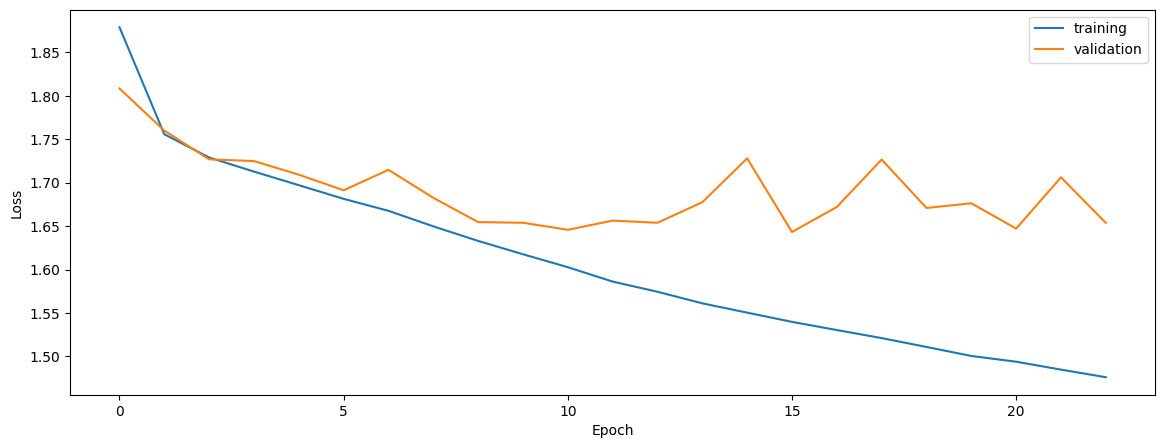

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.39505263276121555
0.34716515096867273
0.3096459616197048


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.4079010056861141
0.4340233881163085
0.32001860690882616


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.4081780312010271
0.4355991875423155
0.3199960143042193


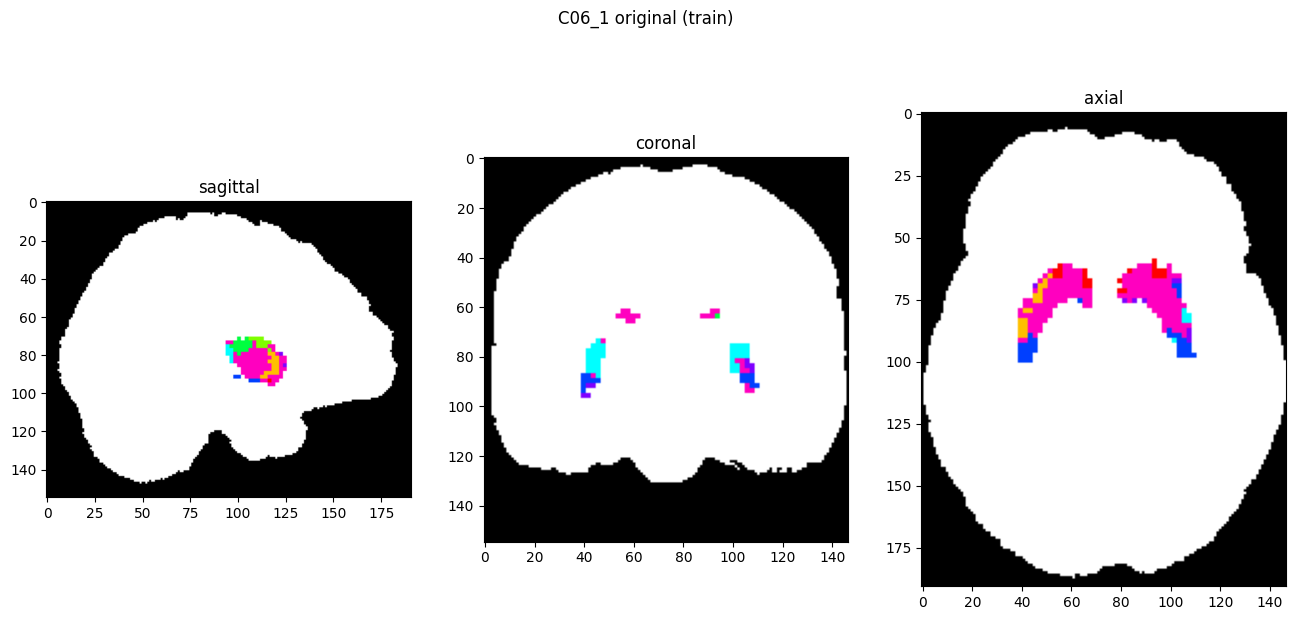

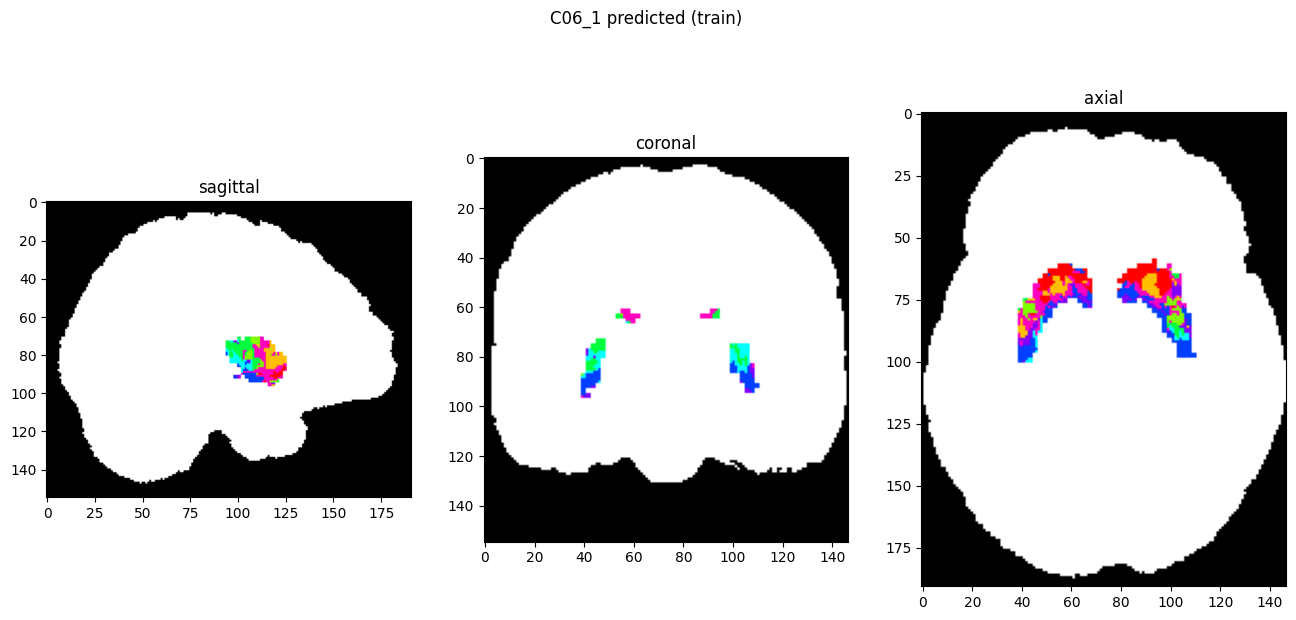

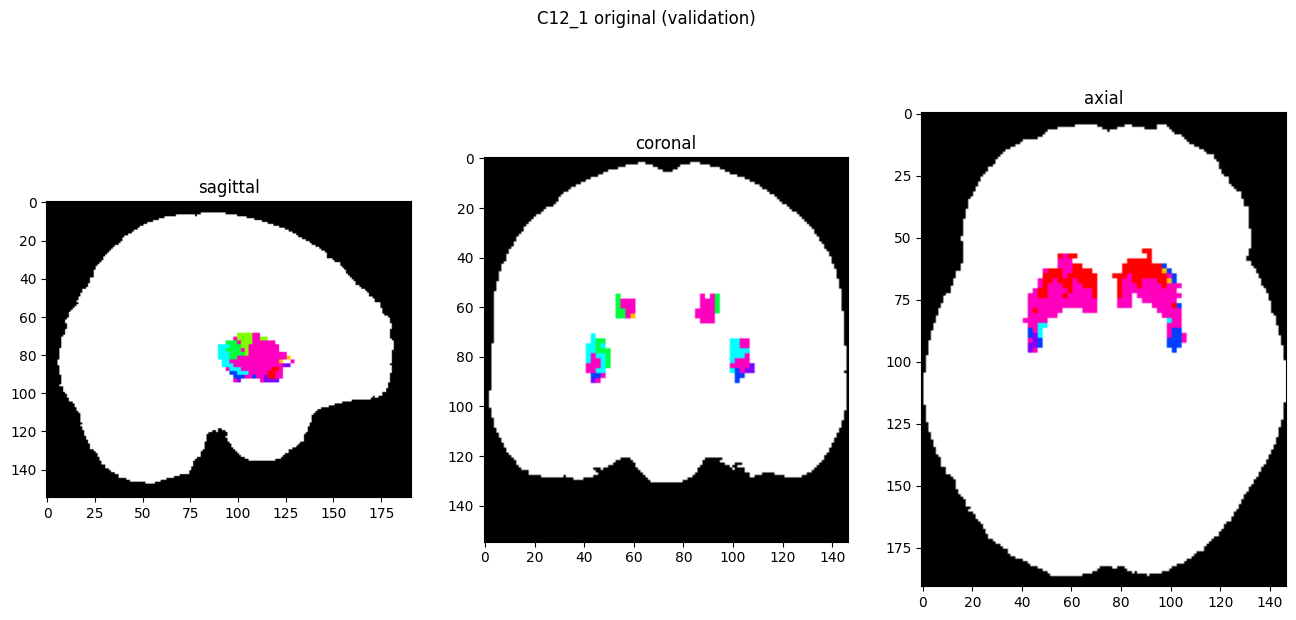

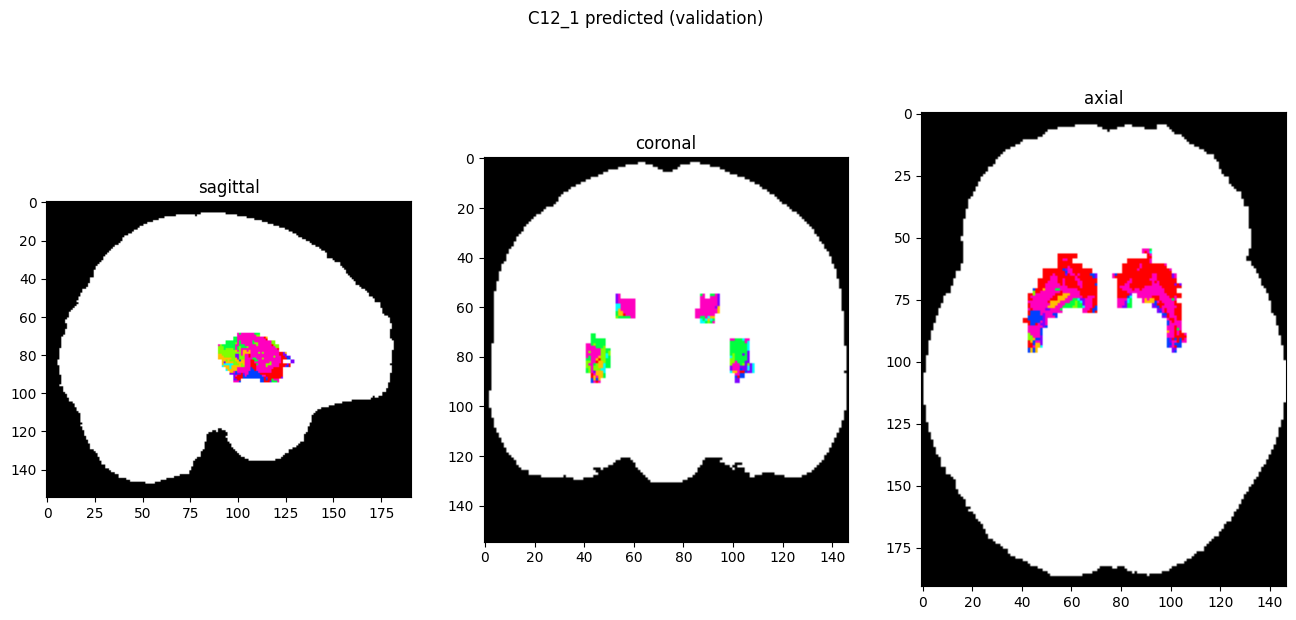

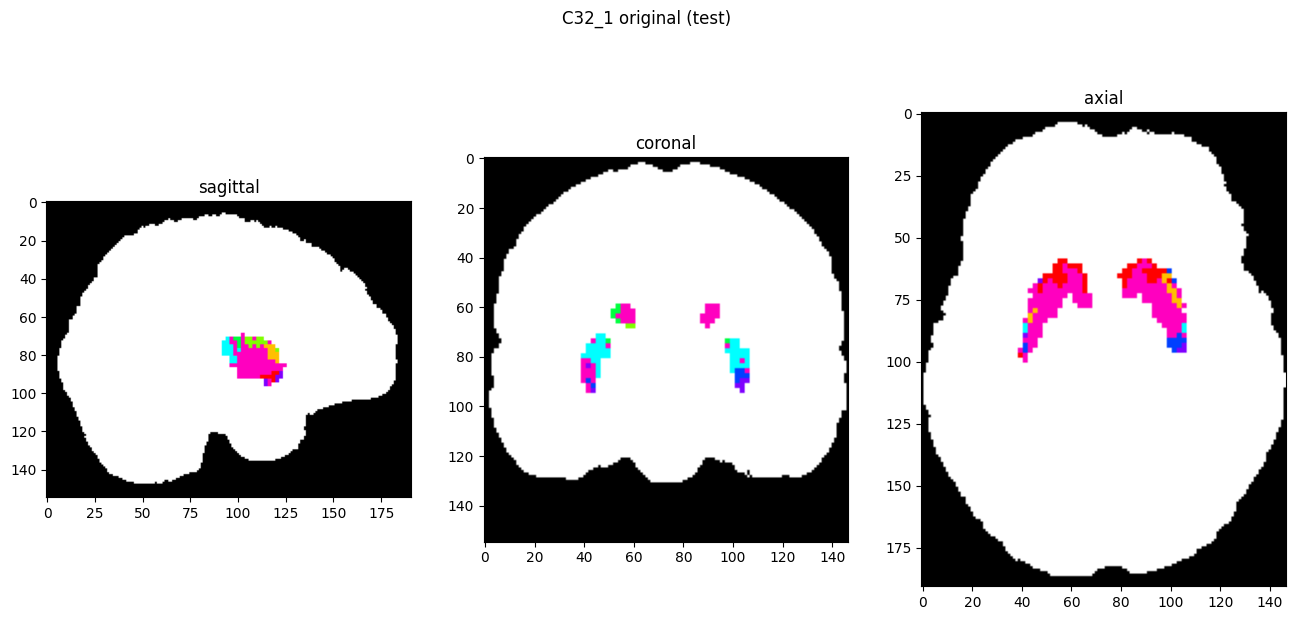

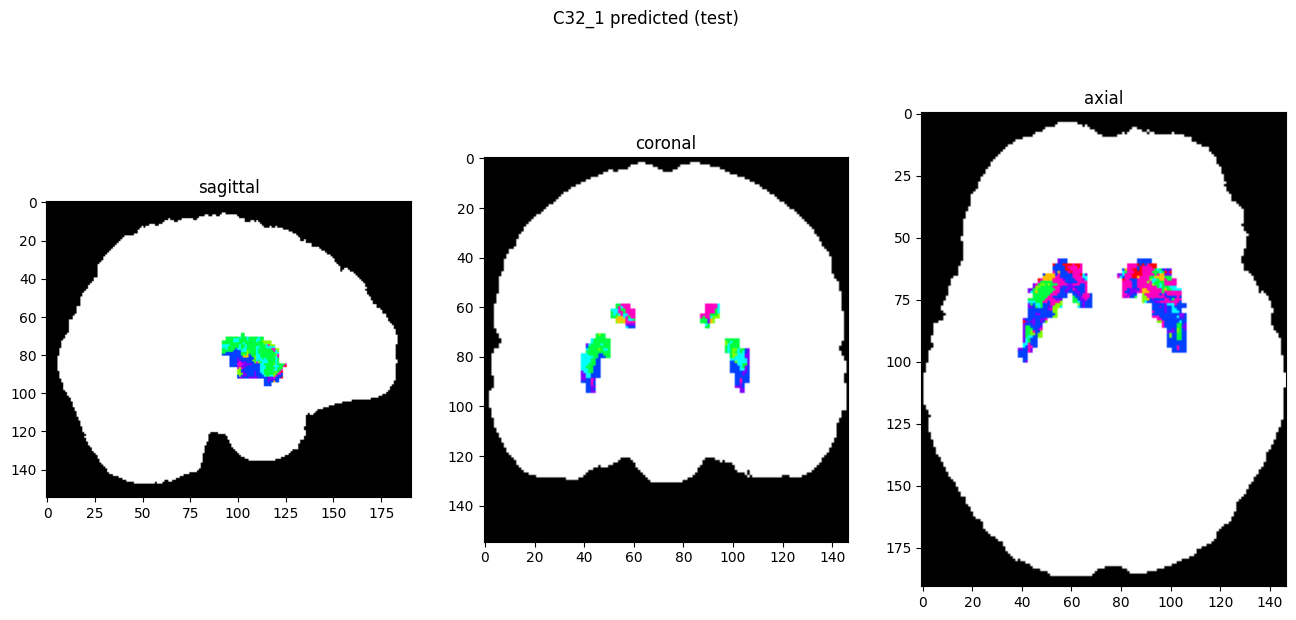

In [10]:
showResults(model, gen, threshold=0)